In [1]:
building_id = 2
price = 106
iteration = 13
# we are ready to run!
ga_file="something.xlsx"
ga_proc="something_else.xlsx"
ga_fina="something_something.xlsx"
runs_num=1
run_i=2
base_path=""

In [2]:
# Parameters
ga_file = "panel_106_dual_200_2.xlsx"
ga_proc = "panel_106_dual_archive_200_2.xlsx"
ga_fina = "panel_106_dual_processed_200_2.xlsx"
runs_num = 200
run_i = 2


In [3]:
############ INPUT FILES  ##############
buildings = ['RefBldgLargeOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgMediumOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgWarehouseNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf']

b_name = ['LargeOffice',
         'MediumOffice',
         'SmallOffice',
         'Warehouse']

idf_file   = base_path+'energy_plus/input_building/idf/upgraded/' + buildings[building_id]
# GA
ga_output_dir = base_path+'ga/bc/' + b_name[building_id] + '/{}/'.format(iteration)
ga_file=ga_output_dir+ga_file
ga_proc=ga_output_dir+ga_proc
ga_fina=ga_output_dir+ga_fina



# Weather file
epw_file   = base_path+'energy_plus/input_building/epw/' + 'CAN_BC_Vancouver.718920_CWEC.epw'

# EnergyHub
ehub_file  = base_path+'ehub/input_ehub_excel/' + 'bc_three.xlsx'
number_of_panels = 3



In [4]:
########### OUTPUT FILES ###############
import os
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)


# EnergyPlus
output_dir = base_path+'energy_plus/output_energy_plus/' + "{}-{}/".format(runs_num,run_i)
error_dir  = base_path+'energy_plus/output_energy_plus/' + "{}-{}/".format(runs_num,run_i)
ensure_dir(output_dir)

# EHUB
ehub_dir   = base_path+'ehub/output_ehub_excel/' + "{}-{}/".format(runs_num,run_i)
ensure_dir(ehub_dir)
res_file   = ehub_dir + "bc_ehub_results.xlsx"
# PV FACTORS
rendered_files = base_path+"rendered_pv_factors/bc/"
ensure_dir(ga_output_dir)
# panel price 400, 200, 106


In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
########### LIBRARIES ###############
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import display, HTML
ep_path="/home/theochri/projects/def-revins/theochri/EnergyPlus/"

# (A) EnergyPlus - North Axis, Electricity & Roof Area

## Run the model:

In [7]:
from pv_model import pvBuilding
# Make the building object
pvbuilding = pvBuilding.PvBuilding(idf_file, out_dir=output_dir,
                                   epw_file=epw_file, err_dir=error_dir,ep_path=ep_path)

/home/theochri/projects/def-revins/theochri/EnergyPlus/


## the North Axis
The north axis gets grabbed automatically from the idf.

In [8]:
pvbuilding.North_Axis

0.0

In [9]:
pvbuilding.Building_Information


Building,
    Ref Bldg Small Office New2004_v1.3_5.0,    !- Name
    0.0,                      !- North Axis
    City,                     !- Terrain
    0.04,                     !- Loads Convergence Tolerance Value
    0.2,                      !- Temperature Convergence Tolerance Value
    FullInteriorAndExterior,    !- Solar Distribution
    25,                       !- Maximum Number of Warmup Days
    6;                        !- Minimum Number of Warmup Days

## Grab the hourly electricity data
Run the model and store the hourly electricity. 

In [10]:
# Determine the hourly electricity use
pvbuilding.run_ep(ep_path=ep_path)

EnergyPlus is found in the path: /home/theochri/projects/def-revins/theochri/EnergyPlus/


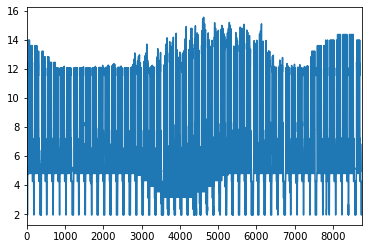

In [11]:
# Show the results in the hourly 
pvbuilding.hourly_electricity.plot()

In [12]:
pvbuilding.max_demand()
pvbuilding.monthly_peak_demand
print(float(pvbuilding.pre_winter_maximum))

The maximum demand charge is: $ 2,059.63
14.35220436334519


## Grab the Roof Area:
To get the roof area we need to feed the sql_file. 

In [13]:
pvbuilding.get_roof_details()
pvbuilding.p_roof_details()

Roof area is 599 m²
Roof area is up 29 m high


# (B) `pvfactors` - Irradience

We will now use pvfactors to find the yearly load of the panels placed at certain angles. Below is some details of how the to translate a panel to the pvfactors package. 


<img src="./images/Example_pvarray.png" alt=""
	title="A cute kitten" width="500" />
    
    
Given that the total area needed is specified by the gcr and the width of the panel:

$\mathrm(ground~area) = \frac{\mathrm(active~area)}{\mathrm(gcr)}$

In [14]:
from pv_model import pvFactors

# Build a pv panel that will live on the building.
pvpanel = pvFactors.PvPanel(rendered_files)
# Setup the Panel on the building. 
# Height of the building and the align the axis with the building
pvpanel.setup_array(pvbuilding)

Calculate the irradiance for a single panel.

ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.606015920639038 sec


ERROR:root:Finished Generation of Irradiance


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.641178607940674 sec


ERROR:root:Finished Generation of Irradiance


0.0


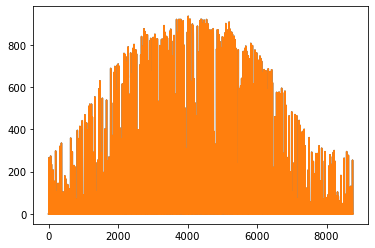

In [15]:
pan_vals = (215, 230, 245, 1, 26, 36, 0.3, 0.7499999999999998, 0.3)

irr1 = pvpanel.irradiance(100,1,0.25,force_recalc=False)
plt.plot(irr1);
type(irr1)
irr2 = pvpanel.irradiance(100,1,0.25,force_recalc=True)
plt.plot(irr2);
print(max(irr1-irr2))

# (C) EnergyHub - Cost and Capacity installed

## Model for BC


| **Name**                 | **Small**        | **Medium**              | **Large**                                            | **Details**                                                                                                                                                    |
| :----------------------- | :--------------- | :---------------------- | :--------------------------------------------------- | :------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Technical Constraint** | Demand \< 35kW   | Demand \>35kW \& \<150kW | Larger than \>150kW or Total energy use \>550,000kWh | Demand is the peak energy use in kW for each month.                                                                                                            |
| Basic Charge             | \$ 0.3645 /day    | \$ 0.2673 /day           | \$ 0.2673 /day                                        |                                                                                                                                                                |
| Demand Charge            | \-               | \$ 5.42/kW               | \$ 12.34/kW                                           | Based on the monthly peak load                                                                                                                                 |
| Energy Charge            | \$ 0.1253 /kWh    | \$ 0.0986 /kWh           | \$ 0.0606 /kWh                                        |                                                                                                                                                                |
| Minimum Charge           | The basic charge | The Minimum charge      | The Minimum Charge                                   | The mimimum charge is equal to 50% of highest winter months demand charge, if the sum of the basic, demand and energy charge is less than this minimum charge. |
| Power Factor Surcharge   | \-               | \-                      | \-                                                   | At low powerfactors                                                                                                                                            |
| Discounts                | \-               | \-                      | \-                                                   | Maintaining good power quality                                                                                                                                 |
| Taxes                    | \-               | \-                      | \-                                                   |                                                                                                                                                                |


(155, 175, 260, 26, 36, 36, 0.65, 0.7, 0.9)
Loading the model
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (155, 175, 260, 26, 36, 36, 0.65, 0.7, 0.9)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 26.0
                                           and a gcr of 0.650


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.554047107696533 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 36.0
                                           and a gcr of 0.700


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.465479850769043 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 36.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.479495048522949 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 141 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 92s


ERROR:ga_logger:panel relevance: [307.537, 0.0, 0.0]


ERROR:ga_logger:Cost: 3187.57


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,188 per year


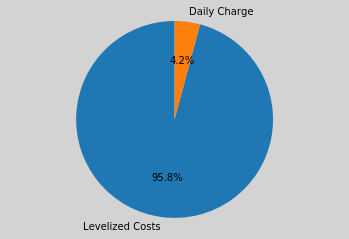

Total roof area of the  building: 599 m²
Total roof area used 473 m²
Percentage: 79.0%


In [16]:
from pv_model import pvModel
# this was the optimal solution
pan_vals = (155,175,260,26,36,36,0.65,0.7,0.9)
gcr=(0.65,0.7,0.9)
print(pan_vals)

# setup the gcr
area_per_panel = [pvpanel.pp['pvrow_depth']*pvpanel.pp['pvrow_width']/gcr[i] for i in range(number_of_panels)]
roof_area_per_unit_capacity = {"PV{}".format(i):area_per_panel[i]  for i in range(number_of_panels)}
# Here's where we instantiate our model. Nothing is solved at this point.

default_settings = {
                    'name': 'glpk-cluster',
                    'solver_path': '/home/theochri/ENV/bin/glpsol',
                    'options': {
                                'mipgap': 0.05,
                               },
                    }
# preload the excel
print("Loading the model")
my_model = pvModel.ModelBC(excel         = ehub_file,\
                           pvbuilding    = pvbuilding,\
                           resultsFile   = res_file,\
                           ROOF_AREA_CAP = roof_area_per_unit_capacity,
                           NUM_PANELS    = number_of_panels,
                           factor_multiplier=3,
                           solver_settings=default_settings)
my_model.eval_model(pan_vals,106,pvpanel)

After evaluating the model we can plot the results. This is a pie chart that breaks down the total cost into the off,on and mid peak costs. 

In [17]:
my_model.energyIm

61845.7

In [18]:
my_model.solveResults['solution']['demand_charge_c'].sum()

demand_charge_c    0.0
dtype: float64

In [19]:
print(my_model.solveResults['solution']['monthly_import'])
print(my_model.solveResults['solution']['monthly_import'].sum())
print(my_model.solveResults['solution']['total_import'])

print(my_model.solveResults['solution']['monthly_export'])
print(my_model.solveResults['solution']['monthly_export'].sum())
print(my_model.solveResults['solution']['total_export'])
print(my_model.solveResults['solution']['daily_charge_c'])


     monthly_import
Apr         4805.72
Aug         5680.08
Dec         5274.31
Feb         4713.95
Jan         5340.70
Jul         5200.48
Jun         5124.65
Mar         5319.26
May         5015.79
Nov         5153.19
Oct         5154.70
Sep         5062.88
monthly_import    61845.71
dtype: float64
61845.7
     monthly_export
Apr         6899.34
Aug         8061.75
Dec         1351.01
Feb         2744.22
Jan         1541.01
Jul         9311.54
Jun         7990.47
Mar         4415.47
May         8175.98
Nov         1793.90
Oct         3229.92
Sep         6330.97
monthly_export    61845.58
dtype: float64
61845.6
133.042


In [20]:
my_model.solveResults['solution']['daily_charge_c']

133.042

In [21]:
my_model.solveResults['solution']['is_installed']

is_installed
GreenEng             0
Grid                 1
Invertor             1
PV0                  1
PV1                  0
PV2                  0

In [22]:
my_model.solveResults['solution']['any_above_35']

0

In [23]:
my_model.solveResults['solution']['a150_or_a550']

0

# (D) GA - Optimize the model

In [24]:
from pv_model import pvOptimizer

range_azi  = range(90,270,5)
range_tilt = range(1,61,5)
range_gcr  = np.arange(0.2, .95, 0.05)

In [25]:
# preload the excel
from pyehub.excel_to_request_format import convert

request_format = convert(excel_file=ehub_file)

In [26]:
import logging
lrun       = logging.getLogger('Runs_logger')
hdlrun       = logging.FileHandler('runs_logger.txt')
formatterrun  = logging.Formatter('%(asctime)s %(message)s')
hdlrun.setFormatter(formatterrun)
lrun.addHandler(hdlrun) 
lrun.setLevel(logging.ERROR)

/home/theochri/paper_pusher/lib/python3.6/site-packages/besos/evaluator.py:395: FutureWarning: EvaluatorSR has been renamed as EvaluatorGeneric with same functionaility. EvaluatorSR will be removed in a future release.
  warn(msg, FutureWarning)
ERROR:optimizer_logger:Started {'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


ERROR:optimizer_logger:0


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


Found the solver set
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (260, 260, 195, 11, 36, 46, 0.44999999999999996, 0.7499999999999998, 0.49999999999999994)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 260
                                           a tilt of 11.0
                                           and a gcr of 0.450


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6437172889709473 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 260
                                           a tilt of 36.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.414078950881958 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 195
                                           a tilt of 46.0
                                           and a gcr of 0.500


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.359879970550537 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 148 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 111s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 299.381]


ERROR:ga_logger:Cost: 3303.34


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0032 /kWh
Total Cost of the system: $ 3,303 per year


Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[260, 260, 195, 11, 36, 46, 0.44999999999999996, 0.7499999999999998, 0.49999999999999994, 3303.34, 299.381, 0.0, 0.0, 299.381, {'Levelized Costs': 2973.505, 'Energy Charge': 196.793, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 60275.17148069381, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (145, 155, 140, 11, 51, 31, 0.39999999999999997, 0.44999999999999996, 0.7)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 145
                                           a tilt of 11.0
                                           and a gcr of 0.400


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.746260166168213 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 155
                                           a tilt of 51.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.459404468536377 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 140
                                           a tilt of 31.0
                                           and a gcr of 0.700


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4791088104248047 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 150 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 91s


ERROR:ga_logger:panel relevance: [132.998, 0.0, 186.388]


ERROR:ga_logger:Cost: 3305.25


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,305 per year


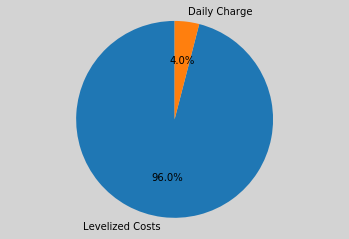

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[145, 155, 140, 11, 51, 31, 0.39999999999999997, 0.44999999999999996, 0.7, 3305.25, 319.38599999999997, 132.998, 0.0, 186.388, {'Levelized Costs': 3172.188, 'Energy Charge': 0.020000000000038654, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60159106008, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (190, 195, 215, 56, 56, 41, 0.5499999999999999, 0.7999999999999998, 0.3)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 190
                                           a tilt of 56.0
                                           and a gcr of 0.550


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6058754920959473 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 195
                                           a tilt of 56.0
                                           and a gcr of 0.800


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4776012897491455 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 215
                                           a tilt of 41.0
                                           and a gcr of 0.300


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4657540321350098 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 144 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 106s


ERROR:ga_logger:panel relevance: [315.018, 0.0, 7.80057]


ERROR:ga_logger:Cost: 3339.35


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,339 per year


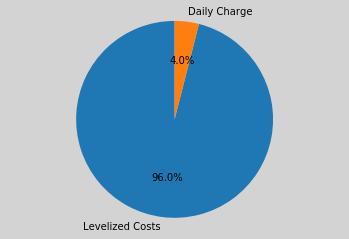

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[190, 195, 215, 56, 56, 41, 0.5499999999999999, 0.7999999999999998, 0.3, 3339.35, 322.81856999999997, 315.018, 0.0, 7.80057, {'Levelized Costs': 3206.2949999999996, 'Energy Charge': 0.013000000000147338, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60077228525, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (165, 205, 240, 31, 51, 16, 0.5499999999999999, 0.35, 0.5999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 165
                                           a tilt of 31.0
                                           and a gcr of 0.550


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.604926347732544 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 205
                                           a tilt of 51.0
                                           and a gcr of 0.350


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.50997257232666 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 240
                                           a tilt of 16.0
                                           and a gcr of 0.600


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5196995735168457 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 150 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 107s


ERROR:ga_logger:panel relevance: [299.622, 0.0, 0.0]


ERROR:ga_logger:Cost: 3108.96


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,109 per year


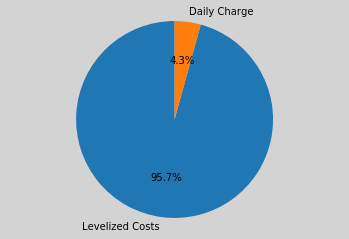

Total roof area of the  building: 599 m²
Total roof area used 545 m²
Percentage: 91.0%
[[165, 205, 240, 31, 51, 16, 0.5499999999999999, 0.35, 0.5999999999999999, 3108.96, 299.622, 299.622, 0.0, 0.0, {'Levelized Costs': 2975.9010000000003, 'Energy Charge': 0.016999999999995907, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60061790007, 61845.7, 544.767]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (190, 140, 145, 26, 41, 46, 0.3, 0.7499999999999998, 0.5999999999999999)


Found the solver set


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 190
                                           a tilt of 26.0
                                           and a gcr of 0.300


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5220842361450195 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 140
                                           a tilt of 41.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.439915180206299 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 145
                                           a tilt of 46.0
                                           and a gcr of 0.600


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.474680185317993 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 143 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 97s


ERROR:ga_logger:panel relevance: [34.8048, 0.0, 289.647]


ERROR:ga_logger:Cost: 3355.58


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,356 per year


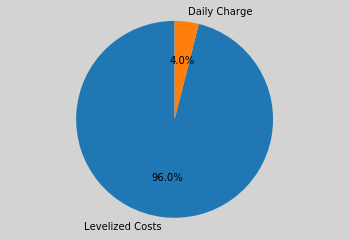

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[190, 140, 145, 26, 41, 46, 0.3, 0.7499999999999998, 0.5999999999999999, 3355.58, 324.4518, 34.8048, 0.0, 289.647, {'Levelized Costs': 3222.5219999999995, 'Energy Charge': 0.016000000000360615, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60207931831, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (125, 95, 120, 21, 41, 36, 0.7999999999999998, 0.6499999999999999, 0.7499999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 125
                                           a tilt of 21.0
                                           and a gcr of 0.800


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5900073051452637 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 95
                                           a tilt of 41.0
                                           and a gcr of 0.650


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.495960235595703 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 120
                                           a tilt of 36.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.654904365539551 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 153 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 94s


ERROR:ga_logger:panel relevance: [336.25, 0.0, 0.0]


ERROR:ga_logger:Cost: 3472.76


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,473 per year


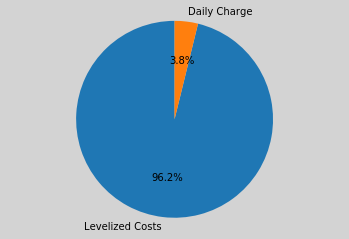

Total roof area of the  building: 599 m²
Total roof area used 420 m²
Percentage: 70.2%
[[125, 95, 120, 21, 41, 36, 0.7999999999999998, 0.6499999999999999, 0.7499999999999998, 3472.76, 336.25, 336.25, 0.0, 0.0, {'Levelized Costs': 3339.703, 'Energy Charge': 0.015000000000100044, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.598510459946, 61845.7, 420.313]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (165, 160, 160, 36, 16, 41, 0.3, 0.44999999999999996, 0.5999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 165
                                           a tilt of 36.0
                                           and a gcr of 0.300


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5647687911987305 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 160
                                           a tilt of 16.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6048038005828857 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 160
                                           a tilt of 41.0
                                           and a gcr of 0.600


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5109753608703613 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 142 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 92s


ERROR:ga_logger:panel relevance: [0.0, 155.468, 151.967]


ERROR:ga_logger:Cost: 3186.56


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,187 per year


Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[165, 160, 160, 36, 16, 41, 0.3, 0.44999999999999996, 0.5999999999999999, 3186.56, 307.435, 0.0, 155.468, 151.967, {'Levelized Costs': 3053.4999999999995, 'Energy Charge': 0.018000000000370164, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60136129998, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (225, 130, 230, 16, 31, 6, 0.7, 0.44999999999999996, 0.5499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 225
                                           a tilt of 16.0
                                           and a gcr of 0.700


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.663011074066162 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 130
                                           a tilt of 31.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.321903705596924 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 230
                                           a tilt of 6.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4903173446655273 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 150 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 103s


ERROR:ga_logger:panel relevance: [134.693, 182.854, 0.0]


ERROR:ga_logger:Cost: 3287.0


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,287 per year


Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[225, 130, 230, 16, 31, 6, 0.7, 0.44999999999999996, 0.5499999999999999, 3287.0, 317.547, 134.693, 182.854, 0.0, {'Levelized Costs': 3153.9369999999994, 'Energy Charge': 0.021000000000469754, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60022474018, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (110, 135, 185, 21, 41, 6, 0.5999999999999999, 0.35, 0.39999999999999997)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 110
                                           a tilt of 21.0
                                           and a gcr of 0.600


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.644263505935669 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 135
                                           a tilt of 41.0
                                           and a gcr of 0.350


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4304468631744385 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 185
                                           a tilt of 6.0
                                           and a gcr of 0.400


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7184581756591797 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 144 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 104s


ERROR:ga_logger:panel relevance: [293.021, 38.6379, 0.0]


ERROR:ga_logger:Cost: 3427.16


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,427 per year


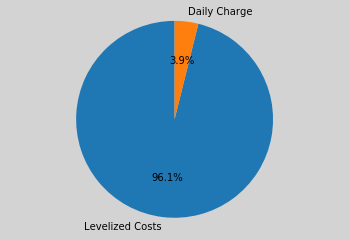

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[110, 135, 185, 21, 41, 6, 0.5999999999999999, 0.35, 0.39999999999999997, 3427.16, 331.6589, 293.021, 38.6379, 0.0, {'Levelized Costs': 3294.114, 'Energy Charge': 0.004000000000019099, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60233802, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (220, 135, 140, 56, 41, 26, 0.39999999999999997, 0.7499999999999998, 0.39999999999999997)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 220
                                           a tilt of 56.0
                                           and a gcr of 0.400


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6003613471984863 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 135
                                           a tilt of 41.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.400847911834717 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 140
                                           a tilt of 26.0
                                           and a gcr of 0.400

ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3874356746673584 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 151 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 105s


ERROR:ga_logger:panel relevance: [0.0, 190.579, 137.862]


ERROR:ga_logger:Cost: 3395.21


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,395 per year


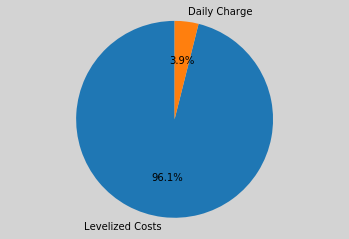

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[220, 135, 140, 56, 41, 26, 0.39999999999999997, 0.7499999999999998, 0.39999999999999997, 3395.21, 328.44100000000003, 0.0, 190.579, 137.862, {'Levelized Costs': 3262.149, 'Energy Charge': 0.019000000000289674, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60130993431, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (195, 245, 150, 36, 46, 16, 0.6499999999999999, 0.49999999999999994, 0.6499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 195
                                           a tilt of 36.0
                                           and a gcr of 0.650


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.632530927658081 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 245
                                           a tilt of 46.0
                                           and a gcr of 0.500


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4709548950195312 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 16.0
                                           and a gcr of 0.650


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.497394561767578 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 147 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 103s


ERROR:ga_logger:panel relevance: [306.839, 0.0, 0.0]


ERROR:ga_logger:Cost: 3180.65


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,181 per year


Total roof area of the  building: 599 m²
Total roof area used 472 m²
Percentage: 78.8%
[[195, 245, 150, 36, 46, 16, 0.6499999999999999, 0.49999999999999994, 0.6499999999999999, 3180.65, 306.839, 306.839, 0.0, 0.0, {'Levelized Costs': 3047.593, 'Energy Charge': 0.015000000000384262, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60253912255, 61845.7, 472.061]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (135, 205, 215, 41, 46, 41, 0.3, 0.49999999999999994, 0.6499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 135
                                           a tilt of 41.0
                                           and a gcr of 0.300


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6430742740631104 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 205
                                           a tilt of 46.0
                                           and a gcr of 0.500


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5254414081573486 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 215
                                           a tilt of 41.0
                                           and a gcr of 0.650


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5488407611846924 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 146 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 137s


ERROR:ga_logger:panel relevance: [0.0, 243.497, 72.6494]


ERROR:ga_logger:Cost: 3273.08


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,273 per year


Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[135, 205, 215, 41, 46, 41, 0.3, 0.49999999999999994, 0.6499999999999999, 3273.08, 316.1464, 0.0, 243.497, 72.6494, {'Levelized Costs': 3140.024, 'Energy Charge': 0.014000000000066848, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600858608545, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (95, 210, 140, 41, 46, 41, 0.7499999999999998, 0.6499999999999999, 0.49999999999999994)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 95
                                           a tilt of 41.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6391265392303467 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 210
                                           a tilt of 46.0
                                           and a gcr of 0.650


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.512695074081421 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 140
                                           a tilt of 41.0
                                           and a gcr of 0.500


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.597439765930176 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 142 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 92s


ERROR:ga_logger:panel relevance: [0.0, 94.4848, 226.7]


ERROR:ga_logger:Cost: 3323.13


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,323 per year


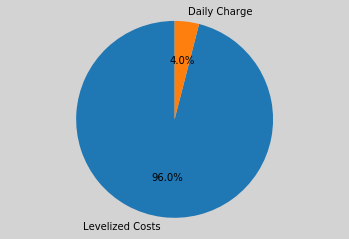

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[95, 210, 140, 41, 46, 41, 0.7499999999999998, 0.6499999999999999, 0.49999999999999994, 3323.13, 321.1848, 0.0, 94.4848, 226.7, {'Levelized Costs': 3190.0750000000003, 'Energy Charge': 0.012999999999976808, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601187235865, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (100, 240, 250, 56, 46, 36, 0.39999999999999997, 0.44999999999999996, 0.25)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 100
                                           a tilt of 56.0
                                           and a gcr of 0.400


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5455334186553955 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 240
                                           a tilt of 46.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.335216522216797 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 250
                                           a tilt of 36.0
                                           and a gcr of 0.250


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.393129825592041 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 143 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 89s


ERROR:ga_logger:panel relevance: [0.0, 269.443, 0.0]


ERROR:ga_logger:Cost: 4588.32


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0288 /kWh
Total Cost of the system: $ 4,588 per year


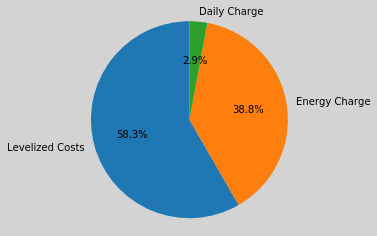

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[100, 240, 250, 56, 46, 36, 0.39999999999999997, 0.44999999999999996, 0.25, 4588.32, 269.443, 0.0, 269.443, 0.0, {'Levelized Costs': 2676.1579999999994, 'Energy Charge': 1779.1200000000003, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 47646.82312661395, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (125, 215, 245, 21, 31, 16, 0.6499999999999999, 0.39999999999999997, 0.7999999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 125
                                           a tilt of 21.0
                                           and a gcr of 0.650


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5358922481536865 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 215
                                           a tilt of 31.0
                                           and a gcr of 0.400


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.421064853668213 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 16.0
                                           and a gcr of 0.800


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4290084838867188 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 140 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 99s


ERROR:ga_logger:panel relevance: [201.606, 115.439, 0.0]


ERROR:ga_logger:Cost: 3282.02


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,282 per year


Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[125, 215, 245, 21, 31, 16, 0.6499999999999999, 0.39999999999999997, 0.7999999999999998, 3282.02, 317.04499999999996, 201.606, 115.439, 0.0, {'Levelized Costs': 3148.963, 'Energy Charge': 0.014999999999986358, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60136566998, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (145, 110, 95, 16, 41, 31, 0.7, 0.3, 0.39999999999999997)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 145
                                           a tilt of 16.0
                                           and a gcr of 0.700


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5061612129211426 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 110
                                           a tilt of 41.0
                                           and a gcr of 0.300


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4594333171844482 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 95
                                           a tilt of 31.0
                                           and a gcr of 0.400


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5797252655029297 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 143 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 91s


ERROR:ga_logger:panel relevance: [314.501, 0.0, 0.0]


ERROR:ga_logger:Cost: 3256.74


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,257 per year


Total roof area of the  building: 599 m²
Total roof area used 449 m²
Percentage: 75.0%
[[145, 110, 95, 16, 41, 31, 0.7, 0.3, 0.39999999999999997, 3256.74, 314.501, 314.501, 0.0, 0.0, {'Levelized Costs': 3123.6879999999996, 'Energy Charge': 0.009999999999990905, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600874097945, 61845.7, 449.287]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (240, 145, 215, 56, 21, 11, 0.8999999999999999, 0.3, 0.8999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 240
                                           a tilt of 56.0
                                           and a gcr of 0.900


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5740325450897217 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 145
                                           a tilt of 21.0
                                           and a gcr of 0.300


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4512112140655518 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 215
                                           a tilt of 11.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.524177074432373 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 144 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 103s


ERROR:ga_logger:panel relevance: [0.0, 110.0, 208.884]


ERROR:ga_logger:Cost: 3300.28


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,300 per year


Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[240, 145, 215, 56, 21, 11, 0.8999999999999999, 0.3, 0.8999999999999999, 3300.28, 318.884, 0.0, 110.0, 208.884, {'Levelized Costs': 3167.2260000000006, 'Energy Charge': 0.011999999999886768, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602607584326, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (140, 220, 250, 21, 31, 51, 0.3, 0.35, 0.6499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 140
                                           a tilt of 21.0
                                           and a gcr of 0.300


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6235694885253906 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 220
                                           a tilt of 31.0
                                           and a gcr of 0.350


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4738168716430664 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 250
                                           a tilt of 51.0
                                           and a gcr of 0.650


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.536813259124756 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 141 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 100s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 389.195]


ERROR:ga_logger:Cost: 4343.04


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0056 /kWh
Total Cost of the system: $ 4,343 per year


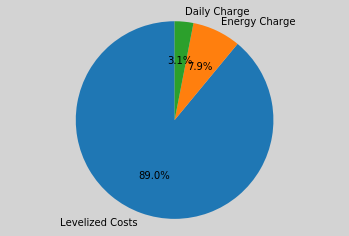

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[140, 220, 250, 21, 31, 51, 0.3, 0.35, 0.6499999999999999, 4343.04, 389.195, 0.0, 0.0, 389.195, {'Levelized Costs': 3865.565, 'Energy Charge': 344.43300000000005, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 59096.83174870498, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (230, 145, 205, 46, 6, 36, 0.7499999999999998, 0.5499999999999999, 0.7499999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 230
                                           a tilt of 46.0
                                           and a gcr of 0.750


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6134164333343506 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 145
                                           a tilt of 6.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4019739627838135 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 205
                                           a tilt of 36.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4681031703948975 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 145 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 105s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 321.549]


ERROR:ga_logger:Cost: 3326.75


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,327 per year


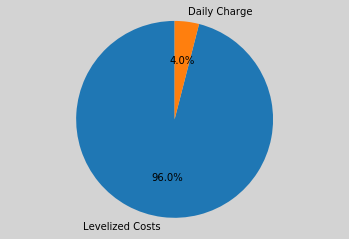

Total roof area of the  building: 599 m²
Total roof area used 429 m²
Percentage: 71.6%
[[230, 145, 205, 46, 6, 36, 0.7499999999999998, 0.5499999999999999, 0.7499999999999998, 3326.75, 321.549, 0.0, 0.0, 321.549, {'Levelized Costs': 3193.6929999999998, 'Energy Charge': 0.015000000000213731, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60234985684, 61845.7, 428.733]]


The maximum power used is 16 kW


The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (210, 200, 120, 41, 26, 26, 0.5999999999999999, 0.7, 0.7999999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 210
                                           a tilt of 41.0
                                           and a gcr of 0.600


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.492227077484131 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 200
                                           a tilt of 26.0
                                           and a gcr of 0.700


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5210373401641846 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 120
                                           a tilt of 26.0
                                           and a gcr of 0.800


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4927401542663574 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 146 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 104s


ERROR:ga_logger:panel relevance: [0.0, 308.439, 0.0]


ERROR:ga_logger:Cost: 3196.53


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,197 per year


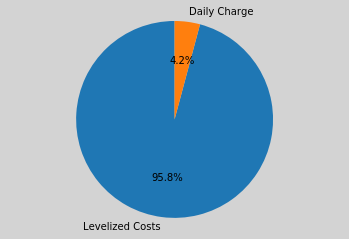

Total roof area of the  building: 599 m²
Total roof area used 441 m²
Percentage: 73.6%
[[210, 200, 120, 41, 26, 26, 0.5999999999999999, 0.7, 0.7999999999999998, 3196.53, 308.439, 0.0, 308.439, 0.0, {'Levelized Costs': 3063.476, 'Energy Charge': 0.012000000000170985, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60127116979, 61845.7, 440.627]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (200, 195, 140, 51, 51, 46, 0.7999999999999998, 0.3, 0.7499999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 200
                                           a tilt of 51.0
                                           and a gcr of 0.800


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.494187593460083 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 195
                                           a tilt of 51.0
                                           and a gcr of 0.300


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.436321496963501 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 140
                                           a tilt of 46.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5985183715820312 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 144 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 138s


ERROR:ga_logger:panel relevance: [242.881, 88.5483, 0.0]


ERROR:ga_logger:Cost: 3424.87


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,425 per year


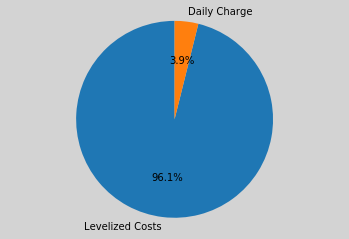

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[200, 195, 140, 51, 51, 46, 0.7999999999999998, 0.3, 0.7499999999999998, 3424.87, 331.4293, 242.881, 88.5483, 0.0, {'Levelized Costs': 3291.812, 'Energy Charge': 0.016000000000076398, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60127812152, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (165, 230, 105, 31, 21, 6, 0.49999999999999994, 0.3, 0.49999999999999994)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 165
                                           a tilt of 31.0
                                           and a gcr of 0.500


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.508208990097046 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 230
                                           a tilt of 21.0
                                           and a gcr of 0.300


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.992830514907837 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 105
                                           a tilt of 6.0
                                           and a gcr of 0.500


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3628857135772705 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 145 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 119s


ERROR:ga_logger:panel relevance: [297.503, 0.0, 0.0]


ERROR:ga_logger:Cost: 3087.92


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,088 per year


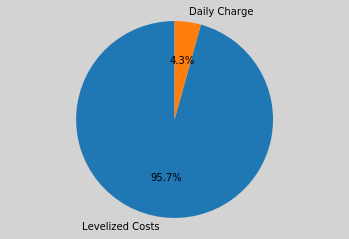

Total roof area of the  building: 599 m²
Total roof area used 595 m²
Percentage: 99.4%
[[165, 230, 105, 31, 21, 6, 0.49999999999999994, 0.3, 0.49999999999999994, 3087.92, 297.503, 297.503, 0.0, 0.0, {'Levelized Costs': 2954.86, 'Energy Charge': 0.018000000000029104, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.6034186, 61845.7, 595.006]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (100, 205, 195, 6, 46, 36, 0.6499999999999999, 0.7, 0.5499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 100
                                           a tilt of 6.0
                                           and a gcr of 0.650


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.487337112426758 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 205
                                           a tilt of 46.0
                                           and a gcr of 0.700


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4167943000793457 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 195
                                           a tilt of 36.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.429626703262329 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 143 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 103s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 301.136]


ERROR:ga_logger:Cost: 3124.0


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,124 per year


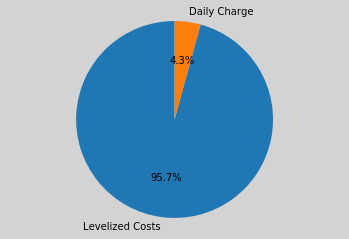

Total roof area of the  building: 599 m²
Total roof area used 548 m²
Percentage: 91.4%
[[100, 205, 195, 6, 46, 36, 0.6499999999999999, 0.7, 0.5499999999999999, 3124.0, 301.136, 0.0, 0.0, 301.136, {'Levelized Costs': 2990.945, 'Energy Charge': 0.013000000000090495, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60144218881, 61845.7, 547.519]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (255, 185, 175, 31, 31, 21, 0.44999999999999996, 0.44999999999999996, 0.5999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 255
                                           a tilt of 31.0
                                           and a gcr of 0.450


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8079516887664795 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 31.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.59584379196167 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 21.0
                                           and a gcr of 0.600


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4059481620788574 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 150 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 111s


ERROR:ga_logger:panel relevance: [0.0, 188.752, 107.587]


ERROR:ga_logger:Cost: 3076.36


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,076 per year


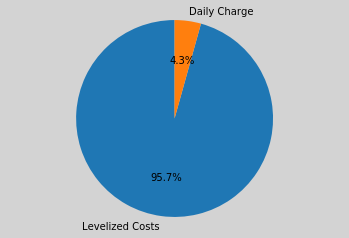

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[255, 185, 175, 31, 31, 21, 0.44999999999999996, 0.44999999999999996, 0.5999999999999999, 3076.36, 296.339, 0.0, 188.752, 107.587, {'Levelized Costs': 2943.2960000000003, 'Energy Charge': 0.022000000000048203, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602093655034, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (250, 125, 130, 36, 41, 21, 0.8499999999999999, 0.8499999999999999, 0.8999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 250
                                           a tilt of 36.0
                                           and a gcr of 0.850


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5400941371917725 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 125
                                           a tilt of 41.0
                                           and a gcr of 0.850


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4074013233184814 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 130
                                           a tilt of 21.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4202733039855957 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 144 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 96s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 343.859]


ERROR:ga_logger:Cost: 3548.33


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,548 per year


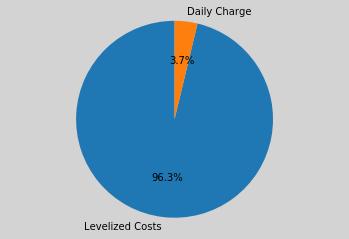

Total roof area of the  building: 599 m²
Total roof area used 382 m²
Percentage: 63.8%
[[250, 125, 130, 36, 41, 21, 0.8499999999999999, 0.8499999999999999, 0.8999999999999999, 3548.33, 343.859, 0.0, 0.0, 343.859, {'Levelized Costs': 3415.2799999999997, 'Energy Charge': 0.008000000000265572, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60193758003, 61845.7, 382.065]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (260, 235, 260, 41, 31, 51, 0.25, 0.5499999999999999, 0.7499999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 260
                                           a tilt of 41.0
                                           and a gcr of 0.250


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.42090106010437 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 235
                                           a tilt of 31.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4290578365325928 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 51.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4068796634674072 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 142 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 100s


ERROR:ga_logger:panel relevance: [0.0, 328.826, 0.0]


ERROR:ga_logger:Cost: 3399.02


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,399 per year


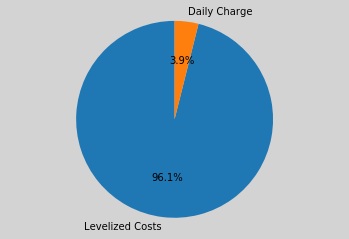

Total roof area of the  building: 599 m²
Total roof area used 598 m²
Percentage: 99.9%
[[260, 235, 260, 41, 31, 51, 0.25, 0.5499999999999999, 0.7499999999999998, 3399.02, 328.826, 0.0, 328.826, 0.0, {'Levelized Costs': 3265.9599999999996, 'Energy Charge': 0.018000000000370164, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60112120738, 61845.7, 597.866]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (185, 210, 210, 46, 26, 6, 0.25, 0.5499999999999999, 0.3)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 46.0
                                           and a gcr of 0.250


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.517462968826294 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 210
                                           a tilt of 26.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4351375102996826 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 210
                                           a tilt of 6.0
                                           and a gcr of 0.300


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.656930923461914 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 145 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 101s


ERROR:ga_logger:panel relevance: [19.97, 285.385, 0.0]


ERROR:ga_logger:Cost: 3165.9


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,166 per year


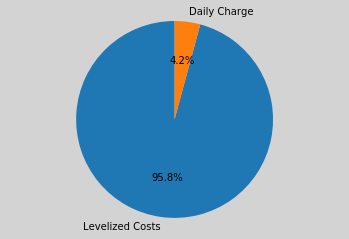

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[185, 210, 210, 46, 26, 6, 0.25, 0.5499999999999999, 0.3, 3165.9, 305.355, 19.97, 285.385, 0.0, {'Levelized Costs': 3032.841, 'Energy Charge': 0.017000000000109594, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60165167127, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (210, 240, 115, 16, 46, 21, 0.5499999999999999, 0.44999999999999996, 0.7499999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 210
                                           a tilt of 16.0
                                           and a gcr of 0.550


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5116379261016846 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 240
                                           a tilt of 46.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.409296751022339 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 115
                                           a tilt of 21.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4050683975219727 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 141 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 101s


ERROR:ga_logger:panel relevance: [309.903, 0.0, 0.0]


ERROR:ga_logger:Cost: 3211.08


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,211 per year


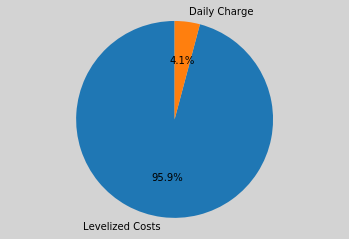

Total roof area of the  building: 599 m²
Total roof area used 563 m²
Percentage: 94.1%
[[210, 240, 115, 16, 46, 21, 0.5499999999999999, 0.44999999999999996, 0.7499999999999998, 3211.08, 309.903, 309.903, 0.0, 0.0, {'Levelized Costs': 3078.027, 'Energy Charge': 0.011000000000080945, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.6006884918, 61845.7, 563.461]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (230, 215, 120, 21, 6, 31, 0.7, 0.7, 0.44999999999999996)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 230
                                           a tilt of 21.0
                                           and a gcr of 0.700


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.044750452041626 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 215
                                           a tilt of 6.0
                                           and a gcr of 0.700


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.626391887664795 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 120
                                           a tilt of 31.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4087085723876953 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 143 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 94s


ERROR:ga_logger:panel relevance: [0.0, 324.4, 0.0]


ERROR:ga_logger:Cost: 3355.06


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,355 per year


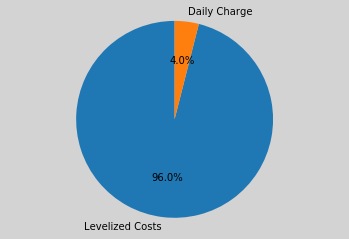

Total roof area of the  building: 599 m²
Total roof area used 463 m²
Percentage: 77.4%
[[230, 215, 120, 21, 6, 31, 0.7, 0.7, 0.44999999999999996, 3355.06, 324.4, 0.0, 324.4, 0.0, {'Levelized Costs': 3222.004, 'Energy Charge': 0.014000000000237378, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60170174724, 61845.7, 463.429]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (115, 105, 245, 36, 51, 6, 0.7, 0.7999999999999998, 0.25)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 115
                                           a tilt of 36.0
                                           and a gcr of 0.700


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.495041847229004 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 105
                                           a tilt of 51.0
                                           and a gcr of 0.800


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.410426378250122 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 6.0
                                           and a gcr of 0.250


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4206361770629883 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 144 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 96s


ERROR:ga_logger:panel relevance: [324.559, 0.0, 33.7764]


ERROR:ga_logger:Cost: 3692.12


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,692 per year


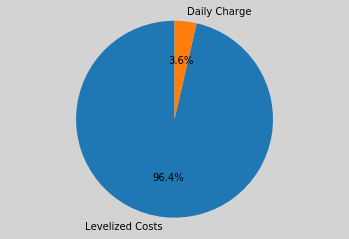

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[115, 105, 245, 36, 51, 6, 0.7, 0.7999999999999998, 0.25, 3692.12, 358.33540000000005, 324.559, 0.0, 33.7764, {'Levelized Costs': 3559.064, 'Energy Charge': 0.014000000000066848, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601609599944, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (150, 130, 215, 56, 31, 46, 0.7, 0.44999999999999996, 0.8999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 150
                                           a tilt of 56.0
                                           and a gcr of 0.700


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.467088222503662 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 130
                                           a tilt of 31.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3674938678741455 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 215
                                           a tilt of 46.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3657724857330322 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 145 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 103s


ERROR:ga_logger:panel relevance: [0.0, 207.044, 124.798]


ERROR:ga_logger:Cost: 3428.97


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,429 per year


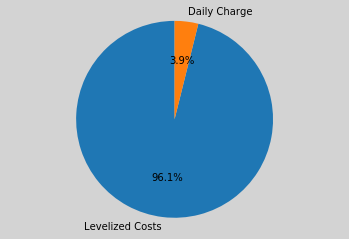

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[150, 130, 215, 56, 31, 46, 0.7, 0.44999999999999996, 0.8999999999999999, 3428.97, 331.842, 0.0, 207.044, 124.798, {'Levelized Costs': 3295.917, 'Energy Charge': 0.011000000000137788, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60101475998, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (175, 210, 185, 26, 56, 51, 0.7, 0.8499999999999999, 0.3)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 175
                                           a tilt of 26.0
                                           and a gcr of 0.700


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7415413856506348 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 210
                                           a tilt of 56.0
                                           and a gcr of 0.850


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5425732135772705 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 185
                                           a tilt of 51.0
                                           and a gcr of 0.300


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5351409912109375 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 140 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 108s


ERROR:ga_logger:panel relevance: [216.948, 0.0, 86.6508]


ERROR:ga_logger:Cost: 3148.46


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,148 per year


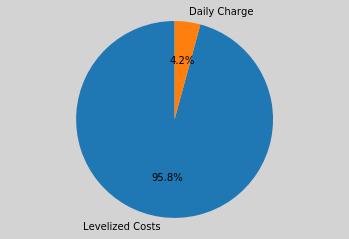

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[175, 210, 185, 26, 56, 51, 0.7, 0.8499999999999999, 0.3, 3148.46, 303.5988, 216.948, 0.0, 86.6508, {'Levelized Costs': 3015.405, 'Energy Charge': 0.013000000000147338, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.599488757674, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (185, 105, 105, 56, 21, 31, 0.25, 0.44999999999999996, 0.35)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 56.0
                                           and a gcr of 0.250


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.637110948562622 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 105
                                           a tilt of 21.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.443472385406494 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 105
                                           a tilt of 31.0
                                           and a gcr of 0.350


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.453130006790161 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 142 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 133s


ERROR:ga_logger:panel relevance: [0.0, 269.443, 0.0]


ERROR:ga_logger:Cost: 4280.54


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0238 /kWh
Total Cost of the system: $ 4,281 per year


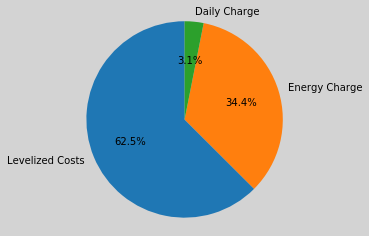

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[185, 105, 105, 56, 21, 31, 0.25, 0.44999999999999996, 0.35, 4280.54, 269.443, 0.0, 269.443, 0.0, {'Levelized Costs': 2676.163, 'Energy Charge': 1471.335, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 50103.22395964992, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (155, 200, 95, 16, 11, 31, 0.44999999999999996, 0.7999999999999998, 0.7499999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 16.0
                                           and a gcr of 0.450


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.489880323410034 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 200
                                           a tilt of 11.0
                                           and a gcr of 0.800


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.464430332183838 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 95
                                           a tilt of 31.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5360236167907715 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 142 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 95s


ERROR:ga_logger:panel relevance: [218.97, 89.7293, 0.0]


ERROR:ga_logger:Cost: 3199.12


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,199 per year


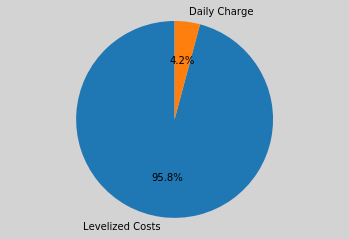

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[155, 200, 95, 16, 11, 31, 0.44999999999999996, 0.7999999999999998, 0.7499999999999998, 3199.12, 308.6993, 218.97, 89.7293, 0.0, {'Levelized Costs': 3066.0679999999998, 'Energy Charge': 0.010000000000161435, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600247856775, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (220, 245, 160, 46, 6, 46, 0.44999999999999996, 0.8499999999999999, 0.7)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 220
                                           a tilt of 46.0
                                           and a gcr of 0.450


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4970715045928955 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 245
                                           a tilt of 6.0
                                           and a gcr of 0.850


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.006062746047974 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 160
                                           a tilt of 46.0
                                           and a gcr of 0.700


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.378490686416626 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 150 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 111s


ERROR:ga_logger:panel relevance: [170.625, 0.0, 153.716]


ERROR:ga_logger:Cost: 3354.48


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,354 per year


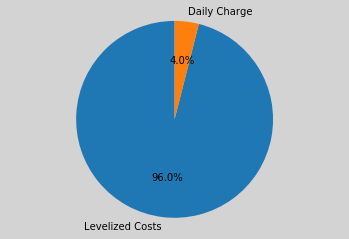

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[220, 245, 160, 46, 6, 46, 0.44999999999999996, 0.8499999999999999, 0.7, 3354.48, 324.341, 170.625, 0.0, 153.716, {'Levelized Costs': 3221.427, 'Energy Charge': 0.010999999999967258, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60135471592, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (195, 260, 190, 51, 16, 16, 0.49999999999999994, 0.44999999999999996, 0.3)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 195
                                           a tilt of 51.0
                                           and a gcr of 0.500


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5500924587249756 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 260
                                           a tilt of 16.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.471644878387451 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 190
                                           a tilt of 16.0
                                           and a gcr of 0.300


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.45200514793396 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 144 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 94s


ERROR:ga_logger:panel relevance: [299.381, 0.0, 0.0]


ERROR:ga_logger:Cost: 3469.04


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0059 /kWh
Total Cost of the system: $ 3,469 per year


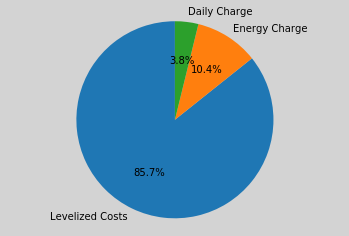

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[195, 260, 190, 51, 16, 16, 0.49999999999999994, 0.44999999999999996, 0.3, 3469.04, 299.381, 299.381, 0.0, 0.0, {'Levelized Costs': 2973.518, 'Energy Charge': 362.4799999999999, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 58952.79615539783, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (165, 180, 230, 36, 16, 51, 0.44999999999999996, 0.49999999999999994, 0.3)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 165
                                           a tilt of 36.0
                                           and a gcr of 0.450


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.504455327987671 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 16.0
                                           and a gcr of 0.500


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.362241744995117 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 230
                                           a tilt of 51.0
                                           and a gcr of 0.300


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3996307849884033 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 144 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 90s


ERROR:ga_logger:panel relevance: [0.0, 299.381, 0.0]


ERROR:ga_logger:Cost: 3207.98


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0016 /kWh
Total Cost of the system: $ 3,208 per year


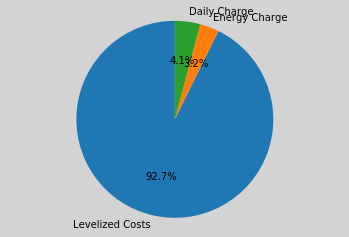

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[165, 180, 230, 36, 16, 51, 0.44999999999999996, 0.49999999999999994, 0.3, 3207.98, 299.381, 0.0, 299.381, 0.0, {'Levelized Costs': 2973.512, 'Energy Charge': 101.42599999999976, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61036.24050493747, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (115, 205, 190, 16, 11, 16, 0.8999999999999999, 0.8999999999999999, 0.7)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 115
                                           a tilt of 16.0
                                           and a gcr of 0.900


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.735229730606079 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 205
                                           a tilt of 11.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.535839080810547 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 190
                                           a tilt of 16.0
                                           and a gcr of 0.700


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4325084686279297 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 140 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 94s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 307.646]


ERROR:ga_logger:Cost: 3188.66


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,189 per year


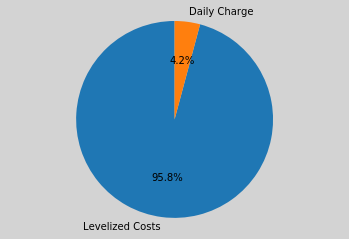

Total roof area of the  building: 599 m²
Total roof area used 439 m²
Percentage: 73.4%
[[115, 205, 190, 16, 11, 16, 0.8999999999999999, 0.8999999999999999, 0.7, 3188.66, 307.646, 0.0, 0.0, 307.646, {'Levelized Costs': 3055.611, 'Energy Charge': 0.007000000000118689, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.603892552455, 61845.7, 439.494]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (255, 255, 185, 6, 11, 41, 0.49999999999999994, 0.7499999999999998, 0.5499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 255
                                           a tilt of 6.0
                                           and a gcr of 0.500


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.767951726913452 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 255
                                           a tilt of 11.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.252074241638184 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 185
                                           a tilt of 41.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.421410083770752 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 143 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 109s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 300.738]


ERROR:ga_logger:Cost: 3120.05


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,120 per year


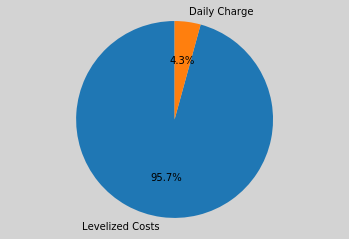

Total roof area of the  building: 599 m²
Total roof area used 547 m²
Percentage: 91.3%
[[255, 255, 185, 6, 11, 41, 0.49999999999999994, 0.7499999999999998, 0.5499999999999999, 3120.05, 300.738, 0.0, 0.0, 300.738, {'Levelized Costs': 2986.991, 'Energy Charge': 0.017000000000280124, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60104401412, 61845.7, 546.797]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (195, 110, 160, 21, 31, 6, 0.8999999999999999, 0.5999999999999999, 0.3)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 195
                                           a tilt of 21.0
                                           and a gcr of 0.900


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.054337024688721 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 110
                                           a tilt of 31.0
                                           and a gcr of 0.600


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3493690490722656 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 160
                                           a tilt of 6.0
                                           and a gcr of 0.300


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.601166009902954 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 140 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 104s


ERROR:ga_logger:panel relevance: [212.774, 0.0, 108.704]


ERROR:ga_logger:Cost: 3326.04


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,326 per year


Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[195, 110, 160, 21, 31, 6, 0.8999999999999999, 0.5999999999999999, 0.3, 3326.04, 321.478, 212.774, 0.0, 108.704, {'Levelized Costs': 3192.984, 'Energy Charge': 0.014000000000351065, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600399461386, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (220, 235, 260, 41, 41, 6, 0.7999999999999998, 0.3, 0.7999999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 220
                                           a tilt of 41.0
                                           and a gcr of 0.800


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5853495597839355 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 235
                                           a tilt of 41.0
                                           and a gcr of 0.300


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5120913982391357 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 6.0
                                           and a gcr of 0.800


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7031900882720947 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 144 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 100s


ERROR:ga_logger:panel relevance: [0.0, 86.8122, 247.51]


ERROR:ga_logger:Cost: 3453.61


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,454 per year


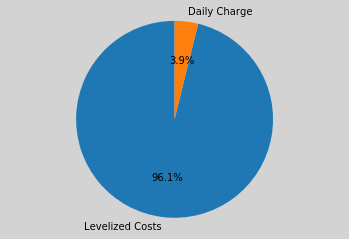

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[220, 235, 260, 41, 41, 6, 0.7999999999999998, 0.3, 0.7999999999999998, 3453.61, 334.3222, 0.0, 86.8122, 247.51, {'Levelized Costs': 3320.556, 'Energy Charge': 0.011999999999943611, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60259320301, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (120, 225, 95, 26, 56, 16, 0.5999999999999999, 0.8999999999999999, 0.7499999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 120
                                           a tilt of 26.0
                                           and a gcr of 0.600


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.564824342727661 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 225
                                           a tilt of 56.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4791033267974854 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 95
                                           a tilt of 16.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.481609344482422 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 145 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 93s


ERROR:ga_logger:panel relevance: [329.511, 0.0, 0.0]


ERROR:ga_logger:Cost: 3405.83


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,406 per year


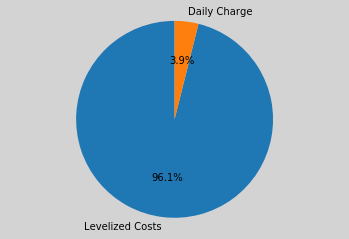

Total roof area of the  building: 599 m²
Total roof area used 549 m²
Percentage: 91.7%
[[120, 225, 95, 26, 56, 16, 0.5999999999999999, 0.8999999999999999, 0.7499999999999998, 3405.83, 329.511, 329.511, 0.0, 0.0, {'Levelized Costs': 3272.772, 'Energy Charge': 0.016000000000246928, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60125464997, 61845.7, 549.186]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (125, 180, 250, 36, 26, 31, 0.39999999999999997, 0.3, 0.39999999999999997)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 125
                                           a tilt of 36.0
                                           and a gcr of 0.400


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5488622188568115 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 26.0
                                           and a gcr of 0.300


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3967511653900146 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 250
                                           a tilt of 31.0
                                           and a gcr of 0.400


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.506711006164551 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 142 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 97s


ERROR:ga_logger:panel relevance: [239.505, 0.0, 0.0]


ERROR:ga_logger:Cost: 4481.4


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0318 /kWh
Total Cost of the system: $ 4,481 per year


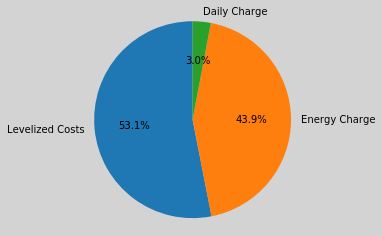

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[125, 180, 250, 36, 26, 31, 0.39999999999999997, 0.3, 0.39999999999999997, 4481.4, 239.505, 239.505, 0.0, 0.0, {'Levelized Costs': 2378.8079999999995, 'Energy Charge': 1969.55, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 46127.05071911997, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63

ERROR:ga_logger:panel values: (230, 210, 210, 31, 26, 6, 0.44999999999999996, 0.49999999999999994, 0.5499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 230
                                           a tilt of 31.0
                                           and a gcr of 0.450


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5957019329071045 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 210
                                           a tilt of 26.0
                                           and a gcr of 0.500


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4569172859191895 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 210
                                           a tilt of 6.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4337637424468994 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 143 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 95s


ERROR:ga_logger:panel relevance: [0.0, 299.381, 0.0]


ERROR:ga_logger:Cost: 3236.25


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0021 /kWh
Total Cost of the system: $ 3,236 per year


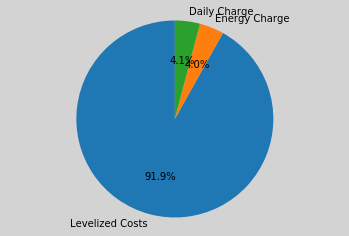

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[230, 210, 210, 31, 26, 6, 0.44999999999999996, 0.49999999999999994, 0.5499999999999999, 3236.25, 299.381, 0.0, 299.381, 0.0, {'Levelized Costs': 2973.5060000000003, 'Energy Charge': 129.70199999999994, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 60810.61285814451, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (95, 220, 235, 16, 31, 56, 0.5999999999999999, 0.5499999999999999, 0.5499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 95
                                           a tilt of 16.0
                                           and a gcr of 0.600


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.443605899810791 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 220
                                           a tilt of 31.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.543081283569336 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 235
                                           a tilt of 56.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4976534843444824 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 144 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 108s


ERROR:ga_logger:panel relevance: [0.0, 314.498, 0.0]


ERROR:ga_logger:Cost: 3256.71


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,257 per year


Total roof area of the  building: 599 m²
Total roof area used 572 m²
Percentage: 95.5%
[[95, 220, 235, 16, 31, 56, 0.5999999999999999, 0.5499999999999999, 0.5499999999999999, 3256.71, 314.498, 0.0, 314.498, 0.0, {'Levelized Costs': 3123.645, 'Energy Charge': 0.023000000000138243, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60211893238, 61845.7, 571.815]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (95, 105, 215, 6, 51, 56, 0.7499999999999998, 0.5499999999999999, 0.49999999999999994)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 95
                                           a tilt of 6.0
                                           and a gcr of 0.750


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.633297920227051 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 105
                                           a tilt of 51.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5367958545684814 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 215
                                           a tilt of 56.0
                                           and a gcr of 0.500


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5904622077941895 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 147 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 92s


ERROR:ga_logger:panel relevance: [335.479, 0.0, 0.0]


ERROR:ga_logger:Cost: 3465.1


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,465 per year


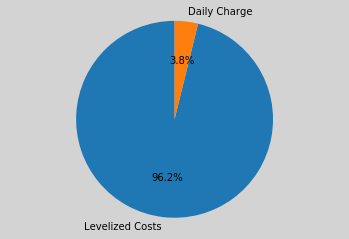

Total roof area of the  building: 599 m²
Total roof area used 447 m²
Percentage: 74.7%
[[95, 105, 215, 6, 51, 56, 0.7499999999999998, 0.5499999999999999, 0.49999999999999994, 3465.1, 335.479, 335.479, 0.0, 0.0, {'Levelized Costs': 3332.0519999999997, 'Energy Charge': 0.006000000000312866, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60093336978, 61845.7, 447.305]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (190, 180, 225, 46, 16, 46, 0.6499999999999999, 0.7499999999999998, 0.39999999999999997)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 190
                                           a tilt of 46.0
                                           and a gcr of 0.650


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.67819881439209 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 16.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5475926399230957 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 225
                                           a tilt of 46.0
                                           and a gcr of 0.400


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5745744705200195 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 146 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 134s


ERROR:ga_logger:panel relevance: [0.0, 309.436, 0.0]


ERROR:ga_logger:Cost: 3206.44


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,206 per year


Total roof area of the  building: 599 m²
Total roof area used 413 m²
Percentage: 68.9%
[[190, 180, 225, 46, 16, 46, 0.6499999999999999, 0.7499999999999998, 0.39999999999999997, 3206.44, 309.436, 0.0, 309.436, 0.0, {'Levelized Costs': 3073.3810000000003, 'Energy Charge': 0.016999999999939064, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60264157121, 61845.7, 412.582]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (130, 130, 165, 46, 11, 6, 0.7, 0.35, 0.35)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 130
                                           a tilt of 46.0
                                           and a gcr of 0.700


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.629007577896118 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 130
                                           a tilt of 11.0
                                           and a gcr of 0.350


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.389246940612793 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 165
                                           a tilt of 6.0
                                           and a gcr of 0.350


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.427354574203491 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 142 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 105s


ERROR:ga_logger:panel relevance: [280.053, 69.5403, 0.0]


ERROR:ga_logger:Cost: 3605.28


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,605 per year


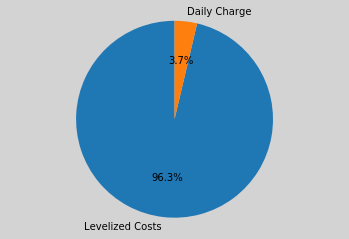

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[130, 130, 165, 46, 11, 6, 0.7, 0.35, 0.35, 3605.28, 349.5933, 280.053, 69.5403, 0.0, {'Levelized Costs': 3472.225, 'Energy Charge': 0.013000000000261025, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60116316992, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (110, 185, 250, 51, 26, 56, 0.7999999999999998, 0.5499999999999999, 0.5499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 110
                                           a tilt of 51.0
                                           and a gcr of 0.800


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6464200019836426 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 26.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.514350414276123 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 250
                                           a tilt of 56.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4236416816711426 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 143 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 92s


ERROR:ga_logger:panel relevance: [0.0, 296.926, 0.0]


ERROR:ga_logger:Cost: 3082.18


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,082 per year


Total roof area of the  building: 599 m²
Total roof area used 540 m²
Percentage: 90.2%
[[110, 185, 250, 51, 26, 56, 0.7999999999999998, 0.5499999999999999, 0.5499999999999999, 3082.18, 296.926, 0.0, 296.926, 0.0, {'Levelized Costs': 2949.124, 'Energy Charge': 0.014000000000066848, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60133061498, 61845.7, 539.865]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (100, 95, 95, 31, 6, 51, 0.5499999999999999, 0.25, 0.49999999999999994)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 100
                                           a tilt of 31.0
                                           and a gcr of 0.550


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6023409366607666 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 95
                                           a tilt of 6.0
                                           and a gcr of 0.250


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4823801517486572 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 95
                                           a tilt of 51.0
                                           and a gcr of 0.500


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3834657669067383 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 145 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 90s


ERROR:ga_logger:panel relevance: [329.319, 0.0, 0.0]


ERROR:ga_logger:Cost: 4033.64


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0102 /kWh
Total Cost of the system: $ 4,034 per year


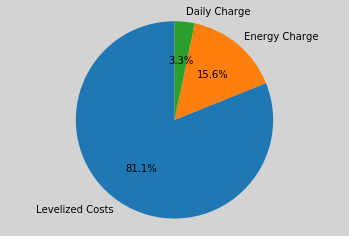

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[100, 95, 95, 31, 6, 51, 0.5499999999999999, 0.25, 0.49999999999999994, 4033.64, 329.319, 329.319, 0.0, 0.0, {'Levelized Costs': 3270.859, 'Energy Charge': 629.7390000000001, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 56819.896463300094, 61845.7, 598.762]]


ERROR:optimizer_logger:50


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (255, 260, 220, 6, 26, 56, 0.44999999999999996, 0.25, 0.39999999999999997)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 255
                                           a tilt of 6.0
                                           and a gcr of 0.450


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8393828868865967 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 260
                                           a tilt of 26.0
                                           and a gcr of 0.250


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4604814052581787 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 220
                                           a tilt of 56.0
                                           and a gcr of 0.400


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4754459857940674 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 147 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 98s


ERROR:ga_logger:panel relevance: [269.443, 0.0, 0.0]


ERROR:ga_logger:Cost: 4304.02


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0242 /kWh
Total Cost of the system: $ 4,304 per year


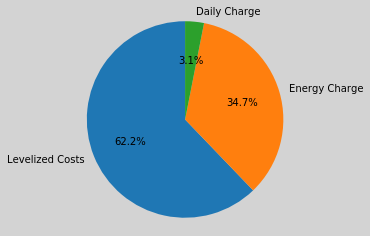

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[255, 260, 220, 6, 26, 56, 0.44999999999999996, 0.25, 0.39999999999999997, 4304.02, 269.443, 269.443, 0.0, 0.0, {'Levelized Costs': 2676.1500000000005, 'Energy Charge': 1494.828, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 49915.7635895864, 61845.7, 598.762]]


The maximum power used is 16 kW


The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (265, 155, 95, 11, 56, 11, 0.8499999999999999, 0.6499999999999999, 0.39999999999999997)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 265
                                           a tilt of 11.0
                                           and a gcr of 0.850


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.962056875228882 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 155
                                           a tilt of 56.0
                                           and a gcr of 0.650


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5416860580444336 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 95
                                           a tilt of 11.0
                                           and a gcr of 0.400


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5035741329193115 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 148 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 104s


ERROR:ga_logger:panel relevance: [0.0, 263.319, 77.4621]


ERROR:ga_logger:Cost: 3517.76


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,518 per year


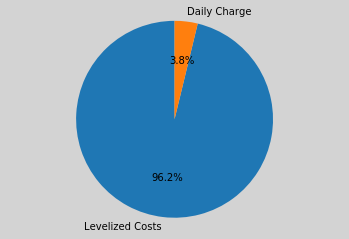

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[265, 155, 95, 11, 56, 11, 0.8499999999999999, 0.6499999999999999, 0.39999999999999997, 3517.76, 340.78110000000004, 0.0, 263.319, 77.4621, {'Levelized Costs': 3384.702, 'Energy Charge': 0.01600000000013324, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602032489915, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (230, 190, 100, 46, 51, 41, 0.5999999999999999, 0.44999999999999996, 0.8999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 230
                                           a tilt of 46.0
                                           and a gcr of 0.600


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5860650539398193 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 190
                                           a tilt of 51.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5533976554870605 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 100
                                           a tilt of 41.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.480588436126709 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 157 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 101s


ERROR:ga_logger:panel relevance: [291.633, 50.7178, 0.0]


ERROR:ga_logger:Cost: 3533.36


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,533 per year


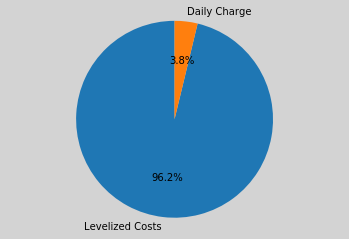

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[230, 190, 100, 46, 51, 41, 0.5999999999999999, 0.44999999999999996, 0.8999999999999999, 3533.36, 342.3508, 291.633, 50.7178, 0.0, {'Levelized Costs': 3400.299, 'Energy Charge': 0.019000000000119144, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60026003339, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (190, 225, 100, 1, 16, 21, 0.8999999999999999, 0.7, 0.5499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 190
                                           a tilt of 1.0
                                           and a gcr of 0.900


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.6757214069366455 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 225
                                           a tilt of 16.0
                                           and a gcr of 0.700


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.589385509490967 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 100
                                           a tilt of 21.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5243897438049316 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 140 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 99s


ERROR:ga_logger:panel relevance: [0.0, 320.922, 0.0]


ERROR:ga_logger:Cost: 3320.52


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,321 per year


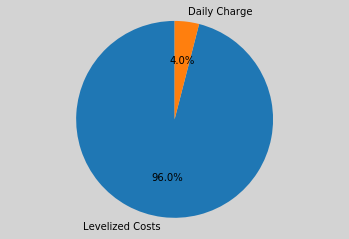

Total roof area of the  building: 599 m²
Total roof area used 458 m²
Percentage: 76.6%
[[190, 225, 100, 1, 16, 21, 0.8999999999999999, 0.7, 0.5499999999999999, 3320.52, 320.922, 0.0, 320.922, 0.0, {'Levelized Costs': 3187.469, 'Energy Charge': 0.008999999999900865, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.603113673475, 61845.7, 458.46]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (110, 240, 210, 1, 41, 36, 0.49999999999999994, 0.35, 0.3)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 110
                                           a tilt of 1.0
                                           and a gcr of 0.500


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.6332035064697266 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 240
                                           a tilt of 41.0
                                           and a gcr of 0.350


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5148353576660156 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 210
                                           a tilt of 36.0
                                           and a gcr of 0.300


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4578585624694824 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 155 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 96s


ERROR:ga_logger:panel relevance: [299.381, 0.0, 0.0]


ERROR:ga_logger:Cost: 3927.52


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0133 /kWh
Total Cost of the system: $ 3,928 per year


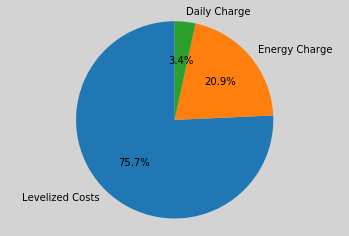

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[110, 240, 210, 1, 41, 36, 0.49999999999999994, 0.35, 0.3, 3927.52, 299.381, 299.381, 0.0, 0.0, {'Levelized Costs': 2973.511, 'Energy Charge': 820.9670000000002, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 55293.73113626485, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (100, 210, 140, 41, 51, 21, 0.44999999999999996, 0.7499999999999998, 0.44999999999999996)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 100
                                           a tilt of 41.0
                                           and a gcr of 0.450


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6119511127471924 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 210
                                           a tilt of 51.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5344908237457275 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 140
                                           a tilt of 21.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.54958438873291 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 171 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 97s


ERROR:ga_logger:panel relevance: [0.0, 133.575, 189.298]


ERROR:ga_logger:Cost: 3339.89


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,340 per year


Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[100, 210, 140, 41, 51, 21, 0.44999999999999996, 0.7499999999999998, 0.44999999999999996, 3339.89, 322.873, 0.0, 133.575, 189.298, {'Levelized Costs': 3206.841, 'Energy Charge': 0.007000000000289219, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60104678036, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (105, 220, 150, 56, 51, 56, 0.39999999999999997, 0.3, 0.8999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 105
                                           a tilt of 56.0
                                           and a gcr of 0.400


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7123382091522217 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 220
                                           a tilt of 51.0
                                           and a gcr of 0.300


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4563169479370117 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 56.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4280357360839844 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 144 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 103s


ERROR:ga_logger:panel relevance: [0.0, 88.1474, 274.443]


ERROR:ga_logger:Cost: 3734.38


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,734 per year


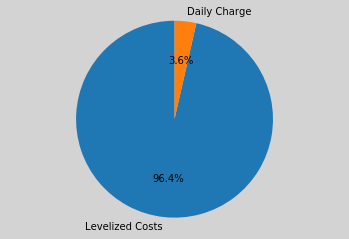

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[105, 220, 150, 56, 51, 56, 0.39999999999999997, 0.3, 0.8999999999999999, 3734.38, 362.5904, 0.0, 88.1474, 274.443, {'Levelized Costs': 3601.322, 'Energy Charge': 0.016000000000190084, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60102738428, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (170, 225, 225, 56, 51, 26, 0.7999999999999998, 0.39999999999999997, 0.3)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 170
                                           a tilt of 56.0
                                           and a gcr of 0.800


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.789064407348633 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 225
                                           a tilt of 51.0
                                           and a gcr of 0.400


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5860257148742676 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 225
                                           a tilt of 26.0
                                           and a gcr of 0.300


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7682278156280518 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 153 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 113s


ERROR:ga_logger:panel relevance: [249.12, 0.0, 86.2085]


ERROR:ga_logger:Cost: 3463.61


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,464 per year


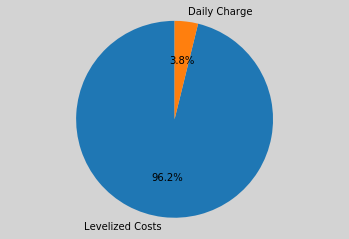

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[170, 225, 225, 56, 51, 26, 0.7999999999999998, 0.39999999999999997, 0.3, 3463.61, 335.3285, 249.12, 0.0, 86.2085, {'Levelized Costs': 3330.556, 'Energy Charge': 0.012000000000000455, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59987311572, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (115, 165, 250, 11, 51, 51, 0.44999999999999996, 0.49999999999999994, 0.2)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 115
                                           a tilt of 11.0
                                           and a gcr of 0.450


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5839455127716064 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 165
                                           a tilt of 51.0
                                           and a gcr of 0.500


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.608429193496704 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 250
                                           a tilt of 51.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5909066200256348 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 151 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 99s


ERROR:ga_logger:panel relevance: [0.0, 299.381, 0.0]


ERROR:ga_logger:Cost: 3472.37


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0059 /kWh
Total Cost of the system: $ 3,472 per year


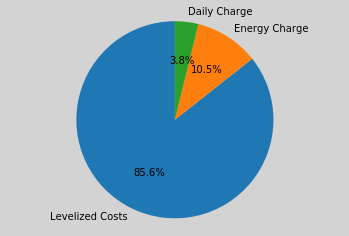

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[115, 165, 250, 11, 51, 51, 0.44999999999999996, 0.49999999999999994, 0.2, 3472.37, 299.381, 0.0, 299.381, 0.0, {'Levelized Costs': 2973.5029999999997, 'Energy Charge': 365.8250000000001, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 58926.14975239983, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (165, 185, 90, 56, 51, 56, 0.49999999999999994, 0.7499999999999998, 0.5499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 165
                                           a tilt of 56.0
                                           and a gcr of 0.500


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.032774448394775 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 51.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.445612907409668 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 56.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4775338172912598 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 173 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 101s


ERROR:ga_logger:panel relevance: [250.641, 73.1104, 0.0]


ERROR:ga_logger:Cost: 3348.62


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,349 per year


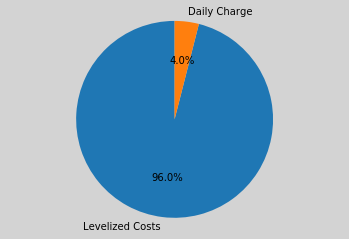

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[165, 185, 90, 56, 51, 56, 0.49999999999999994, 0.7499999999999998, 0.5499999999999999, 3348.62, 323.7514, 250.641, 73.1104, 0.0, {'Levelized Costs': 3215.56, 'Energy Charge': 0.01800000000014279, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60143481985, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (195, 160, 145, 46, 11, 46, 0.8999999999999999, 0.7, 0.6499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 195
                                           a tilt of 46.0
                                           and a gcr of 0.900


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5779366493225098 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 160
                                           a tilt of 11.0
                                           and a gcr of 0.700


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.418560743331909 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 145
                                           a tilt of 46.0
                                           and a gcr of 0.650


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.43188738822937 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 174 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 103s


ERROR:ga_logger:panel relevance: [0.0, 313.99, 0.0]


ERROR:ga_logger:Cost: 3251.67


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,252 per year


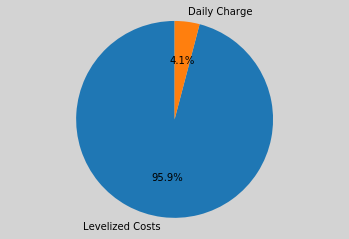

Total roof area of the  building: 599 m²
Total roof area used 449 m²
Percentage: 74.9%
[[195, 160, 145, 46, 11, 46, 0.8999999999999999, 0.7, 0.6499999999999999, 3251.67, 313.99, 0.0, 313.99, 0.0, {'Levelized Costs': 3118.619, 'Energy Charge': 0.009000000000128239, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60117474769, 61845.7, 448.557]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (140, 195, 255, 31, 26, 56, 0.44999999999999996, 0.39999999999999997, 0.7999999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 140
                                           a tilt of 31.0
                                           and a gcr of 0.450


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5859858989715576 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 195
                                           a tilt of 26.0
                                           and a gcr of 0.400


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.603034019470215 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 255
                                           a tilt of 56.0
                                           and a gcr of 0.800


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5671842098236084 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 153 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 106s


ERROR:ga_logger:panel relevance: [269.443, 0.0, 0.0]


ERROR:ga_logger:Cost: 3762.32


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0154 /kWh
Total Cost of the system: $ 3,762 per year


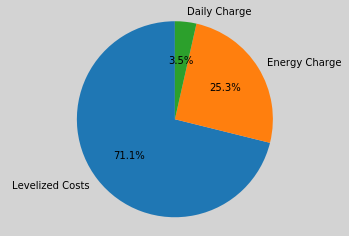

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[140, 195, 255, 31, 26, 56, 0.44999999999999996, 0.39999999999999997, 0.7999999999999998, 3762.32, 269.443, 269.443, 0.0, 0.0, {'Levelized Costs': 2676.1560000000004, 'Energy Charge': 953.1220000000001, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 54239.00043237003, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (110, 220, 150, 26, 11, 56, 0.49999999999999994, 0.5499999999999999, 0.2)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 110
                                           a tilt of 26.0
                                           and a gcr of 0.500


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.598576068878174 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 220
                                           a tilt of 11.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.9894704818725586 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 56.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.492177963256836 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 167 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 107s


ERROR:ga_logger:panel relevance: [0.0, 311.807, 6.36788]


ERROR:ga_logger:Cost: 3293.24


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,293 per year


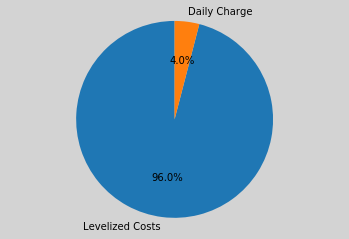

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[110, 220, 150, 26, 11, 56, 0.49999999999999994, 0.5499999999999999, 0.2, 3293.24, 318.17488000000003, 0.0, 311.807, 6.36788, {'Levelized Costs': 3160.182, 'Energy Charge': 0.016000000000076398, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60128698755, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (130, 225, 230, 11, 41, 51, 0.5499999999999999, 0.7999999999999998, 0.25)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 130
                                           a tilt of 11.0
                                           and a gcr of 0.550


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6707427501678467 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 225
                                           a tilt of 41.0
                                           and a gcr of 0.800


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.533081293106079 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 230
                                           a tilt of 51.0
                                           and a gcr of 0.250


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.515014886856079 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 146 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 104s


ERROR:ga_logger:panel relevance: [319.242, 0.0, 0.0]


ERROR:ga_logger:Cost: 3303.83


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,304 per year


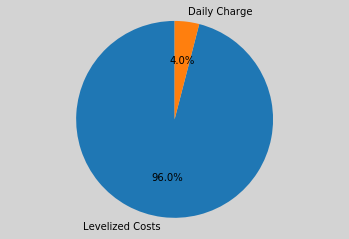

Total roof area of the  building: 599 m²
Total roof area used 580 m²
Percentage: 96.9%
[[130, 225, 230, 11, 41, 51, 0.5499999999999999, 0.7999999999999998, 0.25, 3303.83, 319.242, 319.242, 0.0, 0.0, {'Levelized Costs': 3170.786, 'Energy Charge': 0.002000000000066393, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60156387515, 61845.7, 580.44]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (230, 260, 245, 16, 16, 6, 0.6499999999999999, 0.7499999999999998, 0.5999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 230
                                           a tilt of 16.0
                                           and a gcr of 0.650


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7618324756622314 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 260
                                           a tilt of 16.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5703680515289307 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 6.0
                                           and a gcr of 0.600


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5963387489318848 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 154 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 99s


ERROR:ga_logger:panel relevance: [321.846, 0.0, 0.0]


ERROR:ga_logger:Cost: 3329.7


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,330 per year


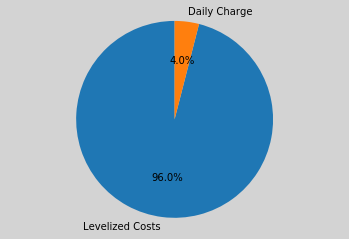

Total roof area of the  building: 599 m²
Total roof area used 495 m²
Percentage: 82.7%
[[230, 260, 245, 16, 16, 6, 0.6499999999999999, 0.7499999999999998, 0.5999999999999999, 3329.7, 321.846, 321.846, 0.0, 0.0, {'Levelized Costs': 3196.6329999999994, 'Energy Charge': 0.02500000000043201, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59952707499, 61845.7, 495.148]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (205, 260, 255, 16, 21, 51, 0.2, 0.25, 0.8499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 205
                                           a tilt of 16.0
                                           and a gcr of 0.200


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.1495161056518555 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 260
                                           a tilt of 21.0
                                           and a gcr of 0.250


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.032334089279175 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 255
                                           a tilt of 51.0
                                           and a gcr of 0.850


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.712707996368408 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 145 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 107s


ERROR:ga_logger:panel relevance: [18.0824, 0.0, 432.097]


ERROR:ga_logger:Cost: 4604.33


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 4,604 per year


Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[205, 260, 255, 16, 21, 51, 0.2, 0.25, 0.8499999999999999, 4604.33, 450.1794, 18.0824, 0.0, 432.097, {'Levelized Costs': 4471.273999999999, 'Energy Charge': 0.013999999999896318, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60107554893, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (130, 105, 195, 11, 56, 46, 0.7499999999999998, 0.3, 0.5499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 130
                                           a tilt of 11.0
                                           and a gcr of 0.750


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.590850830078125 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 105
                                           a tilt of 56.0
                                           and a gcr of 0.300


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5016908645629883 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 195
                                           a tilt of 46.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5991764068603516 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 146 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 113s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 310.142]


ERROR:ga_logger:Cost: 3213.45


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,213 per year


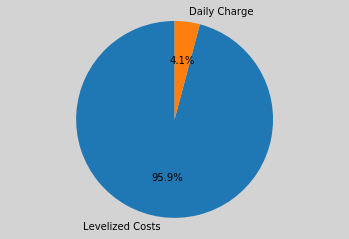

Total roof area of the  building: 599 m²
Total roof area used 564 m²
Percentage: 94.2%
[[130, 105, 195, 11, 56, 46, 0.7499999999999998, 0.3, 0.5499999999999999, 3213.45, 310.142, 0.0, 0.0, 310.142, {'Levelized Costs': 3080.3969999999995, 'Energy Charge': 0.011000000000194632, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600705366436, 61845.7, 563.895]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (120, 120, 240, 51, 46, 21, 0.7499999999999998, 0.5499999999999999, 0.2)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 120
                                           a tilt of 51.0
                                           and a gcr of 0.750


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7847437858581543 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 120
                                           a tilt of 46.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.752516031265259 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 240
                                           a tilt of 21.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.276561260223389 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 212 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 110s


ERROR:ga_logger:panel relevance: [162.531, 210.13, 0.0]


ERROR:ga_logger:Cost: 3834.39


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,834 per year


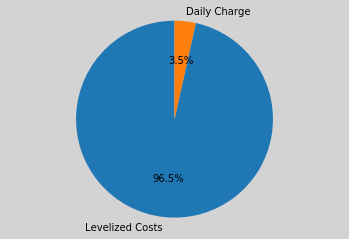

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[120, 120, 240, 51, 46, 21, 0.7499999999999998, 0.5499999999999999, 0.2, 3834.39, 372.661, 162.531, 210.13, 0.0, {'Levelized Costs': 3701.3309999999997, 'Energy Charge': 0.017000000000166438, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60085240008, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (105, 255, 265, 6, 1, 41, 0.39999999999999997, 0.8499999999999999, 0.44999999999999996)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 105
                                           a tilt of 6.0
                                           and a gcr of 0.400


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6051025390625 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 255
                                           a tilt of 1.0
                                           and a gcr of 0.850


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.59946608543396 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 41.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8640382289886475 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 162 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 104s


ERROR:ga_logger:panel relevance: [156.106, 177.222, 0.0]


ERROR:ga_logger:Cost: 3443.74


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,444 per year


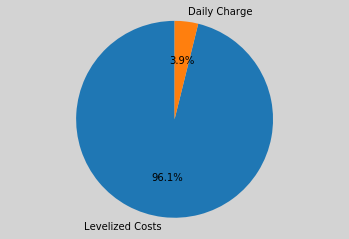

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[105, 255, 265, 6, 1, 41, 0.39999999999999997, 0.8499999999999999, 0.44999999999999996, 3443.74, 333.328, 156.106, 177.222, 0.0, {'Levelized Costs': 3310.6769999999997, 'Energy Charge': 0.021000000000185537, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602321986735, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (185, 155, 210, 31, 6, 51, 0.35, 0.8499999999999999, 0.25)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 31.0
                                           and a gcr of 0.350


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3576784133911133 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 155
                                           a tilt of 6.0
                                           and a gcr of 0.850


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2771832942962646 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 210
                                           a tilt of 51.0
                                           and a gcr of 0.250


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2609150409698486 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s

ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 139 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 112s


ERROR:ga_logger:panel relevance: [140.202, 168.457, 0.0]


ERROR:ga_logger:Cost: 3198.72


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,199 per year


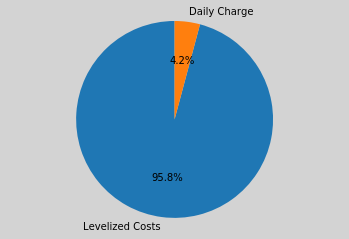

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[185, 155, 210, 31, 6, 51, 0.35, 0.8499999999999999, 0.25, 3198.72, 308.659, 140.202, 168.457, 0.0, {'Levelized Costs': 3065.662, 'Energy Charge': 0.01600000000013324, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60097009012, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (230, 205, 250, 16, 56, 31, 0.7499999999999998, 0.7499999999999998, 0.6499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 230
                                           a tilt of 16.0
                                           and a gcr of 0.750


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5879225730895996 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 205
                                           a tilt of 56.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4115750789642334 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 250
                                           a tilt of 31.0
                                           and a gcr of 0.650


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4162325859069824 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 143 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 103s


ERROR:ga_logger:panel relevance: [326.392, 0.0, 0.0]


ERROR:ga_logger:Cost: 3374.85


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,375 per year


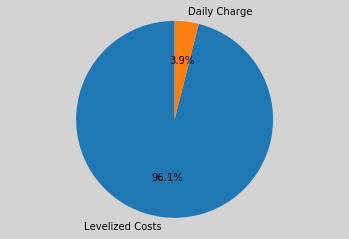

Total roof area of the  building: 599 m²
Total roof area used 435 m²
Percentage: 72.7%
[[230, 205, 250, 16, 56, 31, 0.7499999999999998, 0.7499999999999998, 0.6499999999999999, 3374.85, 326.392, 326.392, 0.0, 0.0, {'Levelized Costs': 3241.8, 'Energy Charge': 0.007999999999924512, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60199559491, 61845.7, 435.19]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (225, 95, 180, 21, 56, 56, 0.5999999999999999, 0.6499999999999999, 0.8499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 225
                                           a tilt of 21.0
                                           and a gcr of 0.600


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.158074855804443 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 95
                                           a tilt of 56.0
                                           and a gcr of 0.650


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.327934503555298 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 56.0
                                           and a gcr of 0.850


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2616302967071533 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 139 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 95s


ERROR:ga_logger:panel relevance: [317.021, 0.0, 0.0]


ERROR:ga_logger:Cost: 3281.77


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,282 per year


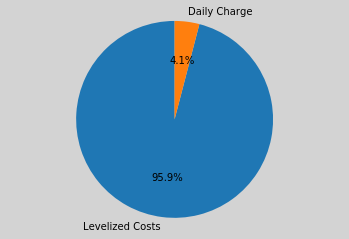

Total roof area of the  building: 599 m²
Total roof area used 528 m²
Percentage: 88.2%
[[225, 95, 180, 21, 56, 56, 0.5999999999999999, 0.6499999999999999, 0.8499999999999999, 3281.77, 317.021, 317.021, 0.0, 0.0, {'Levelized Costs': 3148.7119999999995, 'Energy Charge': 0.016000000000417458, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60410552236, 61845.7, 528.368]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (205, 130, 235, 1, 21, 21, 0.25, 0.8499999999999999, 0.49999999999999994)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 205
                                           a tilt of 1.0
                                           and a gcr of 0.250


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.4786629676818848 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 130
                                           a tilt of 21.0
                                           and a gcr of 0.850


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.231294631958008 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 235
                                           a tilt of 21.0
                                           and a gcr of 0.500


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8190407752990723 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 141 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 106s


ERROR:ga_logger:panel relevance: [0.0, 59.787, 264.212]


ERROR:ga_logger:Cost: 3351.08


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,351 per year


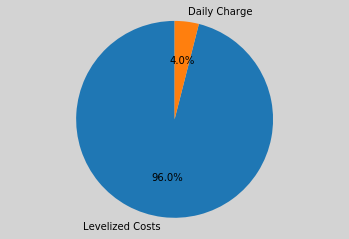

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[205, 130, 235, 1, 21, 21, 0.25, 0.8499999999999999, 0.49999999999999994, 3351.08, 323.99899999999997, 0.0, 59.787, 264.212, {'Levelized Costs': 3218.024, 'Energy Charge': 0.014000000000237378, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600205690884, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (135, 165, 190, 21, 6, 36, 0.2, 0.25, 0.8499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 135
                                           a tilt of 21.0
                                           and a gcr of 0.200


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5253078937530518 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 165
                                           a tilt of 6.0
                                           and a gcr of 0.250


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3490593433380127 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 190
                                           a tilt of 36.0
                                           and a gcr of 0.850


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.412107229232788 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 142 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 101s


ERROR:ga_logger:panel relevance: [58.8466, 0.0, 258.849]


ERROR:ga_logger:Cost: 3288.48


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,288 per year


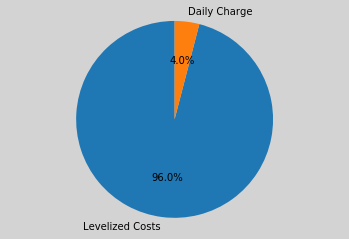

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[135, 165, 190, 21, 6, 36, 0.2, 0.25, 0.8499999999999999, 3288.48, 317.6956, 58.8466, 0.0, 258.849, {'Levelized Costs': 3155.4190000000003, 'Energy Charge': 0.01899999999989177, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60302730634, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (265, 235, 180, 46, 11, 31, 0.5499999999999999, 0.44999999999999996, 0.2)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 265
                                           a tilt of 46.0
                                           and a gcr of 0.550


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.486135959625244 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 235
                                           a tilt of 11.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3842804431915283 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 31.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.527089834213257 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 141 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 113s


ERROR:ga_logger:panel relevance: [0.0, 269.443, 0.0]


ERROR:ga_logger:Cost: 4107.67


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 45,561 kWh
At a cost of $ 0.0285 /kWh
Total Cost of the system: $ 4,108 per year


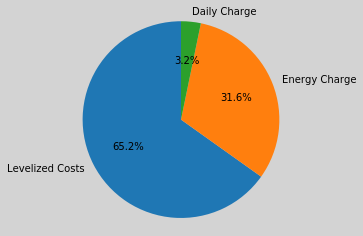

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[265, 235, 180, 46, 11, 31, 0.5499999999999999, 0.44999999999999996, 0.2, 4107.67, 269.443, 0.0, 269.443, 0.0, {'Levelized Costs': 2676.1654000000003, 'Energy Charge': 1298.4625999999998, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 51482.87427180376, 45561.1, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (200, 200, 245, 51, 11, 6, 0.7, 0.5999999999999999, 0.39999999999999997)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 200
                                           a tilt of 51.0
                                           and a gcr of 0.700


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5247867107391357 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 200
                                           a tilt of 11.0
                                           and a gcr of 0.600


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.455749273300171 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 6.0
                                           and a gcr of 0.400


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6891984939575195 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 140 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 95s


ERROR:ga_logger:panel relevance: [0.0, 313.137, 0.0]


ERROR:ga_logger:Cost: 3243.19


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,243 per year


Total roof area of the  building: 599 m²
Total roof area used 522 m²
Percentage: 87.2%
[[200, 200, 245, 51, 11, 6, 0.7, 0.5999999999999999, 0.39999999999999997, 3243.19, 313.137, 0.0, 313.137, 0.0, {'Levelized Costs': 3110.137, 'Energy Charge': 0.011000000000080945, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60149693702, 61845.7, 521.894]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (245, 235, 105, 51, 36, 41, 0.6499999999999999, 0.3, 0.5999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 245
                                           a tilt of 51.0
                                           and a gcr of 0.650


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.563767671585083 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 235
                                           a tilt of 36.0
                                           and a gcr of 0.300


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4041237831115723 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 105
                                           a tilt of 41.0
                                           and a gcr of 0.600


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3830666542053223 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 140 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 90s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 359.257]


ERROR:ga_logger:Cost: 4091.89


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0063 /kWh
Total Cost of the system: $ 4,092 per year


Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[245, 235, 105, 51, 36, 41, 0.6499999999999999, 0.3, 0.5999999999999999, 4091.89, 359.257, 0.0, 0.0, 359.257, {'Levelized Costs': 3568.2179999999994, 'Energy Charge': 390.63000000000034, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 58728.12887560003, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (135, 180, 215, 56, 36, 31, 0.8999999999999999, 0.35, 0.8499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 135
                                           a tilt of 56.0
                                           and a gcr of 0.900


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3956496715545654 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 36.0
                                           and a gcr of 0.350


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2846198081970215 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 215
                                           a tilt of 31.0
                                           and a gcr of 0.850


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2946932315826416 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 139 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 94s


ERROR:ga_logger:panel relevance: [0.0, 135.182, 180.648]


ERROR:ga_logger:Cost: 3269.95


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,270 per year


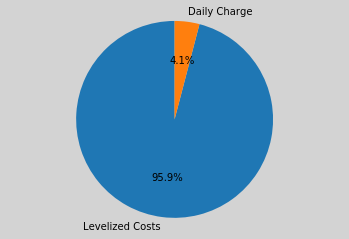

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[135, 180, 215, 56, 36, 31, 0.8999999999999999, 0.35, 0.8499999999999999, 3269.95, 315.83, 0.0, 135.182, 180.648, {'Levelized Costs': 3136.8999999999996, 'Energy Charge': 0.008000000000322416, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600056976036, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (160, 235, 220, 36, 1, 31, 0.8499999999999999, 0.25, 0.5999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 160
                                           a tilt of 36.0
                                           and a gcr of 0.850


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5702261924743652 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 235
                                           a tilt of 1.0
                                           and a gcr of 0.250


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.4510934352874756 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 220
                                           a tilt of 31.0
                                           and a gcr of 0.600


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3886494636535645 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 140 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 102s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 317.603]


ERROR:ga_logger:Cost: 3287.55


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,288 per year


Total roof area of the  building: 599 m²
Total roof area used 529 m²
Percentage: 88.4%
[[160, 235, 220, 36, 1, 31, 0.8499999999999999, 0.25, 0.5999999999999999, 3287.55, 317.603, 0.0, 0.0, 317.603, {'Levelized Costs': 3154.493, 'Energy Charge': 0.015000000000497948, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601081422676, 61845.7, 529.338]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (225, 245, 215, 1, 6, 51, 0.7499999999999998, 0.5499999999999999, 0.5499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 225
                                           a tilt of 1.0
                                           and a gcr of 0.750


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.507690191268921 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 245
                                           a tilt of 6.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2392070293426514 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 215
                                           a tilt of 51.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2708940505981445 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 138 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 98s


ERROR:ga_logger:panel relevance: [6.77261, 324.352, 0.0]


ERROR:ga_logger:Cost: 3421.86


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,422 per year


Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[225, 245, 215, 1, 6, 51, 0.7499999999999998, 0.5499999999999999, 0.5499999999999999, 3421.86, 331.12460999999996, 6.77261, 324.352, 0.0, {'Levelized Costs': 3288.795, 'Energy Charge': 0.023000000000138243, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59908405931, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (210, 100, 130, 16, 31, 56, 0.5999999999999999, 0.7499999999999998, 0.7499999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 210
                                           a tilt of 16.0
                                           and a gcr of 0.600


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5252373218536377 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 100
                                           a tilt of 31.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4259040355682373 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 130
                                           a tilt of 56.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.249837875366211 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 142 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 96s


ERROR:ga_logger:panel relevance: [310.825, 0.0, 0.0]


ERROR:ga_logger:Cost: 3220.23


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,220 per year


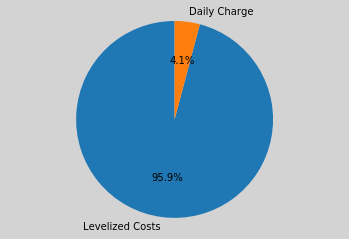

Total roof area of the  building: 599 m²
Total roof area used 518 m²
Percentage: 86.5%
[[210, 100, 130, 16, 31, 56, 0.5999999999999999, 0.7499999999999998, 0.7499999999999998, 3220.23, 310.825, 310.825, 0.0, 0.0, {'Levelized Costs': 3087.1769999999997, 'Energy Charge': 0.011000000000422006, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601083143614, 61845.7, 518.041]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (230, 250, 265, 26, 21, 6, 0.7, 0.3, 0.8499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 230
                                           a tilt of 26.0
                                           and a gcr of 0.700


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.444213628768921 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 250
                                           a tilt of 21.0
                                           and a gcr of 0.300


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8491740226745605 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 6.0
                                           and a gcr of 0.850


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.867258310317993 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 138 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 103s


ERROR:ga_logger:panel relevance: [329.867, 0.0, 0.0]


ERROR:ga_logger:Cost: 3409.36


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,409 per year


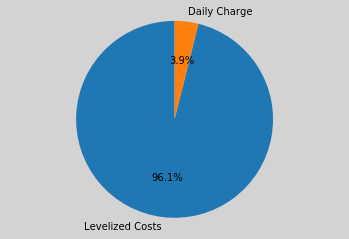

Total roof area of the  building: 599 m²
Total roof area used 471 m²
Percentage: 78.7%
[[230, 250, 265, 26, 21, 6, 0.7, 0.3, 0.8499999999999999, 3409.36, 329.867, 329.867, 0.0, 0.0, {'Levelized Costs': 3276.31, 'Energy Charge': 0.008000000000265572, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60217254681, 61845.7, 471.239]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (145, 180, 265, 1, 31, 11, 0.35, 0.44999999999999996, 0.39999999999999997)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 145
                                           a tilt of 1.0
                                           and a gcr of 0.350


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.505398988723755 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 31.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2424986362457275 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 11.0
                                           and a gcr of 0.400


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2490391731262207 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 141 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 93s


ERROR:ga_logger:panel relevance: [0.0, 269.443, 0.0]


ERROR:ga_logger:Cost: 3455.48


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0104 /kWh
Total Cost of the system: $ 3,455 per year


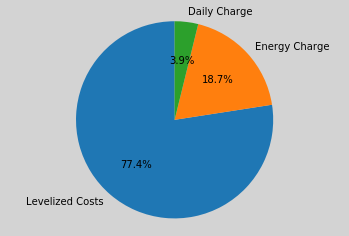

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[145, 180, 265, 1, 31, 11, 0.35, 0.44999999999999996, 0.39999999999999997, 3455.48, 269.443, 0.0, 269.443, 0.0, {'Levelized Costs': 2676.155, 'Energy Charge': 646.2830000000001, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 56687.84083910001, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (255, 190, 90, 26, 46, 36, 0.8499999999999999, 0.44999999999999996, 0.39999999999999997)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 255
                                           a tilt of 26.0
                                           and a gcr of 0.850


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5291059017181396 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 190
                                           a tilt of 46.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2678115367889404 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 36.0
                                           and a gcr of 0.400


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2749171257019043 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 144 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 107s


ERROR:ga_logger:panel relevance: [121.558, 205.088, 0.0]


ERROR:ga_logger:Cost: 3377.38


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,377 per year


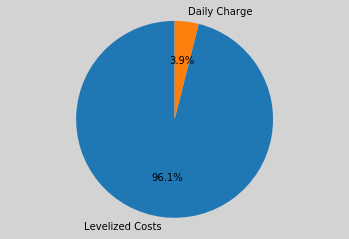

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[255, 190, 90, 26, 46, 36, 0.8499999999999999, 0.44999999999999996, 0.39999999999999997, 3377.38, 326.646, 121.558, 205.088, 0.0, {'Levelized Costs': 3244.325, 'Energy Charge': 0.013000000000261025, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60178097314, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (155, 180, 225, 46, 51, 26, 0.7499999999999998, 0.35, 0.7499999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 46.0
                                           and a gcr of 0.750


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3882720470428467 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 51.0
                                           and a gcr of 0.350


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2396726608276367 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 225
                                           a tilt of 26.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.316601037979126 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 139 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 105s


ERROR:ga_logger:panel relevance: [0.0, 112.77, 207.422]


ERROR:ga_logger:Cost: 3313.26


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,313 per year


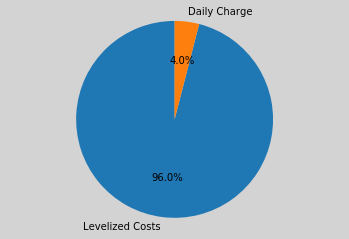

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[155, 180, 225, 46, 51, 26, 0.7499999999999998, 0.35, 0.7499999999999998, 3313.26, 320.192, 0.0, 112.77, 207.422, {'Levelized Costs': 3180.2100000000005, 'Energy Charge': 0.008000000000038199, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.603301434276, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (265, 245, 105, 51, 26, 41, 0.5499999999999999, 0.2, 0.8999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 265
                                           a tilt of 51.0
                                           and a gcr of 0.550


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.416498899459839 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 245
                                           a tilt of 26.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.28961443901062 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 105
                                           a tilt of 41.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2883822917938232 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 139 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 93s


ERROR:ga_logger:panel relevance: [0.0, 34.274, 384.652]


ERROR:ga_logger:Cost: 4293.92


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 4,294 per year


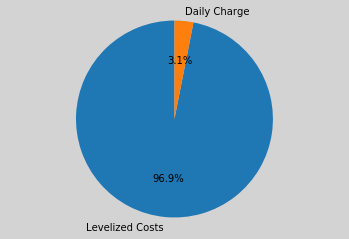

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[265, 245, 105, 51, 26, 41, 0.5499999999999999, 0.2, 0.8999999999999999, 4293.92, 418.926, 0.0, 34.274, 384.652, {'Levelized Costs': 4160.867, 'Energy Charge': 0.010999999999739885, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60169900006, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (95, 145, 170, 36, 51, 31, 0.7499999999999998, 0.6499999999999999, 0.7999999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 95
                                           a tilt of 36.0
                                           and a gcr of 0.750


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4011940956115723 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 145
                                           a tilt of 51.0
                                           and a gcr of 0.650


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2835912704467773 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 170
                                           a tilt of 31.0
                                           and a gcr of 0.800


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.280848503112793 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 139 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 93s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 314.312]


ERROR:ga_logger:Cost: 3254.87


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,255 per year


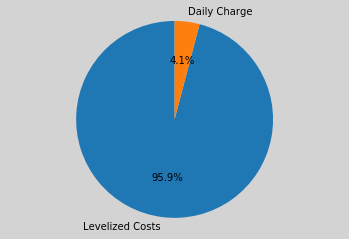

Total roof area of the  building: 599 m²
Total roof area used 393 m²
Percentage: 65.6%
[[95, 145, 170, 36, 51, 31, 0.7499999999999998, 0.6499999999999999, 0.7999999999999998, 3254.87, 314.312, 0.0, 0.0, 314.312, {'Levelized Costs': 3121.81, 'Energy Charge': 0.01800000000014279, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59897971143, 61845.7, 392.891]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (140, 200, 175, 36, 36, 26, 0.5499999999999999, 0.35, 0.5499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 140
                                           a tilt of 36.0
                                           and a gcr of 0.550


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4280807971954346 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 200
                                           a tilt of 36.0
                                           and a gcr of 0.350


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.260370969772339 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 26.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2612602710723877 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 138 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 100s


ERROR:ga_logger:panel relevance: [0.0, 55.7667, 241.686]


ERROR:ga_logger:Cost: 3087.41


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,087 per year


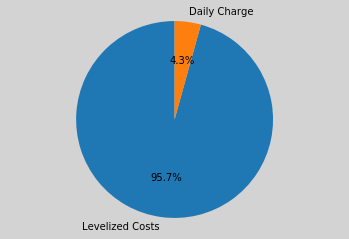

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[140, 200, 175, 36, 36, 26, 0.5499999999999999, 0.35, 0.5499999999999999, 3087.41, 297.4527, 0.0, 55.7667, 241.686, {'Levelized Costs': 2954.348, 'Energy Charge': 0.019999999999868123, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60176491337, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (230, 210, 255, 51, 21, 41, 0.8499999999999999, 0.7, 0.49999999999999994)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 230
                                           a tilt of 51.0
                                           and a gcr of 0.850


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.541480779647827 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 210
                                           a tilt of 21.0
                                           and a gcr of 0.700


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8145594596862793 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 255
                                           a tilt of 41.0
                                           and a gcr of 0.500


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3397796154022217 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 139 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 99s


ERROR:ga_logger:panel relevance: [0.0, 312.935, 0.0]


ERROR:ga_logger:Cost: 3241.19


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,241 per year


Total roof area of the  building: 599 m²
Total roof area used 447 m²
Percentage: 74.7%
[[230, 210, 255, 51, 21, 41, 0.8499999999999999, 0.7, 0.49999999999999994, 3241.19, 312.935, 0.0, 312.935, 0.0, {'Levelized Costs': 3108.138, 'Energy Charge': 0.010000000000104592, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602141969444, 61845.7, 447.049]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (90, 255, 220, 56, 41, 6, 0.5499999999999999, 0.7, 0.7)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 56.0
                                           and a gcr of 0.550


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3988850116729736 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 255
                                           a tilt of 41.0
                                           and a gcr of 0.700


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.283182144165039 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 220
                                           a tilt of 6.0
                                           and a gcr of 0.700


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4909074306488037 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 138 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 90s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 325.371]


ERROR:ga_logger:Cost: 3364.7


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,365 per year


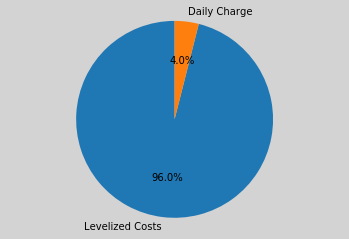

Total roof area of the  building: 599 m²
Total roof area used 465 m²
Percentage: 77.6%
[[90, 255, 220, 56, 41, 6, 0.5499999999999999, 0.7, 0.7, 3364.7, 325.371, 0.0, 0.0, 325.371, {'Levelized Costs': 3231.6459999999997, 'Energy Charge': 0.012000000000057298, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60253124553, 61845.7, 464.815]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (120, 220, 135, 1, 36, 6, 0.2, 0.7, 0.39999999999999997)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 120
                                           a tilt of 1.0
                                           and a gcr of 0.200


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.52479887008667 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 220
                                           a tilt of 36.0
                                           and a gcr of 0.700


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.285189390182495 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 135
                                           a tilt of 6.0
                                           and a gcr of 0.400


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.245476007461548 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 139 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 100s


ERROR:ga_logger:panel relevance: [0.0, 206.463, 121.526]


ERROR:ga_logger:Cost: 3390.71


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,391 per year


Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[120, 220, 135, 1, 36, 6, 0.2, 0.7, 0.39999999999999997, 3390.71, 327.989, 0.0, 206.463, 121.526, {'Levelized Costs': 3257.6470000000004, 'Energy Charge': 0.02099999999990132, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60056249608, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (155, 135, 240, 41, 6, 1, 0.49999999999999994, 0.39999999999999997, 0.8499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 41.0
                                           and a gcr of 0.500


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5155835151672363 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 135
                                           a tilt of 6.0
                                           and a gcr of 0.400


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.229901075363159 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 240
                                           a tilt of 1.0
                                           and a gcr of 0.850


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.310873508453369 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 140 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 97s


ERROR:ga_logger:panel relevance: [285.788, 0.0, 23.1085]


ERROR:ga_logger:Cost: 3201.07


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,201 per year


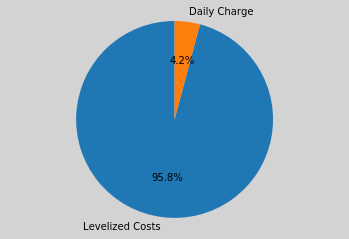

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[155, 135, 240, 41, 6, 1, 0.49999999999999994, 0.39999999999999997, 0.8499999999999999, 3201.07, 308.8965, 285.788, 0.0, 23.1085, {'Levelized Costs': 3068.015, 'Energy Charge': 0.013000000000147338, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602848539755, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (185, 140, 150, 56, 51, 6, 0.8499999999999999, 0.5999999999999999, 0.2)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 56.0
                                           and a gcr of 0.850


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.380091905593872 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 140
                                           a tilt of 51.0
                                           and a gcr of 0.600


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.25010085105896 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 6.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2385542392730713 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 138 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 94s


ERROR:ga_logger:panel relevance: [287.355, 0.0, 52.1393]


ERROR:ga_logger:Cost: 3504.98


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,505 per year


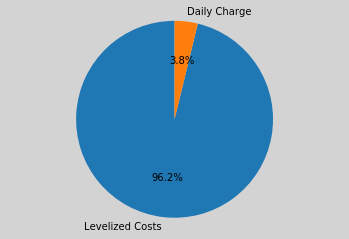

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[185, 140, 150, 56, 51, 6, 0.8499999999999999, 0.5999999999999999, 0.2, 3504.98, 339.4943, 287.355, 0.0, 52.1393, {'Levelized Costs': 3371.9249999999997, 'Energy Charge': 0.013000000000431555, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60003900577, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (200, 205, 125, 21, 51, 6, 0.39999999999999997, 0.8499999999999999, 0.8499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 200
                                           a tilt of 21.0
                                           and a gcr of 0.400


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.9105424880981445 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 205
                                           a tilt of 51.0
                                           and a gcr of 0.850


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.376965284347534 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 125
                                           a tilt of 6.0
                                           and a gcr of 0.850


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2061755657196045 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 139 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 98s


ERROR:ga_logger:panel relevance: [174.429, 0.0, 138.286]


ERROR:ga_logger:Cost: 3239.0


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,239 per year


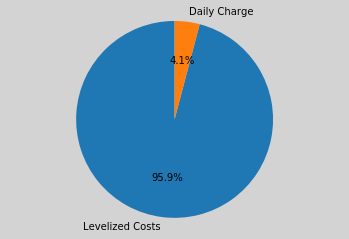

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[200, 205, 125, 21, 51, 6, 0.39999999999999997, 0.8499999999999999, 0.8499999999999999, 3239.0, 312.71500000000003, 174.429, 0.0, 138.286, {'Levelized Costs': 3105.9460000000004, 'Energy Charge': 0.011999999999943611, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59960866963, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (90, 155, 120, 56, 31, 1, 0.5999999999999999, 0.8999999999999999, 0.44999999999999996)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 56.0
                                           and a gcr of 0.600


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.424166440963745 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 155
                                           a tilt of 31.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.265850782394409 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 120
                                           a tilt of 1.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.342799663543701 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 138 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 94s


ERROR:ga_logger:panel relevance: [0.0, 333.23, 0.0]


ERROR:ga_logger:Cost: 3442.77


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,443 per year


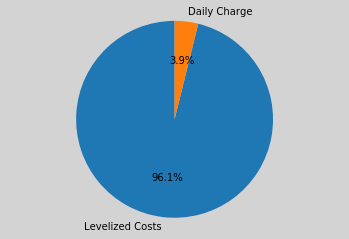

Total roof area of the  building: 599 m²
Total roof area used 370 m²
Percentage: 61.8%
[[90, 155, 120, 56, 31, 1, 0.5999999999999999, 0.8999999999999999, 0.44999999999999996, 3442.77, 333.23, 0.0, 333.23, 0.0, {'Levelized Costs': 3309.7119999999995, 'Energy Charge': 0.016000000000360615, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60322945976, 61845.7, 370.256]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (125, 220, 110, 11, 21, 21, 0.5499999999999999, 0.2, 0.44999999999999996)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 125
                                           a tilt of 11.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3886466026306152 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 220
                                           a tilt of 21.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7713332176208496 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 110
                                           a tilt of 21.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.219930648803711 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 138 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 96s


ERROR:ga_logger:panel relevance: [316.112, 4.80266, 0.0]


ERROR:ga_logger:Cost: 3320.44


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,320 per year


Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[125, 220, 110, 11, 21, 21, 0.5499999999999999, 0.2, 0.44999999999999996, 3320.44, 320.91466, 316.112, 4.80266, 0.0, {'Levelized Costs': 3187.384, 'Energy Charge': 0.014000000000010004, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60162378013, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (215, 155, 100, 46, 36, 46, 0.8499999999999999, 0.5499999999999999, 0.5999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 215
                                           a tilt of 46.0
                                           and a gcr of 0.850


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.383329391479492 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 155
                                           a tilt of 36.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2512366771698 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 100
                                           a tilt of 46.0
                                           and a gcr of 0.600

ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.211852788925171 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 137 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 94s


ERROR:ga_logger:panel relevance: [0.0, 305.876, 0.0]


ERROR:ga_logger:Cost: 3171.08


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,171 per year


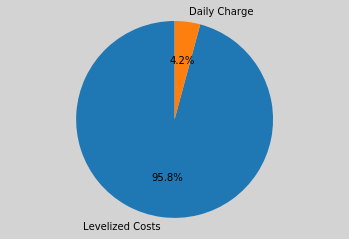

Total roof area of the  building: 599 m²
Total roof area used 556 m²
Percentage: 92.9%
[[215, 155, 100, 46, 36, 46, 0.8499999999999999, 0.5499999999999999, 0.5999999999999999, 3171.08, 305.876, 0.0, 305.876, 0.0, {'Levelized Costs': 3038.0229999999997, 'Energy Charge': 0.015000000000213731, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600876249846, 61845.7, 556.138]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (180, 100, 170, 31, 1, 26, 0.5499999999999999, 0.39999999999999997, 0.5999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 31.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.345113515853882 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 100
                                           a tilt of 1.0
                                           and a gcr of 0.400


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.298417568206787 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 170
                                           a tilt of 26.0
                                           and a gcr of 0.600


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2076714038848877 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 138 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 97s


ERROR:ga_logger:panel relevance: [297.143, 0.0, 0.0]


ERROR:ga_logger:Cost: 3084.35


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,084 per year


Total roof area of the  building: 599 m²
Total roof area used 540 m²
Percentage: 90.2%
[[180, 100, 170, 31, 1, 26, 0.5499999999999999, 0.39999999999999997, 0.5999999999999999, 3084.35, 297.143, 297.143, 0.0, 0.0, {'Levelized Costs': 2951.297, 'Energy Charge': 0.011000000000137788, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60040680011, 61845.7, 540.261]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (90, 175, 210, 56, 36, 36, 0.7999999999999998, 0.3, 0.6499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 56.0
                                           and a gcr of 0.800


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4919588565826416 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 36.0
                                           and a gcr of 0.300


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.353044033050537 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 210
                                           a tilt of 36.0
                                           and a gcr of 0.650


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2328641414642334 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 138 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 97s


ERROR:ga_logger:panel relevance: [0.0, 67.0538, 243.912]


ERROR:ga_logger:Cost: 3221.63


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,222 per year


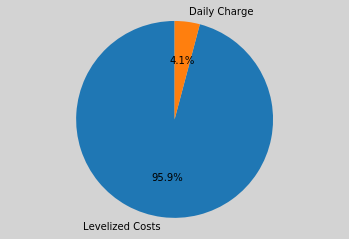

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[90, 175, 210, 56, 36, 36, 0.7999999999999998, 0.3, 0.6499999999999999, 3221.63, 310.9658, 0.0, 67.0538, 243.912, {'Levelized Costs': 3088.573, 'Energy Charge': 0.015000000000100044, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59984377291, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (90, 155, 265, 1, 26, 36, 0.7499999999999998, 0.2, 0.7999999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 1.0
                                           and a gcr of 0.750


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.5558652877807617 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 155
                                           a tilt of 26.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.342151403427124 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 36.0
                                           and a gcr of 0.800


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3415184020996094 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 147 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 99s


ERROR:ga_logger:panel relevance: [286.423, 43.3728, 0.0]


ERROR:ga_logger:Cost: 3408.66


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,409 per year


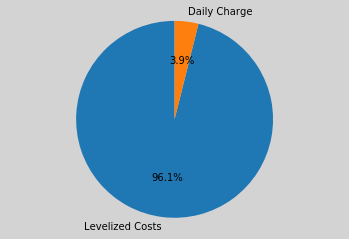

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[90, 155, 265, 1, 26, 36, 0.7499999999999998, 0.2, 0.7999999999999998, 3408.66, 329.7958, 286.423, 43.3728, 0.0, {'Levelized Costs': 3275.5989999999997, 'Energy Charge': 0.01900000000023283, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600792824065, 61845.7, 598.762]]


ERROR:optimizer_logger:100


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (180, 230, 105, 46, 56, 21, 0.6499999999999999, 0.5999999999999999, 0.7499999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 46.0
                                           and a gcr of 0.650


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.489877223968506 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 230
                                           a tilt of 56.0
                                           and a gcr of 0.600


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2157466411590576 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 105
                                           a tilt of 21.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.224388599395752 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 143 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 105s


ERROR:ga_logger:panel relevance: [312.46, 0.0, 0.0]


ERROR:ga_logger:Cost: 3236.47


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,236 per year


Total roof area of the  building: 599 m²
Total roof area used 481 m²
Percentage: 80.3%
[[180, 230, 105, 46, 56, 21, 0.6499999999999999, 0.5999999999999999, 0.7499999999999998, 3236.47, 312.46, 312.46, 0.0, 0.0, {'Levelized Costs': 3103.4139999999998, 'Energy Charge': 0.014000000000294222, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60050189987, 61845.7, 480.707]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (100, 195, 100, 41, 21, 56, 0.5499999999999999, 0.3, 0.44999999999999996)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 100
                                           a tilt of 41.0
                                           and a gcr of 0.550


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3435025215148926 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 195
                                           a tilt of 21.0
                                           and a gcr of 0.300


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7953102588653564 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 100
                                           a tilt of 56.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.224748134613037 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 140 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [329.319, 0.0, 0.0]


ERROR:ga_logger:Cost: 4471.23


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0173 /kWh
Total Cost of the system: $ 4,471 per year


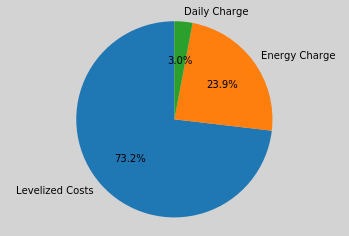

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[100, 195, 100, 41, 21, 56, 0.5499999999999999, 0.3, 0.44999999999999996, 4471.23, 329.319, 329.319, 0.0, 0.0, {'Levelized Costs': 3270.8659999999995, 'Energy Charge': 1067.3220000000001, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 53327.56504470008, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (205, 105, 170, 26, 16, 46, 0.7, 0.3, 0.7999999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 205
                                           a tilt of 26.0
                                           and a gcr of 0.700


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5557751655578613 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 105
                                           a tilt of 16.0
                                           and a gcr of 0.300


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2569198608398438 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 170
                                           a tilt of 46.0
                                           and a gcr of 0.800


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2518999576568604 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 139 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 99s


ERROR:ga_logger:panel relevance: [311.004, 0.0, 0.0]


ERROR:ga_logger:Cost: 3222.01


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,222 per year


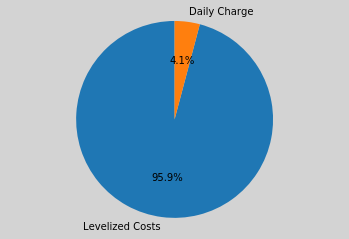

Total roof area of the  building: 599 m²
Total roof area used 444 m²
Percentage: 74.2%
[[205, 105, 170, 26, 16, 46, 0.7, 0.3, 0.7999999999999998, 3222.01, 311.004, 311.004, 0.0, 0.0, {'Levelized Costs': 3088.9519999999998, 'Energy Charge': 0.01600000000030377, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.599927060925, 61845.7, 444.292]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (265, 105, 150, 6, 11, 51, 0.7999999999999998, 0.7499999999999998, 0.6499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 265
                                           a tilt of 6.0
                                           and a gcr of 0.800


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.526747226715088 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 105
                                           a tilt of 11.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3274824619293213 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 51.0
                                           and a gcr of 0.650


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.373020887374878 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 143 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 101s


ERROR:ga_logger:panel relevance: [0.0, 335.191, 0.0]


ERROR:ga_logger:Cost: 3462.25


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,462 per year


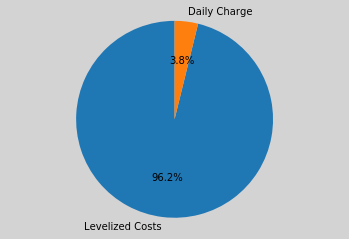

Total roof area of the  building: 599 m²
Total roof area used 447 m²
Percentage: 74.6%
[[265, 105, 150, 6, 11, 51, 0.7999999999999998, 0.7499999999999998, 0.6499999999999999, 3462.25, 335.191, 0.0, 335.191, 0.0, {'Levelized Costs': 3329.1879999999996, 'Energy Charge': 0.02000000000032287, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602848689945, 61845.7, 446.922]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (265, 265, 235, 46, 36, 16, 0.25, 0.2, 0.44999999999999996)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 265
                                           a tilt of 46.0
                                           and a gcr of 0.250


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4175522327423096 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 36.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2860267162323 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 235
                                           a tilt of 16.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.226440906524658 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 138 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 88s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 269.443]


ERROR:ga_logger:Cost: 4053.08


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0201 /kWh
Total Cost of the system: $ 4,053 per year


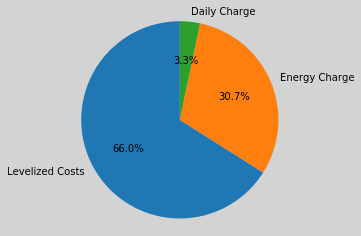

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[265, 265, 235, 46, 36, 16, 0.25, 0.2, 0.44999999999999996, 4053.08, 269.443, 0.0, 0.0, 269.443, {'Levelized Costs': 2676.1569999999997, 'Energy Charge': 1243.8810000000003, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 51918.47685804506, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (220, 185, 250, 16, 31, 46, 0.7, 0.7499999999999998, 0.35)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 220
                                           a tilt of 16.0
                                           and a gcr of 0.700


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.433297872543335 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 31.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5010077953338623 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 250
                                           a tilt of 46.0
                                           and a gcr of 0.350


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.317265510559082 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 139 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 105s


ERROR:ga_logger:panel relevance: [0.0, 307.218, 0.0]


ERROR:ga_logger:Cost: 3184.41


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,184 per year


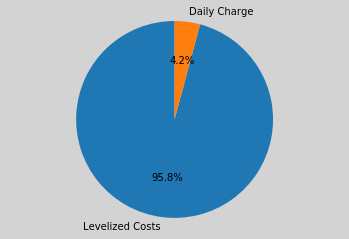

Total roof area of the  building: 599 m²
Total roof area used 410 m²
Percentage: 68.4%
[[220, 185, 250, 16, 31, 46, 0.7, 0.7499999999999998, 0.35, 3184.41, 307.218, 0.0, 307.218, 0.0, {'Levelized Costs': 3051.3569999999995, 'Energy Charge': 0.011000000000308319, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60006475756, 61845.7, 409.624]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (155, 230, 135, 21, 21, 36, 0.7499999999999998, 0.8499999999999999, 0.49999999999999994)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 21.0
                                           and a gcr of 0.750


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3895914554595947 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 230
                                           a tilt of 21.0
                                           and a gcr of 0.850


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8319902420043945 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 135
                                           a tilt of 36.0
                                           and a gcr of 0.500


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.249844551086426 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 139 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 115s


ERROR:ga_logger:panel relevance: [313.058, 0.0, 0.0]


ERROR:ga_logger:Cost: 3242.41


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,242 per year


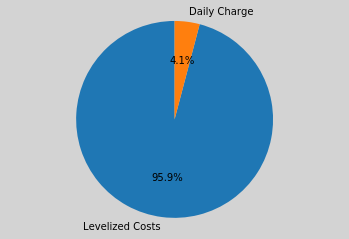

Total roof area of the  building: 599 m²
Total roof area used 417 m²
Percentage: 69.7%
[[155, 230, 135, 21, 21, 36, 0.7499999999999998, 0.8499999999999999, 0.49999999999999994, 3242.41, 313.058, 313.058, 0.0, 0.0, {'Levelized Costs': 3109.3519999999994, 'Energy Charge': 0.016000000000360615, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600832300086, 61845.7, 417.411]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (135, 255, 195, 1, 36, 6, 0.7999999999999998, 0.2, 0.8499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 135
                                           a tilt of 1.0
                                           and a gcr of 0.800


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.478287696838379 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 255
                                           a tilt of 36.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.309370279312134 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 195
                                           a tilt of 6.0
                                           and a gcr of 0.850


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.855026960372925 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 139 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 100s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 323.378]


ERROR:ga_logger:Cost: 3344.91


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,345 per year


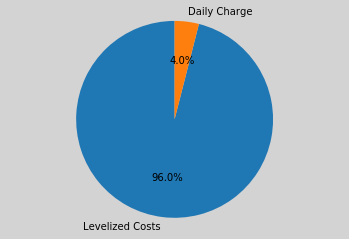

Total roof area of the  building: 599 m²
Total roof area used 380 m²
Percentage: 63.5%
[[135, 255, 195, 1, 36, 6, 0.7999999999999998, 0.2, 0.8499999999999999, 3344.91, 323.378, 0.0, 0.0, 323.378, {'Levelized Costs': 3211.854, 'Energy Charge': 0.014000000000351065, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60389393828, 61845.7, 380.445]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (250, 235, 175, 36, 31, 26, 0.7499999999999998, 0.35, 0.8999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 250
                                           a tilt of 36.0
                                           and a gcr of 0.750


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4349331855773926 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 235
                                           a tilt of 31.0
                                           and a gcr of 0.350


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.277743101119995 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 26.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.394536256790161 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 137 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 98s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 320.382]


ERROR:ga_logger:Cost: 3315.15


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,315 per year


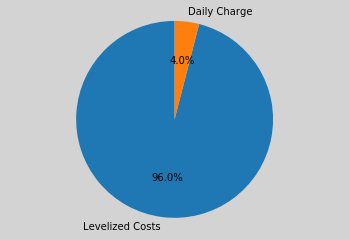

Total roof area of the  building: 599 m²
Total roof area used 356 m²
Percentage: 59.5%
[[250, 235, 175, 36, 31, 26, 0.7499999999999998, 0.35, 0.8999999999999999, 3315.15, 320.382, 0.0, 0.0, 320.382, {'Levelized Costs': 3182.098, 'Energy Charge': 0.010000000000331966, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60166568118, 61845.7, 355.98]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (230, 240, 120, 36, 26, 41, 0.49999999999999994, 0.25, 0.7499999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 230
                                           a tilt of 36.0
                                           and a gcr of 0.500


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.879960060119629 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 240
                                           a tilt of 26.0
                                           and a gcr of 0.250


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6518335342407227 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 120
                                           a tilt of 41.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.759995698928833 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 143 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 105s


ERROR:ga_logger:panel relevance: [216.92, 0.0, 123.691]


ERROR:ga_logger:Cost: 3516.08


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,516 per year


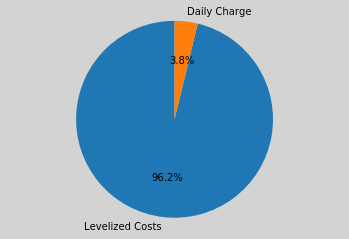

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[230, 240, 120, 36, 26, 41, 0.49999999999999994, 0.25, 0.7499999999999998, 3516.08, 340.611, 216.92, 0.0, 123.691, {'Levelized Costs': 3383.025, 'Energy Charge': 0.012999999999919964, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.605155459925, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (190, 185, 115, 16, 1, 51, 0.8999999999999999, 0.7499999999999998, 0.5499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 190
                                           a tilt of 16.0
                                           and a gcr of 0.900


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6017441749572754 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 1.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.5287859439849854 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 115
                                           a tilt of 51.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.458528757095337 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 140 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 102s


ERROR:ga_logger:panel relevance: [320.167, 0.0, 0.0]


ERROR:ga_logger:Cost: 3313.02


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,313 per year


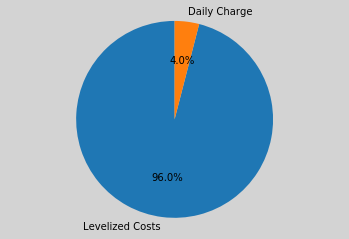

Total roof area of the  building: 599 m²
Total roof area used 356 m²
Percentage: 59.4%
[[190, 185, 115, 16, 1, 51, 0.8999999999999999, 0.7499999999999998, 0.5499999999999999, 3313.02, 320.167, 320.167, 0.0, 0.0, {'Levelized Costs': 3179.964, 'Energy Charge': 0.014000000000123691, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60073000774, 61845.7, 355.741]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (185, 115, 220, 26, 6, 21, 0.39999999999999997, 0.5499999999999999, 0.44999999999999996)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 26.0
                                           and a gcr of 0.400


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.07365345954895 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 115
                                           a tilt of 6.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8339335918426514 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 220
                                           a tilt of 21.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.4959423542022705 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 170 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 114s


ERROR:ga_logger:panel relevance: [3.76642, 324.14, 0.0]


ERROR:ga_logger:Cost: 3389.89


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,390 per year


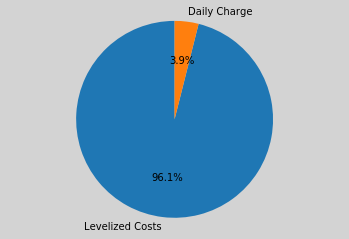

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[185, 115, 220, 26, 6, 21, 0.39999999999999997, 0.5499999999999999, 0.44999999999999996, 3389.89, 327.90641999999997, 3.76642, 324.14, 0.0, {'Levelized Costs': 3256.8269999999998, 'Energy Charge': 0.021000000000299224, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60067781948, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (140, 230, 145, 51, 46, 16, 0.7, 0.5499999999999999, 0.8499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 140
                                           a tilt of 51.0
                                           and a gcr of 0.700


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.129799127578735 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 230
                                           a tilt of 46.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.936765193939209 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 145
                                           a tilt of 16.0
                                           and a gcr of 0.850


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8441975116729736 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 154 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 106s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 324.324]


ERROR:ga_logger:Cost: 3354.31


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,354 per year


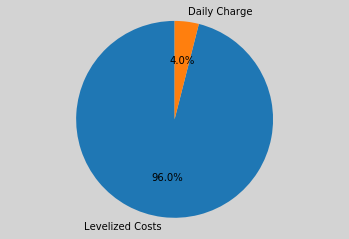

Total roof area of the  building: 599 m²
Total roof area used 382 m²
Percentage: 63.7%
[[140, 230, 145, 51, 46, 16, 0.7, 0.5499999999999999, 0.8499999999999999, 3354.31, 324.324, 0.0, 0.0, 324.324, {'Levelized Costs': 3221.2499999999995, 'Energy Charge': 0.018000000000256478, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60214327918, 61845.7, 381.558]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (265, 240, 245, 21, 11, 21, 0.6499999999999999, 0.6499999999999999, 0.44999999999999996)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 265
                                           a tilt of 21.0
                                           and a gcr of 0.650


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.61454439163208 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 240
                                           a tilt of 11.0
                                           and a gcr of 0.650


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.362446546554565 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 21.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.591443300247192 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  17 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 148 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 105s


ERROR:ga_logger:panel relevance: [0.0, 327.586, 0.0]


ERROR:ga_logger:Cost: 3386.71


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,387 per year


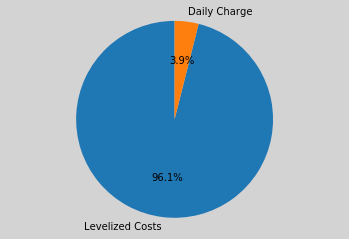

Total roof area of the  building: 599 m²
Total roof area used 504 m²
Percentage: 84.2%
[[265, 240, 245, 21, 11, 21, 0.6499999999999999, 0.6499999999999999, 0.44999999999999996, 3386.71, 327.586, 0.0, 327.586, 0.0, {'Levelized Costs': 3253.645, 'Energy Charge': 0.02300000000025193, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60426262315, 61845.7, 503.979]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (240, 245, 255, 1, 36, 6, 0.7, 0.5499999999999999, 0.5999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 240
                                           a tilt of 1.0
                                           and a gcr of 0.700


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.891784906387329 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 245
                                           a tilt of 36.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7613015174865723 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 255
                                           a tilt of 6.0
                                           and a gcr of 0.600


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.873607873916626 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 146 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 108s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 334.037]


ERROR:ga_logger:Cost: 3450.78


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,451 per year


Total roof area of the  building: 599 m²
Total roof area used 557 m²
Percentage: 93.0%
[[240, 245, 255, 1, 36, 6, 0.7, 0.5499999999999999, 0.5999999999999999, 3450.78, 334.037, 0.0, 0.0, 334.037, {'Levelized Costs': 3317.724, 'Energy Charge': 0.014000000000010004, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60354497289, 61845.7, 556.728]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (195, 175, 90, 46, 16, 21, 0.7499999999999998, 0.7499999999999998, 0.5999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 195
                                           a tilt of 46.0
                                           and a gcr of 0.750


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.073251962661743 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 16.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7780866622924805 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 21.0
                                           and a gcr of 0.600


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.98638916015625 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 151 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 107s


ERROR:ga_logger:panel relevance: [0.0, 309.717, 0.0]


ERROR:ga_logger:Cost: 3209.23


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,209 per year


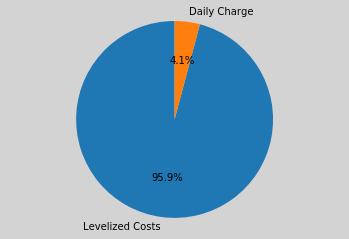

Total roof area of the  building: 599 m²
Total roof area used 413 m²
Percentage: 69.0%
[[195, 175, 90, 46, 16, 21, 0.7499999999999998, 0.7499999999999998, 0.5999999999999999, 3209.23, 309.717, 0.0, 309.717, 0.0, {'Levelized Costs': 3076.168, 'Energy Charge': 0.020000000000095497, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60118609228, 61845.7, 412.956]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh


This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (125, 225, 200, 36, 6, 11, 0.35, 0.44999999999999996, 0.7)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 125
                                           a tilt of 36.0
                                           and a gcr of 0.350


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.152648687362671 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 225
                                           a tilt of 6.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.190312623977661 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 200
                                           a tilt of 11.0
                                           and a gcr of 0.700


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.208745002746582 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  16 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 161 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 114s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 314.465]


ERROR:ga_logger:Cost: 3256.39


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,256 per year


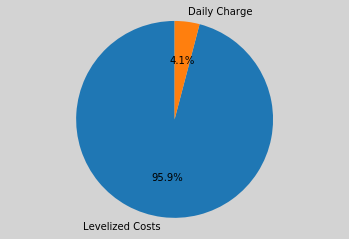

Total roof area of the  building: 599 m²
Total roof area used 449 m²
Percentage: 75.0%
[[125, 225, 200, 36, 6, 11, 0.35, 0.44999999999999996, 0.7, 3256.39, 314.465, 0.0, 0.0, 314.465, {'Levelized Costs': 3123.334, 'Energy Charge': 0.014000000000010004, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60182944656, 61845.7, 449.236]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (190, 110, 210, 1, 36, 11, 0.8499999999999999, 0.8499999999999999, 0.8499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 190
                                           a tilt of 1.0
                                           and a gcr of 0.850


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.041874647140503 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 110
                                           a tilt of 36.0
                                           and a gcr of 0.850


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7477619647979736 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 210
                                           a tilt of 11.0
                                           and a gcr of 0.850


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.119751214981079 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 145 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 110s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 322.77]


ERROR:ga_logger:Cost: 3338.87


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,339 per year


Total roof area of the  building: 599 m²
Total roof area used 380 m²
Percentage: 63.4%
[[190, 110, 210, 1, 36, 11, 0.8499999999999999, 0.8499999999999999, 0.8499999999999999, 3338.87, 322.77, 0.0, 0.0, 322.77, {'Levelized Costs': 3205.805, 'Energy Charge': 0.02300000000025193, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.599181495076, 61845.7, 379.729]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (220, 160, 145, 36, 36, 16, 0.7999999999999998, 0.7499999999999998, 0.49999999999999994)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 220
                                           a tilt of 36.0
                                           and a gcr of 0.800


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.76517653465271 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 160
                                           a tilt of 36.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7003443241119385 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 145
                                           a tilt of 16.0
                                           and a gcr of 0.500


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.502572536468506 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 146 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 108s


ERROR:ga_logger:panel relevance: [0.0, 31.2143, 278.571]


ERROR:ga_logger:Cost: 3209.91


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,210 per year


Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[220, 160, 145, 36, 36, 16, 0.7999999999999998, 0.7499999999999998, 0.49999999999999994, 3209.91, 309.7853, 0.0, 31.2143, 278.571, {'Levelized Costs': 3076.854, 'Energy Charge': 0.014000000000294222, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60308436403, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (255, 150, 265, 16, 51, 46, 0.5999999999999999, 0.6499999999999999, 0.5499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 255
                                           a tilt of 16.0
                                           and a gcr of 0.600


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.056678771972656 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 150
                                           a tilt of 51.0
                                           and a gcr of 0.650


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8622920513153076 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 46.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.886971950531006 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 169 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 111s


ERROR:ga_logger:panel relevance: [0.0, 337.21, 0.0]


ERROR:ga_logger:Cost: 3482.29


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,482 per year


Total roof area of the  building: 599 m²
Total roof area used 519 m²
Percentage: 86.6%
[[255, 150, 265, 16, 51, 46, 0.5999999999999999, 0.6499999999999999, 0.5499999999999999, 3482.29, 337.21, 0.0, 337.21, 0.0, {'Levelized Costs': 3349.236, 'Energy Charge': 0.012000000000341515, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60209101002, 61845.7, 518.784]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (190, 260, 175, 31, 36, 6, 0.6499999999999999, 0.5499999999999999, 0.7499999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 190
                                           a tilt of 31.0
                                           and a gcr of 0.650


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.862638473510742 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 260
                                           a tilt of 36.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7430803775787354 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 6.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.715834617614746 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 144 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 109s


ERROR:ga_logger:panel relevance: [302.462, 0.0, 0.0]


ERROR:ga_logger:Cost: 3137.17


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,137 per year


Total roof area of the  building: 599 m²
Total roof area used 465 m²
Percentage: 77.7%
[[190, 260, 175, 31, 36, 6, 0.6499999999999999, 0.5499999999999999, 0.7499999999999998, 3137.17, 302.462, 302.462, 0.0, 0.0, {'Levelized Costs': 3004.118, 'Energy Charge': 0.010000000000275122, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602865437795, 61845.7, 465.327]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (185, 205, 160, 21, 16, 1, 0.39999999999999997, 0.35, 0.35)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 21.0
                                           and a gcr of 0.400


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.399646043777466 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 205
                                           a tilt of 16.0
                                           and a gcr of 0.350


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.99342942237854 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 160
                                           a tilt of 1.0
                                           and a gcr of 0.350


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7894632816314697 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 158 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 104s


ERROR:ga_logger:panel relevance: [239.505, 0.0, 0.0]


ERROR:ga_logger:Cost: 4015.14


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0243 /kWh
Total Cost of the system: $ 4,015 per year


Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[185, 205, 160, 21, 16, 1, 0.39999999999999997, 0.35, 0.35, 4015.14, 239.505, 239.505, 0.0, 0.0, {'Levelized Costs': 2378.8109999999997, 'Energy Charge': 1503.2870000000003, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 49848.22482043715, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (180, 195, 265, 16, 26, 11, 0.7999999999999998, 0.25, 0.7499999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 16.0
                                           and a gcr of 0.800


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.677499771118164 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 195
                                           a tilt of 26.0
                                           and a gcr of 0.250


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7766902446746826 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 11.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.497671127319336 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 143 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 109s


ERROR:ga_logger:panel relevance: [229.304, 78.033, 0.0]


ERROR:ga_logger:Cost: 3185.59


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,186 per year


Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[180, 195, 265, 16, 26, 11, 0.7999999999999998, 0.25, 0.7499999999999998, 3185.59, 307.337, 229.304, 78.033, 0.0, {'Levelized Costs': 3052.531, 'Energy Charge': 0.017000000000109594, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60166661028, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (265, 180, 235, 26, 36, 11, 0.25, 0.2, 0.2)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 265
                                           a tilt of 26.0
                                           and a gcr of 0.250


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7056329250335693 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 36.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4913694858551025 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 235
                                           a tilt of 11.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6101460456848145 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 144 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 103s


ERROR:ga_logger:panel relevance: [0.0, 119.752, 0.0]


ERROR:ga_logger:Cost: 5865.62


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0735 /kWh
Total Cost of the system: $ 5,866 per year


Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[265, 180, 235, 26, 36, 11, 0.25, 0.2, 0.2, 5865.62, 119.752, 0.0, 119.752, 0.0, {'Levelized Costs': 1189.4101999999998, 'Energy Charge': 4543.1678, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 25587.387818200037, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (180, 220, 230, 31, 56, 26, 0.35, 0.6499999999999999, 0.7999999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 31.0
                                           and a gcr of 0.350


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6406729221343994 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 220
                                           a tilt of 56.0
                                           and a gcr of 0.650


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.516247034072876 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 230
                                           a tilt of 26.0
                                           and a gcr of 0.800


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5673987865448 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 150 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 109s


ERROR:ga_logger:panel relevance: [124.241, 0.0, 195.03]


ERROR:ga_logger:Cost: 3304.12


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,304 per year


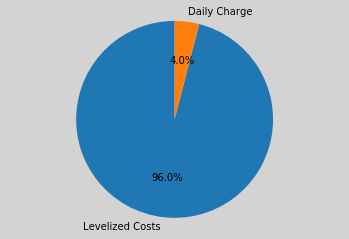

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[180, 220, 230, 31, 56, 26, 0.35, 0.6499999999999999, 0.7999999999999998, 3304.12, 319.271, 124.241, 0.0, 195.03, {'Levelized Costs': 3171.0509999999995, 'Energy Charge': 0.027000000000327873, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60077520528, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (160, 185, 245, 41, 31, 41, 0.35, 0.49999999999999994, 0.8499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 160
                                           a tilt of 41.0
                                           and a gcr of 0.350


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.9069533348083496 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 31.0
                                           and a gcr of 0.500


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8722920417785645 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 41.0
                                           and a gcr of 0.850


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5682196617126465 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 156 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 112s


ERROR:ga_logger:panel relevance: [0.0, 294.933, 0.0]


ERROR:ga_logger:Cost: 3062.39


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,062 per year


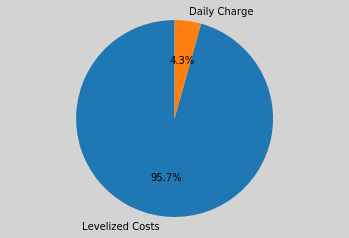

Total roof area of the  building: 599 m²
Total roof area used 590 m²
Percentage: 98.5%
[[160, 185, 245, 41, 31, 41, 0.35, 0.49999999999999994, 0.8499999999999999, 3062.39, 294.933, 0.0, 294.933, 0.0, {'Levelized Costs': 2929.335, 'Energy Charge': 0.013000000000033651, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59957552753, 61845.7, 589.867]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (205, 130, 125, 56, 26, 56, 0.6499999999999999, 0.3, 0.7499999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 205
                                           a tilt of 56.0
                                           and a gcr of 0.650


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6951189041137695 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 130
                                           a tilt of 26.0
                                           and a gcr of 0.300


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7113869190216064 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 125
                                           a tilt of 56.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7140142917633057 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  16 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 148 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 100s


ERROR:ga_logger:panel relevance: [293.465, 44.183, 0.0]


ERROR:ga_logger:Cost: 3486.65


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,487 per year


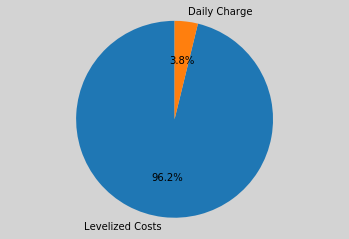

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[205, 130, 125, 56, 26, 56, 0.6499999999999999, 0.3, 0.7499999999999998, 3486.65, 337.64799999999997, 293.465, 44.183, 0.0, {'Levelized Costs': 3353.598, 'Energy Charge': 0.010000000000104592, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602076431926, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (150, 245, 260, 16, 16, 36, 0.7499999999999998, 0.6499999999999999, 0.7499999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 150
                                           a tilt of 16.0
                                           and a gcr of 0.750


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.627635955810547 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 245
                                           a tilt of 16.0
                                           and a gcr of 0.650


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5343551635742188 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 36.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5255682468414307 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 145 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 108s


ERROR:ga_logger:panel relevance: [315.138, 0.0, 0.0]


ERROR:ga_logger:Cost: 3263.07


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,263 per year


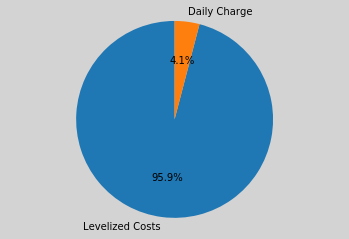

Total roof area of the  building: 599 m²
Total roof area used 420 m²
Percentage: 70.2%
[[150, 245, 260, 16, 16, 36, 0.7499999999999998, 0.6499999999999999, 0.7499999999999998, 3263.07, 315.138, 315.138, 0.0, 0.0, {'Levelized Costs': 3130.027, 'Energy Charge': 0.0010000000000331966, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60106463003, 61845.7, 420.184]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (135, 210, 220, 51, 6, 41, 0.35, 0.5999999999999999, 0.35)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 135
                                           a tilt of 51.0
                                           and a gcr of 0.350


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.714386463165283 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 210
                                           a tilt of 6.0
                                           and a gcr of 0.600


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7534189224243164 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 220
                                           a tilt of 41.0
                                           and a gcr of 0.350


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.730576515197754 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 147 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 109s


ERROR:ga_logger:panel relevance: [0.0, 268.466, 52.9614]


ERROR:ga_logger:Cost: 3325.54


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,326 per year


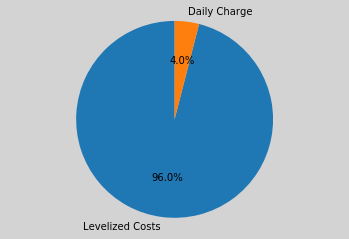

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[135, 210, 220, 51, 6, 41, 0.35, 0.5999999999999999, 0.35, 3325.54, 321.42740000000003, 0.0, 268.466, 52.9614, {'Levelized Costs': 3192.4929999999995, 'Energy Charge': 0.0050000000004502, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60191282137, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (90, 165, 245, 41, 1, 6, 0.7, 0.7499999999999998, 0.5999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 41.0
                                           and a gcr of 0.700


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6352458000183105 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 165
                                           a tilt of 1.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.6410577297210693 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 6.0
                                           and a gcr of 0.600


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.667691230773926 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 144 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 95s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 331.14]


ERROR:ga_logger:Cost: 3422.0


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,422 per year


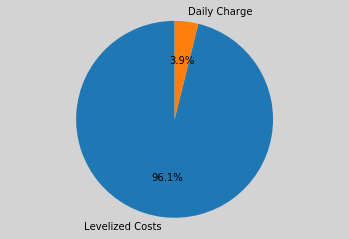

Total roof area of the  building: 599 m²
Total roof area used 552 m²
Percentage: 92.2%
[[90, 165, 245, 41, 1, 6, 0.7, 0.7499999999999998, 0.5999999999999999, 3422.0, 331.14, 0.0, 0.0, 331.14, {'Levelized Costs': 3288.9469999999997, 'Energy Charge': 0.011000000000535692, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60018044022, 61845.7, 551.9]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (145, 165, 170, 46, 56, 56, 0.25, 0.49999999999999994, 0.7499999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 145
                                           a tilt of 46.0
                                           and a gcr of 0.250


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.629565715789795 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 165
                                           a tilt of 56.0
                                           and a gcr of 0.500


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4620678424835205 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 170
                                           a tilt of 56.0
                                           and a gcr of 0.750

ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4931819438934326 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 145 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 98s


ERROR:ga_logger:panel relevance: [0.0, 243.219, 84.2425]


ERROR:ga_logger:Cost: 3385.47


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,385 per year


Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[145, 165, 170, 46, 56, 56, 0.25, 0.49999999999999994, 0.7499999999999998, 3385.47, 327.4615, 0.0, 243.219, 84.2425, {'Levelized Costs': 3252.4089999999997, 'Energy Charge': 0.019000000000175987, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60070349995, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (210, 200, 240, 31, 41, 36, 0.25, 0.8999999999999999, 0.5999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 210
                                           a tilt of 31.0
                                           and a gcr of 0.250


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6584081649780273 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 200
                                           a tilt of 41.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.979900598526001 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 240
                                           a tilt of 36.0
                                           and a gcr of 0.600


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5154929161071777 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 158 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 109s


ERROR:ga_logger:panel relevance: [81.1721, 246.666, 0.0]


ERROR:ga_logger:Cost: 3389.21


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,389 per year


Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[210, 200, 240, 31, 41, 36, 0.25, 0.8999999999999999, 0.5999999999999999, 3389.21, 327.8381, 81.1721, 246.666, 0.0, {'Levelized Costs': 3256.157, 'Energy Charge': 0.010999999999967258, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60182765224, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (95, 255, 110, 26, 51, 36, 0.35, 0.8999999999999999, 0.2)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 95
                                           a tilt of 26.0
                                           and a gcr of 0.350


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.777865409851074 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 255
                                           a tilt of 51.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.595958709716797 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 110
                                           a tilt of 36.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.750432014465332 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 156 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 100s


ERROR:ga_logger:panel relevance: [56.7831, 392.872, 0.0]


ERROR:ga_logger:Cost: 4599.12


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 4,599 per year


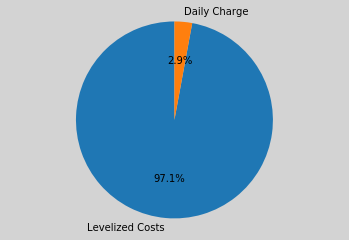

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[95, 255, 110, 26, 51, 36, 0.35, 0.8999999999999999, 0.2, 4599.12, 449.6551, 56.7831, 392.872, 0.0, {'Levelized Costs': 4466.062999999999, 'Energy Charge': 0.014999999999986358, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59962638997, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (140, 200, 140, 26, 51, 26, 0.39999999999999997, 0.49999999999999994, 0.25)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 140
                                           a tilt of 26.0
                                           and a gcr of 0.400


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.700363874435425 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 200
                                           a tilt of 51.0
                                           and a gcr of 0.500


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5670602321624756 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 140
                                           a tilt of 26.0
                                           and a gcr of 0.250


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5206997394561768 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 143 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 92s


ERROR:ga_logger:panel relevance: [0.0, 299.381, 0.0]


ERROR:ga_logger:Cost: 3533.13


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0069 /kWh
Total Cost of the system: $ 3,533 per year


Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[140, 200, 140, 26, 51, 26, 0.39999999999999997, 0.49999999999999994, 0.25, 3533.13, 299.381, 0.0, 299.381, 0.0, {'Levelized Costs': 2973.512, 'Energy Charge': 426.5760000000002, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 58441.23527891767, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (115, 235, 215, 1, 11, 26, 0.35, 0.7999999999999998, 0.7499999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 115
                                           a tilt of 1.0
                                           and a gcr of 0.350


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.6915385723114014 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 235
                                           a tilt of 11.0
                                           and a gcr of 0.800


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5838685035705566 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 215
                                           a tilt of 26.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6326475143432617 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 177 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 109s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 321.4]


ERROR:ga_logger:Cost: 3325.26


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,325 per year


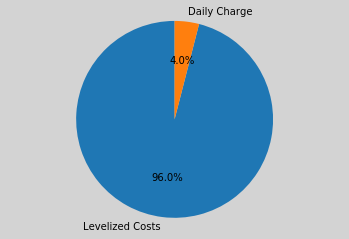

Total roof area of the  building: 599 m²
Total roof area used 429 m²
Percentage: 71.6%
[[115, 235, 215, 1, 11, 26, 0.35, 0.7999999999999998, 0.7499999999999998, 3325.26, 321.4, 0.0, 0.0, 321.4, {'Levelized Costs': 3192.202, 'Energy Charge': 0.016000000000076398, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60121985121, 61845.7, 428.533]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (255, 245, 150, 36, 1, 31, 0.6499999999999999, 0.8499999999999999, 0.2)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 255
                                           a tilt of 36.0
                                           and a gcr of 0.650


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.69805645942688 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 245
                                           a tilt of 1.0
                                           and a gcr of 0.850


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.5872395038604736 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 31.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6624667644500732 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 148 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 145s


ERROR:ga_logger:panel relevance: [0.0, 271.757, 55.8095]


ERROR:ga_logger:Cost: 3386.51


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,387 per year


Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[255, 245, 150, 36, 1, 31, 0.6499999999999999, 0.8499999999999999, 0.2, 3386.51, 327.5665, 0.0, 271.757, 55.8095, {'Levelized Costs': 3253.4500000000003, 'Energy Charge': 0.01799999999980173, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60177253217, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (185, 150, 220, 21, 36, 56, 0.8499999999999999, 0.5499999999999999, 0.44999999999999996)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 21.0
                                           and a gcr of 0.850


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.311147212982178 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 150
                                           a tilt of 36.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5222253799438477 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 220
                                           a tilt of 56.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.65545916557312 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 339 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 477s


ERROR:ga_logger:panel relevance: [0.0, 308.84, 0.0]


ERROR:ga_logger:Cost: 3200.52


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,201 per year


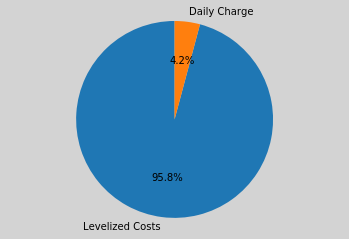

Total roof area of the  building: 599 m²
Total roof area used 562 m²
Percentage: 93.8%
[[185, 150, 220, 21, 36, 56, 0.8499999999999999, 0.5499999999999999, 0.44999999999999996, 3200.52, 308.84, 0.0, 308.84, 0.0, {'Levelized Costs': 3067.468, 'Energy Charge': 0.010000000000218279, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601693130026, 61845.7, 561.527]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (175, 245, 170, 6, 41, 51, 0.3, 0.8999999999999999, 0.2)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 175
                                           a tilt of 6.0
                                           and a gcr of 0.300


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 17.483539581298828 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 245
                                           a tilt of 41.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 15.325351238250732 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 170
                                           a tilt of 51.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 13.296221017837524 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  52 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 973 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 606s


ERROR:ga_logger:panel relevance: [75.6711, 311.872, 0.0]


ERROR:ga_logger:Cost: 3982.21


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,982 per year


Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[175, 245, 170, 6, 41, 51, 0.3, 0.8999999999999999, 0.2, 3982.21, 387.5431, 75.6711, 311.872, 0.0, {'Levelized Costs': 3849.165, 'Energy Charge': 0.003000000000156433, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.6010261707, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (265, 225, 105, 31, 31, 11, 0.35, 0.49999999999999994, 0.44999999999999996)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 265
                                           a tilt of 31.0
                                           and a gcr of 0.350


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 14.932788372039795 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 225
                                           a tilt of 31.0
                                           and a gcr of 0.500


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 13.63005256652832 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 105
                                           a tilt of 11.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 12.66288161277771 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  48 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 769 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 433s


ERROR:ga_logger:panel relevance: [0.0, 299.381, 0.0]


ERROR:ga_logger:Cost: 3521.17


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0067 /kWh
Total Cost of the system: $ 3,521 per year


Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[265, 225, 105, 31, 31, 11, 0.35, 0.49999999999999994, 0.44999999999999996, 3521.17, 299.381, 0.0, 299.381, 0.0, {'Levelized Costs': 2973.504, 'Energy Charge': 414.6240000000002, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 58536.694965250346, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (260, 160, 110, 6, 16, 51, 0.7999999999999998, 0.3, 0.7999999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 260
                                           a tilt of 6.0
                                           and a gcr of 0.800


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 15.08878469467163 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 160
                                           a tilt of 16.0
                                           and a gcr of 0.300


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 12.89818024635315 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 110
                                           a tilt of 51.0
                                           and a gcr of 0.800


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 13.370790481567383 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  46 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 953 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 394s


ERROR:ga_logger:panel relevance: [235.379, 91.3614, 0.0]


ERROR:ga_logger:Cost: 3378.31


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,378 per year


Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[260, 160, 110, 6, 16, 51, 0.7999999999999998, 0.3, 0.7999999999999998, 3378.31, 326.7404, 235.379, 91.3614, 0.0, {'Levelized Costs': 3245.256, 'Energy Charge': 0.012000000000057298, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60101651694, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (95, 130, 225, 21, 56, 1, 0.6499999999999999, 0.8499999999999999, 0.8499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 95
                                           a tilt of 21.0
                                           and a gcr of 0.650


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 15.056888818740845 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 130
                                           a tilt of 56.0
                                           and a gcr of 0.850


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 12.970783233642578 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 225
                                           a tilt of 1.0
                                           and a gcr of 0.850


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 9.12237000465393 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  43 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 807 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 453s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 334.355]


ERROR:ga_logger:Cost: 3453.93


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,454 per year


Total roof area of the  building: 599 m²
Total roof area used 393 m²
Percentage: 65.7%
[[95, 130, 225, 21, 56, 1, 0.6499999999999999, 0.8499999999999999, 0.8499999999999999, 3453.93, 334.355, 0.0, 0.0, 334.355, {'Levelized Costs': 3320.8579999999997, 'Energy Charge': 0.03000000000020009, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60181143399, 61845.7, 393.358]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (150, 115, 150, 36, 26, 6, 0.5499999999999999, 0.7999999999999998, 0.8499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 150
                                           a tilt of 36.0
                                           and a gcr of 0.550


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 14.941610097885132 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 115
                                           a tilt of 26.0
                                           and a gcr of 0.800


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 13.242722511291504 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 6.0
                                           and a gcr of 0.850


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 13.36639928817749 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  48 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 917 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 413s


ERROR:ga_logger:panel relevance: [308.84, 0.0, 0.0]


ERROR:ga_logger:Cost: 3200.52


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,201 per year


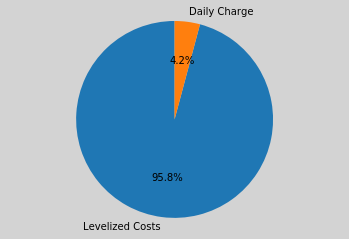

Total roof area of the  building: 599 m²
Total roof area used 562 m²
Percentage: 93.8%
[[150, 115, 150, 36, 26, 6, 0.5499999999999999, 0.7999999999999998, 0.8499999999999999, 3200.52, 308.84, 308.84, 0.0, 0.0, {'Levelized Costs': 3067.468, 'Energy Charge': 0.010000000000218279, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601693130026, 61845.7, 561.527]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (240, 225, 215, 31, 1, 21, 0.7, 0.35, 0.2)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 240
                                           a tilt of 31.0
                                           and a gcr of 0.700


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 15.208614587783813 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 225
                                           a tilt of 1.0
                                           and a gcr of 0.350


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 9.450984001159668 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 215
                                           a tilt of 21.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 14.804240942001343 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  46 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 916 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 425s


ERROR:ga_logger:panel relevance: [313.198, 0.0, 30.2673]


ERROR:ga_logger:Cost: 3544.42


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,544 per year


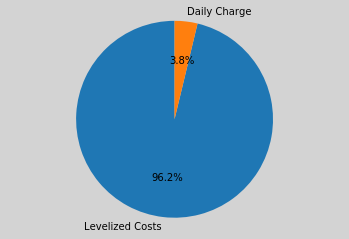

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[240, 225, 215, 31, 1, 21, 0.7, 0.35, 0.2, 3544.42, 343.46529999999996, 313.198, 0.0, 30.2673, {'Levelized Costs': 3411.377, 'Energy Charge': 0.0010000000002037268, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60092838261, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (250, 250, 225, 51, 41, 6, 0.35, 0.39999999999999997, 0.44999999999999996)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 250
                                           a tilt of 51.0
                                           and a gcr of 0.350


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 15.648542642593384 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 250
                                           a tilt of 41.0
                                           and a gcr of 0.400


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 13.426056385040283 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 225
                                           a tilt of 6.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 15.952188491821289 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  51 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 981 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 352s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 269.443]


ERROR:ga_logger:Cost: 4151.91


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0217 /kWh
Total Cost of the system: $ 4,152 per year


Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[250, 250, 225, 51, 41, 6, 0.35, 0.39999999999999997, 0.44999999999999996, 4151.91, 269.443, 0.0, 0.0, 269.443, {'Levelized Costs': 2676.162, 'Energy Charge': 1342.7060000000001, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 51129.75912078036, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (200, 185, 175, 56, 1, 46, 0.7, 0.6499999999999999, 0.5999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 200
                                           a tilt of 56.0
                                           and a gcr of 0.700


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 11.847016096115112 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 1.0
                                           and a gcr of 0.650


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 9.583010196685791 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 46.0
                                           and a gcr of 0.600


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 11.121506929397583 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  38 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 693 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 388s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 310.613]


ERROR:ga_logger:Cost: 3218.12


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,218 per year


Total roof area of the  building: 599 m²
Total roof area used 518 m²
Percentage: 86.5%
[[200, 185, 175, 56, 1, 46, 0.7, 0.6499999999999999, 0.5999999999999999, 3218.12, 310.613, 0.0, 0.0, 310.613, {'Levelized Costs': 3085.0629999999996, 'Energy Charge': 0.015000000000213731, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.6012944, 61845.7, 517.688]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (120, 160, 215, 26, 56, 46, 0.44999999999999996, 0.8499999999999999, 0.25)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 120
                                           a tilt of 26.0
                                           and a gcr of 0.450


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.239261150360107 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 160
                                           a tilt of 56.0
                                           and a gcr of 0.850


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8123106956481934 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 215
                                           a tilt of 46.0
                                           and a gcr of 0.250


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 10.630874156951904 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  21 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 710 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 380s


ERROR:ga_logger:panel relevance: [194.027, 142.451, 0.0]


ERROR:ga_logger:Cost: 3475.03


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,475 per year


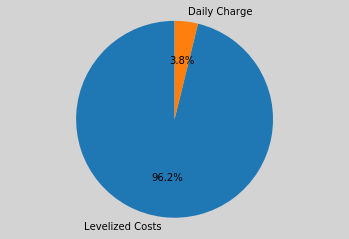

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[120, 160, 215, 26, 56, 46, 0.44999999999999996, 0.8499999999999999, 0.25, 3475.03, 336.47799999999995, 194.027, 142.451, 0.0, {'Levelized Costs': 3341.971, 'Energy Charge': 0.01700000000005275, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60028463998, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (210, 190, 230, 1, 6, 11, 0.39999999999999997, 0.7999999999999998, 0.5999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 210
                                           a tilt of 1.0
                                           and a gcr of 0.400


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 10.089545011520386 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 190
                                           a tilt of 6.0
                                           and a gcr of 0.800


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 11.084201335906982 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 230
                                           a tilt of 11.0
                                           and a gcr of 0.600


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 10.460774898529053 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  36 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 673 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 364s


ERROR:ga_logger:panel relevance: [0.0, 321.942, 0.0]


ERROR:ga_logger:Cost: 3330.65


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,331 per year


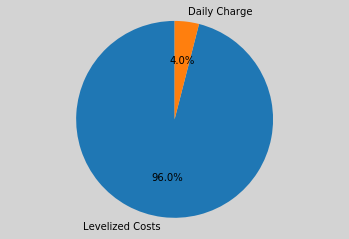

Total roof area of the  building: 599 m²
Total roof area used 402 m²
Percentage: 67.2%
[[210, 190, 230, 1, 6, 11, 0.39999999999999997, 0.7999999999999998, 0.5999999999999999, 3330.65, 321.942, 0.0, 321.942, 0.0, {'Levelized Costs': 3197.598, 'Energy Charge': 0.010000000000218279, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59922986158, 61845.7, 402.428]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (215, 200, 230, 46, 41, 41, 0.7999999999999998, 0.5999999999999999, 0.35)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 215
                                           a tilt of 46.0
                                           and a gcr of 0.800


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 8.727013349533081 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 200
                                           a tilt of 41.0
                                           and a gcr of 0.600


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 8.157554149627686 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 230
                                           a tilt of 41.0
                                           and a gcr of 0.350


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 8.267078638076782 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  32 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 471 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 276s


ERROR:ga_logger:panel relevance: [0.0, 310.844, 0.0]


ERROR:ga_logger:Cost: 3220.42


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,220 per year


Total roof area of the  building: 599 m²
Total roof area used 518 m²
Percentage: 86.5%
[[215, 200, 230, 46, 41, 41, 0.7999999999999998, 0.5999999999999999, 0.35, 3220.42, 310.844, 0.0, 310.844, 0.0, {'Levelized Costs': 3087.3609999999994, 'Energy Charge': 0.017000000000621185, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60098250764, 61845.7, 518.073]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (265, 245, 155, 36, 11, 51, 0.8499999999999999, 0.44999999999999996, 0.7)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 265
                                           a tilt of 36.0
                                           and a gcr of 0.850


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 8.813050031661987 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 245
                                           a tilt of 11.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 8.480571031570435 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 155
                                           a tilt of 51.0
                                           and a gcr of 0.700


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.890141725540161 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  26 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 546 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 296s


ERROR:ga_logger:panel relevance: [0.0, 154.472, 178.843]


ERROR:ga_logger:Cost: 3443.61


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,444 per year


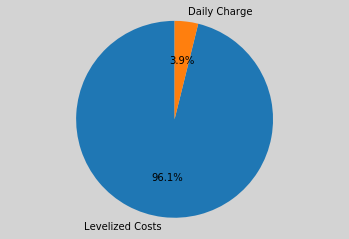

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[265, 245, 155, 36, 11, 51, 0.8499999999999999, 0.44999999999999996, 0.7, 3443.61, 333.315, 0.0, 154.472, 178.843, {'Levelized Costs': 3310.5570000000002, 'Energy Charge': 0.011000000000137788, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60012294392, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (125, 150, 245, 16, 51, 56, 0.7, 0.35, 0.44999999999999996)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 125
                                           a tilt of 16.0
                                           and a gcr of 0.700


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 8.503664255142212 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 150
                                           a tilt of 51.0
                                           and a gcr of 0.350


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 8.137864351272583 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 56.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 8.066393852233887 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  30 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 532 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 249s


ERROR:ga_logger:panel relevance: [222.794, 98.1694, 0.0]


ERROR:ga_logger:Cost: 3320.93


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,321 per year


Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[125, 150, 245, 16, 51, 56, 0.7, 0.35, 0.44999999999999996, 3320.93, 320.9634, 222.794, 98.1694, 0.0, {'Levelized Costs': 3187.881, 'Energy Charge': 0.006999999999948159, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601354229904, 61845.7, 598.762]]


ERROR:optimizer_logger:150


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (95, 195, 100, 16, 11, 41, 0.25, 0.49999999999999994, 0.25)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 95
                                           a tilt of 16.0
                                           and a gcr of 0.250


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 8.49377727508545 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 195
                                           a tilt of 11.0
                                           and a gcr of 0.500


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 8.68330979347229 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 100
                                           a tilt of 41.0
                                           and a gcr of 0.250


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.970190048217773 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  30 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 463 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 223s


ERROR:ga_logger:panel relevance: [0.0, 299.381, 0.0]


ERROR:ga_logger:Cost: 3411.3


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0049 /kWh
Total Cost of the system: $ 3,411 per year


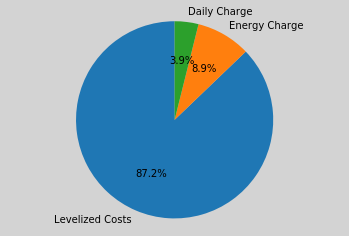

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[95, 195, 100, 16, 11, 41, 0.25, 0.49999999999999994, 0.25, 3411.3, 299.381, 0.0, 299.381, 0.0, {'Levelized Costs': 2973.522, 'Energy Charge': 304.7360000000002, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 59413.604525010545, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (160, 205, 130, 36, 36, 31, 0.8499999999999999, 0.8999999999999999, 0.5999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 160
                                           a tilt of 36.0
                                           and a gcr of 0.850


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 8.827778816223145 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 205
                                           a tilt of 36.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 8.142570972442627 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 130
                                           a tilt of 31.0
                                           and a gcr of 0.600


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 8.114022254943848 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  29 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 421 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 243s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 324.514]


ERROR:ga_logger:Cost: 3356.2


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,356 per year


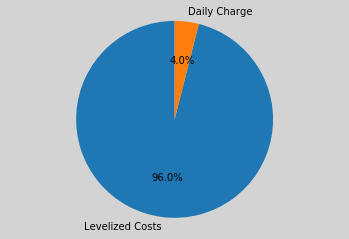

Total roof area of the  building: 599 m²
Total roof area used 541 m²
Percentage: 90.3%
[[160, 205, 130, 36, 36, 31, 0.8499999999999999, 0.8999999999999999, 0.5999999999999999, 3356.2, 324.514, 0.0, 0.0, 324.514, {'Levelized Costs': 3223.144, 'Energy Charge': 0.014000000000294222, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60302020997, 61845.7, 540.857]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (215, 160, 220, 16, 11, 56, 0.7999999999999998, 0.3, 0.3)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 215
                                           a tilt of 16.0
                                           and a gcr of 0.800


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.575856924057007 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 160
                                           a tilt of 11.0
                                           and a gcr of 0.300


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.403252124786377 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 220
                                           a tilt of 56.0
                                           and a gcr of 0.300


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4865875244140625 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 138 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 105s


ERROR:ga_logger:panel relevance: [221.375, 96.6129, 0.0]


ERROR:ga_logger:Cost: 3291.38


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,291 per year


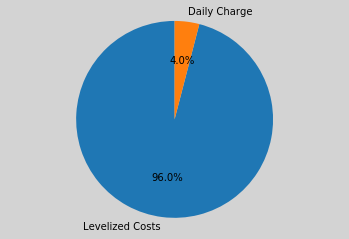

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[215, 160, 220, 16, 11, 56, 0.7999999999999998, 0.3, 0.3, 3291.38, 317.98789999999997, 221.375, 96.6129, 0.0, {'Levelized Costs': 3158.319, 'Energy Charge': 0.019000000000005457, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60141459577, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (220, 250, 265, 51, 11, 46, 0.6499999999999999, 0.3, 0.7499999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 220
                                           a tilt of 51.0
                                           and a gcr of 0.650


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.673983335494995 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 250
                                           a tilt of 11.0
                                           and a gcr of 0.300


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6766748428344727 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 46.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4362854957580566 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 138 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 125s


ERROR:ga_logger:panel relevance: [313.368, 34.9971, 0.0]


ERROR:ga_logger:Cost: 3593.09


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,593 per year


Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[220, 250, 265, 51, 11, 46, 0.6499999999999999, 0.3, 0.7499999999999998, 3593.09, 348.3651, 313.368, 34.9971, 0.0, {'Levelized Costs': 3460.0409999999997, 'Energy Charge': 0.00700000000045975, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60103714089, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (175, 235, 90, 51, 36, 56, 0.35, 0.44999999999999996, 0.5999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 175
                                           a tilt of 51.0
                                           and a gcr of 0.350


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4972288608551025 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 235
                                           a tilt of 36.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3762805461883545 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 56.0
                                           and a gcr of 0.600


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3687024116516113 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 139 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 91s


ERROR:ga_logger:panel relevance: [0.0, 269.443, 0.0]


ERROR:ga_logger:Cost: 4198.58


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0225 /kWh
Total Cost of the system: $ 4,199 per year


Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[175, 235, 90, 51, 36, 56, 0.35, 0.44999999999999996, 0.5999999999999999, 4198.58, 269.443, 0.0, 269.443, 0.0, {'Levelized Costs': 2676.1649999999995, 'Energy Charge': 1389.3730000000005, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 50757.31066209002, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (235, 190, 240, 51, 46, 36, 0.44999999999999996, 0.5499999999999999, 0.35)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 235
                                           a tilt of 51.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.756352663040161 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 190
                                           a tilt of 46.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.675079822540283 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 240
                                           a tilt of 36.0
                                           and a gcr of 0.350


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5415313243865967 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 139 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 99s


ERROR:ga_logger:panel relevance: [0.0, 307.413, 0.0]


ERROR:ga_logger:Cost: 3186.35


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,186 per year


Total roof area of the  building: 599 m²
Total roof area used 559 m²
Percentage: 93.3%
[[235, 190, 240, 51, 46, 36, 0.44999999999999996, 0.5499999999999999, 0.35, 3186.35, 307.413, 0.0, 307.413, 0.0, {'Levelized Costs': 3053.294, 'Energy Charge': 0.013999999999953161, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60144214698, 61845.7, 558.933]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (145, 190, 225, 36, 31, 21, 0.8999999999999999, 0.5999999999999999, 0.7999999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 145
                                           a tilt of 36.0
                                           and a gcr of 0.900


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5507988929748535 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 190
                                           a tilt of 31.0
                                           and a gcr of 0.600


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3685903549194336 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 225
                                           a tilt of 21.0
                                           and a gcr of 0.800


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.9223601818084717 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 139 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 96s


ERROR:ga_logger:panel relevance: [0.0, 299.937, 0.0]


ERROR:ga_logger:Cost: 3112.09


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,112 per year


Total roof area of the  building: 599 m²
Total roof area used 500 m²
Percentage: 83.5%
[[145, 190, 225, 36, 31, 21, 0.8999999999999999, 0.5999999999999999, 0.7999999999999998, 3112.09, 299.937, 0.0, 299.937, 0.0, {'Levelized Costs': 2979.031, 'Energy Charge': 0.017000000000109594, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.599749165565, 61845.7, 499.895]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (110, 120, 175, 36, 56, 36, 0.7, 0.6499999999999999, 0.2)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 110
                                           a tilt of 36.0
                                           and a gcr of 0.700


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5462076663970947 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 120
                                           a tilt of 56.0
                                           and a gcr of 0.650


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3959290981292725 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 36.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.374781847000122 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 138 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 123s


ERROR:ga_logger:panel relevance: [341.4, 0.0, 22.2096]


ERROR:ga_logger:Cost: 3744.5


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,744 per year


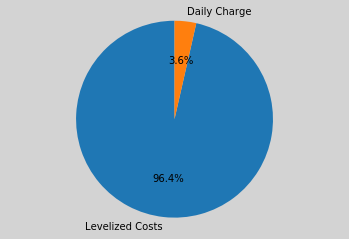

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[110, 120, 175, 36, 56, 36, 0.7, 0.6499999999999999, 0.2, 3744.5, 363.6096, 341.4, 0.0, 22.2096, {'Levelized Costs': 3611.457, 'Energy Charge': 0.0009999999999763531, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600426399986, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (260, 205, 175, 6, 46, 6, 0.3, 0.8999999999999999, 0.7)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 260
                                           a tilt of 6.0
                                           and a gcr of 0.300


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.867278575897217 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 205
                                           a tilt of 46.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.50868821144104 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 6.0
                                           and a gcr of 0.700


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.487952947616577 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 138 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 105s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 320.882]


ERROR:ga_logger:Cost: 3320.12


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,320 per year


Total roof area of the  building: 599 m²
Total roof area used 458 m²
Percentage: 76.6%
[[260, 205, 175, 6, 46, 6, 0.3, 0.8999999999999999, 0.7, 3320.12, 320.882, 0.0, 0.0, 320.882, {'Levelized Costs': 3187.0619999999994, 'Energy Charge': 0.01600000000030377, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.6001230079, 61845.7, 458.403]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (205, 140, 205, 51, 11, 26, 0.8999999999999999, 0.5499999999999999, 0.8499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 205
                                           a tilt of 51.0
                                           and a gcr of 0.900


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5600802898406982 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 140
                                           a tilt of 11.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3692147731781006 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 205
                                           a tilt of 26.0
                                           and a gcr of 0.850


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.631023406982422 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 138 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 94s


ERROR:ga_logger:panel relevance: [0.0, 316.01, 0.0]


ERROR:ga_logger:Cost: 3271.73


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,272 per year


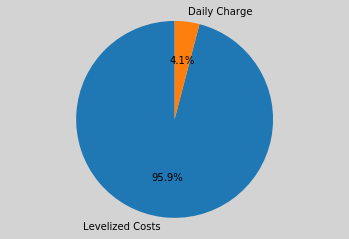

Total roof area of the  building: 599 m²
Total roof area used 575 m²
Percentage: 96.0%
[[205, 140, 205, 51, 11, 26, 0.8999999999999999, 0.5499999999999999, 0.8499999999999999, 3271.73, 316.01, 0.0, 316.01, 0.0, {'Levelized Costs': 3138.677, 'Energy Charge': 0.010999999999853571, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60512946977, 61845.7, 574.563]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (115, 95, 195, 11, 51, 26, 0.39999999999999997, 0.5999999999999999, 0.8999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 115
                                           a tilt of 11.0
                                           and a gcr of 0.400


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5467922687530518 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 95
                                           a tilt of 51.0
                                           and a gcr of 0.600


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4941413402557373 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 195
                                           a tilt of 26.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.46520733833313 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 138 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 89s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 323.348]


ERROR:ga_logger:Cost: 3344.61


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,345 per year


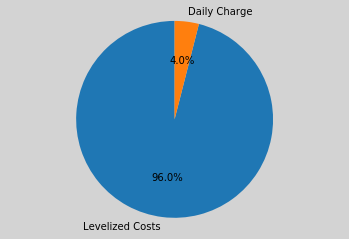

Total roof area of the  building: 599 m²
Total roof area used 359 m²
Percentage: 60.0%
[[115, 95, 195, 11, 51, 26, 0.39999999999999997, 0.5999999999999999, 0.8999999999999999, 3344.61, 323.348, 0.0, 0.0, 323.348, {'Levelized Costs': 3211.555, 'Energy Charge': 0.013000000000261025, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601998168655, 61845.7, 359.276]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (90, 120, 120, 56, 1, 31, 0.2, 0.49999999999999994, 0.2)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 56.0
                                           and a gcr of 0.200


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.530097246170044 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 120
                                           a tilt of 1.0
                                           and a gcr of 0.500


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.41125750541687 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 120
                                           a tilt of 31.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.584251642227173 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 140 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 94s


ERROR:ga_logger:panel relevance: [0.0, 299.381, 0.0]


ERROR:ga_logger:Cost: 3918.53


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0131 /kWh
Total Cost of the system: $ 3,919 per year


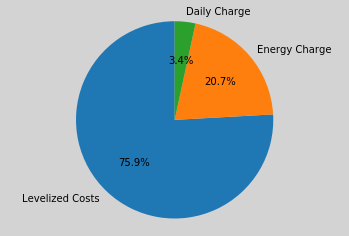

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[90, 120, 120, 56, 1, 31, 0.2, 0.49999999999999994, 0.2, 3918.53, 299.381, 0.0, 299.381, 0.0, {'Levelized Costs': 2973.516, 'Energy Charge': 811.972, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 55365.47317126942, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (240, 225, 240, 31, 51, 51, 0.35, 0.25, 0.6499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 240
                                           a tilt of 31.0
                                           and a gcr of 0.350


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6854450702667236 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 225
                                           a tilt of 51.0
                                           and a gcr of 0.250


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.537942886352539 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 240
                                           a tilt of 51.0
                                           and a gcr of 0.650


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3874542713165283 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 138 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 118s


ERROR:ga_logger:panel relevance: [6.21473, 0.0, 377.653]


ERROR:ga_logger:Cost: 3945.71


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,946 per year


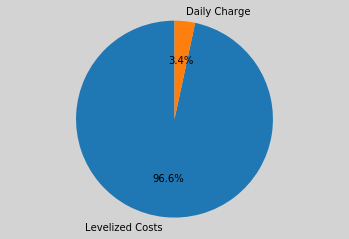

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[240, 225, 240, 31, 51, 51, 0.35, 0.25, 0.6499999999999999, 3945.71, 383.86773, 6.21473, 0.0, 377.653, {'Levelized Costs': 3812.658, 'Energy Charge': 0.010000000000218279, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600385981925, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (150, 170, 155, 1, 41, 36, 0.6499999999999999, 0.6499999999999999, 0.8499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 150
                                           a tilt of 1.0
                                           and a gcr of 0.650


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.611579179763794 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 41.0
                                           and a gcr of 0.650


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3888747692108154 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 155
                                           a tilt of 36.0
                                           and a gcr of 0.850


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3731367588043213 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 138 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 95s


ERROR:ga_logger:panel relevance: [0.0, 309.965, 0.0]


ERROR:ga_logger:Cost: 3211.7


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,212 per year


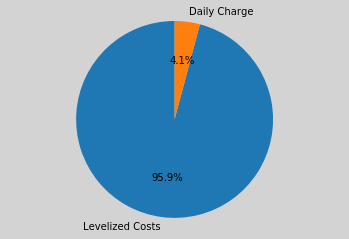

Total roof area of the  building: 599 m²
Total roof area used 477 m²
Percentage: 79.6%
[[150, 170, 155, 1, 41, 36, 0.6499999999999999, 0.6499999999999999, 0.8499999999999999, 3211.7, 309.965, 0.0, 309.965, 0.0, {'Levelized Costs': 3078.645, 'Energy Charge': 0.012999999999976808, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600817200044, 61845.7, 476.87]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (160, 165, 150, 16, 31, 1, 0.7499999999999998, 0.39999999999999997, 0.5499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 160
                                           a tilt of 16.0
                                           and a gcr of 0.750


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.491069793701172 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 165
                                           a tilt of 31.0
                                           and a gcr of 0.400


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.389545440673828 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 1.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.4153337478637695 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 139 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 91s


ERROR:ga_logger:panel relevance: [133.838, 168.125, 0.0]


ERROR:ga_logger:Cost: 3132.21


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,132 per year


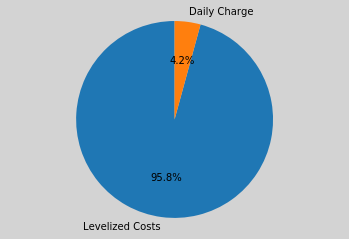

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[160, 165, 150, 16, 31, 1, 0.7499999999999998, 0.39999999999999997, 0.5499999999999999, 3132.21, 301.96299999999997, 133.838, 168.125, 0.0, {'Levelized Costs': 2999.146, 'Energy Charge': 0.022000000000105047, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60096641111, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (170, 115, 120, 51, 26, 56, 0.8499999999999999, 0.7499999999999998, 0.6499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 170
                                           a tilt of 51.0
                                           and a gcr of 0.850


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5376012325286865 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 115
                                           a tilt of 26.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.37817645072937 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 120
                                           a tilt of 56.0
                                           and a gcr of 0.650


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3700461387634277 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 138 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 97s


ERROR:ga_logger:panel relevance: [340.395, 0.0, 0.0]


ERROR:ga_logger:Cost: 3513.93


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,514 per year


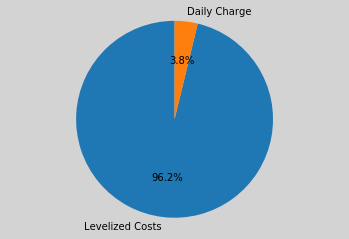

Total roof area of the  building: 599 m²
Total roof area used 400 m²
Percentage: 66.9%
[[170, 115, 120, 51, 26, 56, 0.8499999999999999, 0.7499999999999998, 0.6499999999999999, 3513.93, 340.395, 340.395, 0.0, 0.0, {'Levelized Costs': 3380.8689999999997, 'Energy Charge': 0.019000000000289674, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60018170016, 61845.7, 400.465]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (255, 250, 120, 11, 41, 26, 0.7, 0.7499999999999998, 0.3)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 255
                                           a tilt of 11.0
                                           and a gcr of 0.700


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8113160133361816 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 250
                                           a tilt of 41.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.363553285598755 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 120
                                           a tilt of 26.0
                                           and a gcr of 0.300


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.463761806488037 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 138 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 99s


ERROR:ga_logger:panel relevance: [267.142, 0.0, 65.1393]


ERROR:ga_logger:Cost: 3433.34


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,433 per year


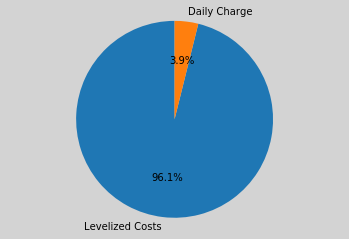

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[255, 250, 120, 11, 41, 26, 0.7, 0.7499999999999998, 0.3, 3433.34, 332.2813, 267.142, 0.0, 65.1393, {'Levelized Costs': 3300.2900000000004, 'Energy Charge': 0.008000000000038199, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60236440017, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (220, 180, 125, 16, 1, 11, 0.3, 0.44999999999999996, 0.8499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 220
                                           a tilt of 16.0
                                           and a gcr of 0.300


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.526890993118286 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 1.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.423367500305176 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 125
                                           a tilt of 11.0
                                           and a gcr of 0.850


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3424503803253174 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 138 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 98s


ERROR:ga_logger:panel relevance: [100.377, 0.0, 224.546]


ERROR:ga_logger:Cost: 3360.26


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,360 per year


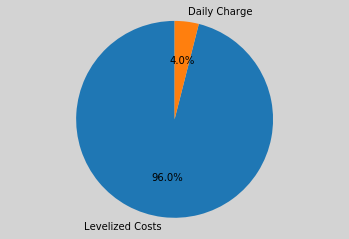

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[220, 180, 125, 16, 1, 11, 0.3, 0.44999999999999996, 0.8499999999999999, 3360.26, 324.923, 100.377, 0.0, 224.546, {'Levelized Costs': 3227.2030000000004, 'Energy Charge': 0.014999999999986358, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600589470785, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (100, 260, 150, 26, 46, 1, 0.3, 0.6499999999999999, 0.2)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 100
                                           a tilt of 26.0
                                           and a gcr of 0.300


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.544121265411377 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 260
                                           a tilt of 46.0
                                           and a gcr of 0.650


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3499529361724854 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 1.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.446390390396118 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 139 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 97s


ERROR:ga_logger:panel relevance: [0.0, 389.195, 0.0]


ERROR:ga_logger:Cost: 4500.45


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0081 /kWh
Total Cost of the system: $ 4,500 per year


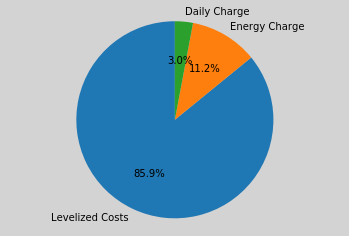

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[100, 260, 150, 26, 46, 1, 0.3, 0.6499999999999999, 0.2, 4500.45, 389.195, 0.0, 389.195, 0.0, {'Levelized Costs': 3865.5629999999996, 'Energy Charge': 501.8450000000001, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 57840.60286891996, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (265, 205, 175, 21, 6, 6, 0.3, 0.8999999999999999, 0.49999999999999994)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 265
                                           a tilt of 21.0
                                           and a gcr of 0.300


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.213713645935059 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 205
                                           a tilt of 6.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5498533248901367 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 6.0
                                           and a gcr of 0.500


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4851441383361816 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 139 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 97s


ERROR:ga_logger:panel relevance: [0.0, 48.951, 272.186]


ERROR:ga_logger:Cost: 3322.65


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,323 per year


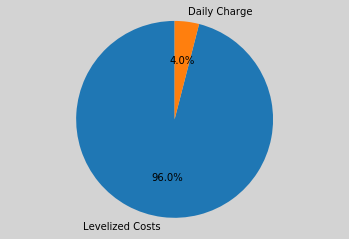

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[265, 205, 175, 21, 6, 6, 0.3, 0.8999999999999999, 0.49999999999999994, 3322.65, 321.137, 0.0, 48.951, 272.186, {'Levelized Costs': 3189.5899999999997, 'Energy Charge': 0.018000000000256478, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600215020604, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (195, 125, 135, 31, 56, 36, 0.5999999999999999, 0.39999999999999997, 0.7499999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 195
                                           a tilt of 31.0
                                           and a gcr of 0.600


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5073962211608887 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 125
                                           a tilt of 56.0
                                           and a gcr of 0.400


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.43690824508667 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 135
                                           a tilt of 36.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5138673782348633 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 139 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 101s


ERROR:ga_logger:panel relevance: [301.688, 0.0, 0.0]


ERROR:ga_logger:Cost: 3129.48


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,129 per year


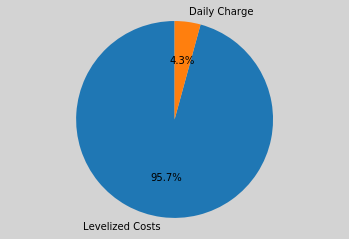

Total roof area of the  building: 599 m²
Total roof area used 503 m²
Percentage: 84.0%
[[195, 125, 135, 31, 56, 36, 0.5999999999999999, 0.39999999999999997, 0.7499999999999998, 3129.48, 301.688, 301.688, 0.0, 0.0, {'Levelized Costs': 2996.422, 'Energy Charge': 0.016000000000019554, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.5995156027, 61845.7, 502.813]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (165, 205, 160, 41, 41, 16, 0.7, 0.2, 0.44999999999999996)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 165
                                           a tilt of 41.0
                                           and a gcr of 0.700


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.533565044403076 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 205
                                           a tilt of 41.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4715049266815186 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 160
                                           a tilt of 16.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3520541191101074 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 139 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 95s


ERROR:ga_logger:panel relevance: [108.533, 0.0, 199.671]


ERROR:ga_logger:Cost: 3194.21


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,194 per year


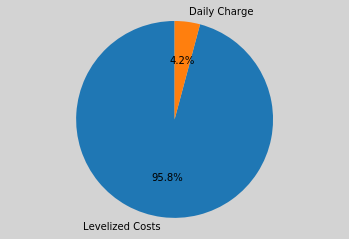

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[165, 205, 160, 41, 41, 16, 0.7, 0.2, 0.44999999999999996, 3194.21, 308.204, 108.533, 0.0, 199.671, {'Levelized Costs': 3061.149, 'Energy Charge': 0.019000000000119144, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60051719997, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (145, 230, 135, 51, 46, 21, 0.2, 0.25, 0.7)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 145
                                           a tilt of 51.0
                                           and a gcr of 0.200


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5180792808532715 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 230
                                           a tilt of 46.0
                                           and a gcr of 0.250


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.493185520172119 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 135
                                           a tilt of 21.0
                                           and a gcr of 0.700


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6254281997680664 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 140 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 100s


ERROR:ga_logger:panel relevance: [40.0914, 0.0, 278.813]


ERROR:ga_logger:Cost: 3300.48


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,300 per year


Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[145, 230, 135, 51, 46, 21, 0.2, 0.25, 0.7, 3300.48, 318.9044, 40.0914, 0.0, 278.813, {'Levelized Costs': 3167.424, 'Energy Charge': 0.014000000000294222, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60133459999, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (195, 235, 190, 56, 36, 11, 0.49999999999999994, 0.7999999999999998, 0.5499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 195
                                           a tilt of 56.0
                                           and a gcr of 0.500


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.497437000274658 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 235
                                           a tilt of 36.0
                                           and a gcr of 0.800


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.360720157623291 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 190
                                           a tilt of 11.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.834113597869873 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 138 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 100s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 311.181]


ERROR:ga_logger:Cost: 3223.77


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,224 per year


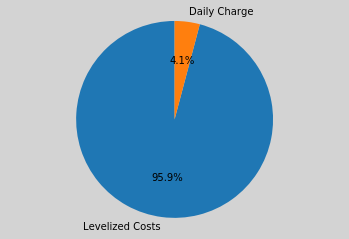

Total roof area of the  building: 599 m²
Total roof area used 566 m²
Percentage: 94.5%
[[195, 235, 190, 56, 36, 11, 0.49999999999999994, 0.7999999999999998, 0.5499999999999999, 3223.77, 311.181, 0.0, 0.0, 311.181, {'Levelized Costs': 3090.726, 'Energy Charge': 0.0019999999999527063, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60350961076, 61845.7, 565.785]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (225, 165, 100, 51, 11, 36, 0.44999999999999996, 0.8499999999999999, 0.5499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 225
                                           a tilt of 51.0
                                           and a gcr of 0.450


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7098453044891357 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 165
                                           a tilt of 11.0
                                           and a gcr of 0.850


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4680914878845215 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 100
                                           a tilt of 36.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.512861728668213 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 145 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 96s


ERROR:ga_logger:panel relevance: [0.0, 319.096, 0.0]


ERROR:ga_logger:Cost: 3302.38


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,302 per year


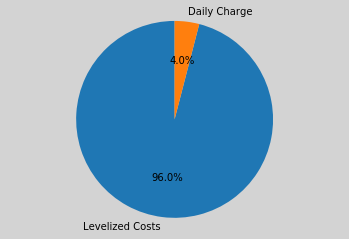

Total roof area of the  building: 599 m²
Total roof area used 375 m²
Percentage: 62.7%
[[225, 165, 100, 51, 11, 36, 0.44999999999999996, 0.8499999999999999, 0.5499999999999999, 3302.38, 319.096, 0.0, 319.096, 0.0, {'Levelized Costs': 3169.3340000000003, 'Energy Charge': 0.004000000000132786, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59905188291, 61845.7, 375.407]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (240, 245, 110, 16, 56, 51, 0.2, 0.6499999999999999, 0.5999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 240
                                           a tilt of 16.0
                                           and a gcr of 0.200


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.0786638259887695 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 245
                                           a tilt of 56.0
                                           and a gcr of 0.650


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6089320182800293 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 110
                                           a tilt of 51.0
                                           and a gcr of 0.600


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.524510622024536 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 144 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 93s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 359.257]


ERROR:ga_logger:Cost: 4406.64


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0114 /kWh
Total Cost of the system: $ 4,407 per year


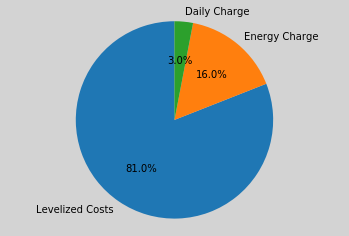

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[240, 245, 110, 16, 56, 51, 0.2, 0.6499999999999999, 0.5999999999999999, 4406.64, 359.257, 0.0, 0.0, 359.257, {'Levelized Costs': 3568.204, 'Energy Charge': 705.394, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 56216.11088479989, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (140, 150, 155, 11, 51, 26, 0.3, 0.8499999999999999, 0.5999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 140
                                           a tilt of 11.0
                                           and a gcr of 0.300


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.622908353805542 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 150
                                           a tilt of 51.0
                                           and a gcr of 0.850


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.563148021697998 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 155
                                           a tilt of 26.0
                                           and a gcr of 0.600


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.588266611099243 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 144 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 104s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 304.868]


ERROR:ga_logger:Cost: 3161.06


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,161 per year


Total roof area of the  building: 599 m²
Total roof area used 508 m²
Percentage: 84.9%
[[140, 150, 155, 11, 51, 26, 0.3, 0.8499999999999999, 0.5999999999999999, 3161.06, 304.868, 0.0, 0.0, 304.868, {'Levelized Costs': 3028.002, 'Energy Charge': 0.015999999999905867, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602954599875, 61845.7, 508.113]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (120, 205, 130, 26, 1, 6, 0.39999999999999997, 0.25, 0.8999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 120
                                           a tilt of 26.0
                                           and a gcr of 0.400


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6691336631774902 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 205
                                           a tilt of 1.0
                                           and a gcr of 0.250


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.6872315406799316 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 130
                                           a tilt of 6.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.445674419403076 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 141 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 102s


ERROR:ga_logger:panel relevance: [171.376, 0.0, 153.29]


ERROR:ga_logger:Cost: 3357.7


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,358 per year


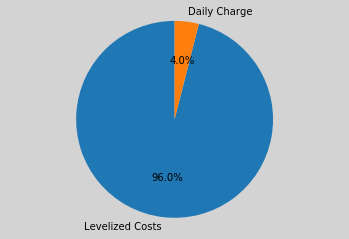

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[120, 205, 130, 26, 1, 6, 0.39999999999999997, 0.25, 0.8999999999999999, 3357.7, 324.666, 171.376, 0.0, 153.29, {'Levelized Costs': 3224.6419999999994, 'Energy Charge': 0.016000000000417458, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59944281973, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (175, 175, 170, 31, 46, 51, 0.7, 0.8499999999999999, 0.35)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 175
                                           a tilt of 31.0
                                           and a gcr of 0.700


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6572561264038086 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 46.0
                                           and a gcr of 0.850


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5002493858337402 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 170
                                           a tilt of 51.0
                                           and a gcr of 0.350


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5203824043273926 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 144 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 94s


ERROR:ga_logger:panel relevance: [191.032, 0.0, 114.051]


ERROR:ga_logger:Cost: 3163.2


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,163 per year


Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[175, 175, 170, 31, 46, 51, 0.7, 0.8499999999999999, 0.35, 3163.2, 305.083, 191.032, 0.0, 114.051, {'Levelized Costs': 3030.142, 'Energy Charge': 0.016000000000076398, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.598685627876, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (175, 265, 150, 1, 16, 11, 0.7999999999999998, 0.5999999999999999, 0.35)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 175
                                           a tilt of 1.0
                                           and a gcr of 0.800


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7232558727264404 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 16.0
                                           and a gcr of 0.600


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5009357929229736 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 11.0
                                           and a gcr of 0.350


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4732487201690674 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 143 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 104s


ERROR:ga_logger:panel relevance: [205.586, 0.0, 119.623]


ERROR:ga_logger:Cost: 3363.09


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,363 per year


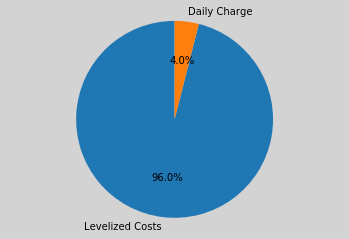

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[175, 265, 150, 1, 16, 11, 0.7999999999999998, 0.5999999999999999, 0.35, 3363.09, 325.209, 205.586, 0.0, 119.623, {'Levelized Costs': 3230.0260000000003, 'Energy Charge': 0.021999999999707143, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60000279086, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (175, 170, 175, 16, 46, 16, 0.5499999999999999, 0.8999999999999999, 0.7999999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 175
                                           a tilt of 16.0
                                           and a gcr of 0.550


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.625901937484741 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 46.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.687157154083252 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 16.0
                                           and a gcr of 0.800


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.596674919128418 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 144 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 94s


ERROR:ga_logger:panel relevance: [304.053, 0.0, 0.0]


ERROR:ga_logger:Cost: 3152.97


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,153 per year


Total roof area of the  building: 599 m²
Total roof area used 553 m²
Percentage: 92.3%
[[175, 170, 175, 16, 46, 16, 0.5499999999999999, 0.8999999999999999, 0.7999999999999998, 3152.97, 304.053, 304.053, 0.0, 0.0, {'Levelized Costs': 3019.915, 'Energy Charge': 0.013000000000090495, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60169206749, 61845.7, 552.824]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (215, 175, 145, 46, 36, 21, 0.6499999999999999, 0.5499999999999999, 0.44999999999999996)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 215
                                           a tilt of 46.0
                                           and a gcr of 0.650


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.571951150894165 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 36.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.435560464859009 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 145
                                           a tilt of 21.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.564941883087158 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 149 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 102s


ERROR:ga_logger:panel relevance: [0.0, 299.047, 0.0]


ERROR:ga_logger:Cost: 3103.25


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,103 per year


Total roof area of the  building: 599 m²
Total roof area used 544 m²
Percentage: 90.8%
[[215, 175, 145, 46, 36, 21, 0.6499999999999999, 0.5499999999999999, 0.44999999999999996, 3103.25, 299.047, 0.0, 299.047, 0.0, {'Levelized Costs': 2970.194, 'Energy Charge': 0.014000000000123691, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60243502001, 61845.7, 543.722]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (265, 180, 95, 41, 46, 56, 0.8499999999999999, 0.39999999999999997, 0.25)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 265
                                           a tilt of 41.0
                                           and a gcr of 0.850


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5779812335968018 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 46.0
                                           and a gcr of 0.400


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5228538513183594 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 95
                                           a tilt of 56.0
                                           and a gcr of 0.250


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.559063673019409 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 162 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 97s


ERROR:ga_logger:panel relevance: [0.0, 239.505, 0.0]


ERROR:ga_logger:Cost: 4071.42


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0252 /kWh
Total Cost of the system: $ 4,071 per year


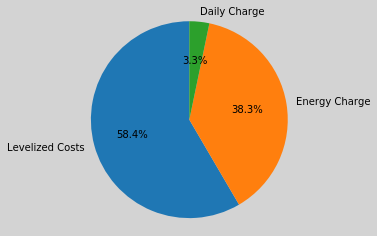

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[265, 180, 95, 41, 46, 56, 0.8499999999999999, 0.39999999999999997, 0.25, 4071.42, 239.505, 0.0, 239.505, 0.0, {'Levelized Costs': 2378.809, 'Energy Charge': 1559.569, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 49399.036390000074, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (95, 240, 135, 6, 21, 36, 0.8999999999999999, 0.7999999999999998, 0.5999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 95
                                           a tilt of 6.0
                                           and a gcr of 0.900


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6126909255981445 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 240
                                           a tilt of 21.0
                                           and a gcr of 0.800


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.076212644577026 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 135
                                           a tilt of 36.0
                                           and a gcr of 0.600


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5083518028259277 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 148 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 113s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 325.002]


ERROR:ga_logger:Cost: 3361.04


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,361 per year


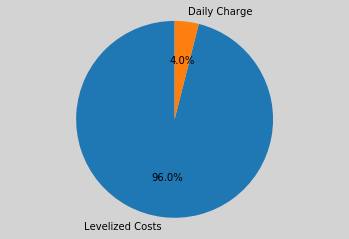

Total roof area of the  building: 599 m²
Total roof area used 542 m²
Percentage: 90.5%
[[95, 240, 135, 6, 21, 36, 0.8999999999999999, 0.7999999999999998, 0.5999999999999999, 3361.04, 325.002, 0.0, 0.0, 325.002, {'Levelized Costs': 3227.986, 'Energy Charge': 0.012000000000170985, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60319405022, 61845.7, 541.67]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (260, 225, 155, 41, 31, 41, 0.6499999999999999, 0.7999999999999998, 0.5499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 260
                                           a tilt of 41.0
                                           and a gcr of 0.650


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8029658794403076 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 225
                                           a tilt of 31.0
                                           and a gcr of 0.800


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5273053646087646 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 155
                                           a tilt of 41.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4545886516571045 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 168 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 109s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 310.118]


ERROR:ga_logger:Cost: 3213.21


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,213 per year


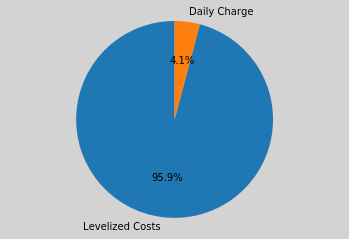

Total roof area of the  building: 599 m²
Total roof area used 564 m²
Percentage: 94.2%
[[260, 225, 155, 41, 31, 41, 0.6499999999999999, 0.7999999999999998, 0.5499999999999999, 3213.21, 310.118, 0.0, 0.0, 310.118, {'Levelized Costs': 3080.154, 'Energy Charge': 0.014000000000010004, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602168270154, 61845.7, 563.851]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (220, 195, 245, 1, 51, 1, 0.6499999999999999, 0.7999999999999998, 0.5499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 220
                                           a tilt of 1.0
                                           and a gcr of 0.650


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.791236400604248 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 195
                                           a tilt of 51.0
                                           and a gcr of 0.800


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.493328094482422 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 1.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.6520674228668213 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 167 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 119s


ERROR:ga_logger:panel relevance: [334.136, 0.0, 0.0]


ERROR:ga_logger:Cost: 3451.76


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,452 per year


Total roof area of the  building: 599 m²
Total roof area used 514 m²
Percentage: 85.9%
[[220, 195, 245, 1, 51, 1, 0.6499999999999999, 0.7999999999999998, 0.5499999999999999, 3451.76, 334.136, 334.136, 0.0, 0.0, {'Levelized Costs': 3318.702, 'Energy Charge': 0.016000000000190084, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60145668934, 61845.7, 514.055]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (195, 145, 250, 51, 11, 56, 0.5999999999999999, 0.44999999999999996, 0.3)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 195
                                           a tilt of 51.0
                                           and a gcr of 0.600


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.834779977798462 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 145
                                           a tilt of 11.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6166701316833496 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 250
                                           a tilt of 56.0
                                           and a gcr of 0.300


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5881738662719727 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 175 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 114s


ERROR:ga_logger:panel relevance: [194.105, 123.864, 0.0]


ERROR:ga_logger:Cost: 3291.19


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,291 per year


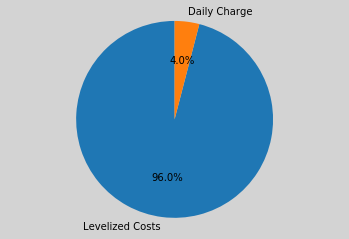

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[195, 145, 250, 51, 11, 56, 0.5999999999999999, 0.44999999999999996, 0.3, 3291.19, 317.969, 194.105, 123.864, 0.0, {'Levelized Costs': 3158.138, 'Energy Charge': 0.010000000000218279, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60224927692, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (180, 125, 145, 46, 36, 1, 0.5499999999999999, 0.44999999999999996, 0.44999999999999996)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 46.0
                                           and a gcr of 0.550


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7091152667999268 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 125
                                           a tilt of 36.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.579188823699951 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 145
                                           a tilt of 1.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.685642719268799 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 167 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 120s


ERROR:ga_logger:panel relevance: [306.525, 0.0, 0.0]


ERROR:ga_logger:Cost: 3177.52


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,178 per year


Total roof area of the  building: 599 m²
Total roof area used 557 m²
Percentage: 93.1%
[[180, 125, 145, 46, 36, 1, 0.5499999999999999, 0.44999999999999996, 0.44999999999999996, 3177.52, 306.525, 306.525, 0.0, 0.0, {'Levelized Costs': 3044.469, 'Energy Charge': 0.008999999999900865, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60199279993, 61845.7, 557.318]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (200, 195, 235, 46, 11, 1, 0.7499999999999998, 0.5499999999999999, 0.44999999999999996)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 200
                                           a tilt of 46.0
                                           and a gcr of 0.750


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.707157611846924 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 195
                                           a tilt of 11.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.09954833984375 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 235
                                           a tilt of 1.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.6395277976989746 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 197 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 115s


ERROR:ga_logger:panel relevance: [0.0, 311.881, 0.0]


ERROR:ga_logger:Cost: 3230.72


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,231 per year


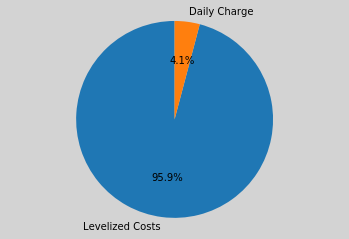

Total roof area of the  building: 599 m²
Total roof area used 567 m²
Percentage: 94.7%
[[200, 195, 235, 46, 11, 1, 0.7499999999999998, 0.5499999999999999, 0.44999999999999996, 3230.72, 311.881, 0.0, 311.881, 0.0, {'Levelized Costs': 3097.6669999999995, 'Energy Charge': 0.011000000000422006, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60249577262, 61845.7, 567.056]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (115, 200, 190, 31, 46, 26, 0.7999999999999998, 0.7, 0.7499999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 115
                                           a tilt of 31.0
                                           and a gcr of 0.800


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7061972618103027 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 200
                                           a tilt of 46.0
                                           and a gcr of 0.700


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5868332386016846 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 190
                                           a tilt of 26.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8012619018554688 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 184 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 106s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 307.75]


ERROR:ga_logger:Cost: 3189.7


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,190 per year


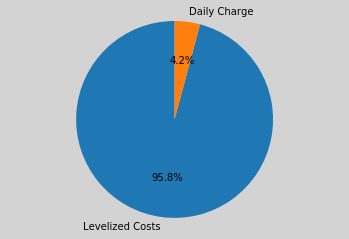

Total roof area of the  building: 599 m²
Total roof area used 410 m²
Percentage: 68.5%
[[115, 200, 190, 31, 46, 26, 0.7999999999999998, 0.7, 0.7499999999999998, 3189.7, 307.75, 0.0, 0.0, 307.75, {'Levelized Costs': 3056.653, 'Energy Charge': 0.005000000000109139, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60033080917, 61845.7, 410.334]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (175, 220, 140, 16, 26, 31, 0.7499999999999998, 0.44999999999999996, 0.25)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 175
                                           a tilt of 16.0
                                           and a gcr of 0.750


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6552278995513916 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 220
                                           a tilt of 26.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.651397228240967 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 140
                                           a tilt of 31.0
                                           and a gcr of 0.250


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6542365550994873 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 171 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 108s


ERROR:ga_logger:panel relevance: [236.87, 0.0, 70.7337]


ERROR:ga_logger:Cost: 3188.24


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,188 per year


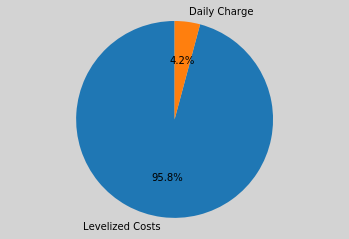

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[175, 220, 140, 16, 26, 31, 0.7499999999999998, 0.44999999999999996, 0.25, 3188.24, 307.6037, 236.87, 0.0, 70.7337, {'Levelized Costs': 3055.1769999999997, 'Energy Charge': 0.021000000000299224, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60311883427, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (185, 260, 115, 16, 16, 56, 0.3, 0.7, 0.7499999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 16.0
                                           and a gcr of 0.300


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.766988754272461 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 260
                                           a tilt of 16.0
                                           and a gcr of 0.700


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.616610050201416 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 115
                                           a tilt of 56.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5274736881256104 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 217 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 109s


ERROR:ga_logger:panel relevance: [61.8693, 274.771, 0.0]


ERROR:ga_logger:Cost: 3476.64


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,477 per year


Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[185, 260, 115, 16, 16, 56, 0.3, 0.7, 0.7499999999999998, 3476.64, 336.6403, 61.8693, 274.771, 0.0, {'Levelized Costs': 3343.584, 'Energy Charge': 0.014000000000010004, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59836715132, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (185, 110, 135, 1, 56, 26, 0.8499999999999999, 0.2, 0.7499999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 1.0
                                           and a gcr of 0.850


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.6572203636169434 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 110
                                           a tilt of 56.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.563455820083618 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 135
                                           a tilt of 26.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.552511215209961 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 156 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 116s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 327.878]


ERROR:ga_logger:Cost: 3389.6


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,390 per year


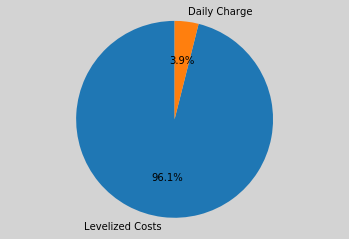

Total roof area of the  building: 599 m²
Total roof area used 437 m²
Percentage: 73.0%
[[185, 110, 135, 1, 56, 26, 0.8499999999999999, 0.2, 0.7499999999999998, 3389.6, 327.878, 0.0, 0.0, 327.878, {'Levelized Costs': 3256.543, 'Energy Charge': 0.014999999999986358, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601118961225, 61845.7, 437.17]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (180, 135, 230, 11, 36, 46, 0.8999999999999999, 0.8499999999999999, 0.3)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 11.0
                                           and a gcr of 0.900


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.583181858062744 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 135
                                           a tilt of 36.0
                                           and a gcr of 0.850


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.502812147140503 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 230
                                           a tilt of 46.0
                                           and a gcr of 0.300


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5467770099639893 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 160 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 93s


ERROR:ga_logger:panel relevance: [321.434, 0.0, 0.0]


ERROR:ga_logger:Cost: 3325.61


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,326 per year


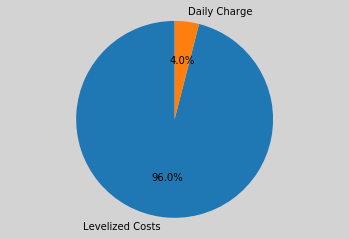

Total roof area of the  building: 599 m²
Total roof area used 357 m²
Percentage: 59.6%
[[180, 135, 230, 11, 36, 46, 0.8999999999999999, 0.8499999999999999, 0.3, 3325.61, 321.434, 321.434, 0.0, 0.0, {'Levelized Costs': 3192.5490000000004, 'Energy Charge': 0.019000000000005457, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60228553615, 61845.7, 357.149]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (245, 95, 185, 36, 46, 26, 0.35, 0.8999999999999999, 0.7499999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 245
                                           a tilt of 36.0
                                           and a gcr of 0.350


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6236608028411865 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 95
                                           a tilt of 46.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4616851806640625 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 185
                                           a tilt of 26.0
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.558713436126709 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 147 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 98s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 306.168]


ERROR:ga_logger:Cost: 3173.98


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,174 per year


Total roof area of the  building: 599 m²
Total roof area used 408 m²
Percentage: 68.2%
[[245, 95, 185, 36, 46, 26, 0.35, 0.8999999999999999, 0.7499999999999998, 3173.98, 306.168, 0.0, 0.0, 306.168, {'Levelized Costs': 3040.929, 'Energy Charge': 0.009000000000071395, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60085441469, 61845.7, 408.225]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (245, 190, 150, 56, 6, 31, 0.8499999999999999, 0.7, 0.6499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 245
                                           a tilt of 56.0
                                           and a gcr of 0.850


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.677701711654663 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 190
                                           a tilt of 6.0
                                           and a gcr of 0.700


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6665701866149902 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 31.0
                                           and a gcr of 0.650


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.403862953186035 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 146 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 102s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 312.288]


ERROR:ga_logger:Cost: 3234.76


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,235 per year


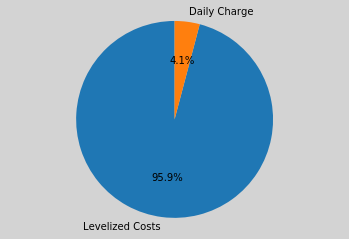

Total roof area of the  building: 599 m²
Total roof area used 480 m²
Percentage: 80.2%
[[245, 190, 150, 56, 6, 31, 0.8499999999999999, 0.7, 0.6499999999999999, 3234.76, 312.288, 0.0, 0.0, 312.288, {'Levelized Costs': 3101.7000000000003, 'Energy Charge': 0.017999999999858574, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600013414034, 61845.7, 480.443]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (180, 145, 250, 36, 11, 6, 0.7499999999999998, 0.7999999999999998, 0.5499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 36.0
                                           and a gcr of 0.750


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5919480323791504 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 145
                                           a tilt of 11.0
                                           and a gcr of 0.800


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.430271625518799 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 250
                                           a tilt of 6.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3943932056427 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 141 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 105s


ERROR:ga_logger:panel relevance: [310.227, 0.0, 0.0]


ERROR:ga_logger:Cost: 3214.3


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,214 per year


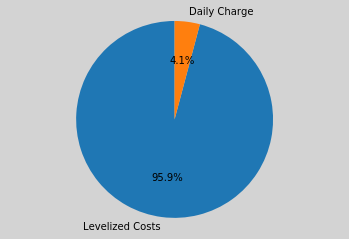

Total roof area of the  building: 599 m²
Total roof area used 414 m²
Percentage: 69.1%
[[180, 145, 250, 36, 11, 6, 0.7499999999999998, 0.7999999999999998, 0.5499999999999999, 3214.3, 310.227, 310.227, 0.0, 0.0, {'Levelized Costs': 3081.241, 'Energy Charge': 0.017000000000166438, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60288451289, 61845.7, 413.636]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (265, 245, 130, 56, 16, 51, 0.6499999999999999, 0.5499999999999999, 0.7)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 265
                                           a tilt of 56.0
                                           and a gcr of 0.650


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.558464527130127 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 245
                                           a tilt of 16.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6747307777404785 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 130
                                           a tilt of 51.0
                                           and a gcr of 0.700


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6894521713256836 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 146 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 108s


ERROR:ga_logger:panel relevance: [0.0, 328.864, 0.0]


ERROR:ga_logger:Cost: 3399.4


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,399 per year


Total roof area of the  building: 599 m²
Total roof area used 598 m²
Percentage: 99.9%
[[265, 245, 130, 56, 16, 51, 0.6499999999999999, 0.5499999999999999, 0.7, 3399.4, 328.864, 0.0, 328.864, 0.0, {'Levelized Costs': 3266.348, 'Energy Charge': 0.010000000000104592, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60201971927, 61845.7, 597.935]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (185, 215, 120, 21, 51, 36, 0.35, 0.8499999999999999, 0.8499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 21.0
                                           and a gcr of 0.350


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.211849212646484 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 215
                                           a tilt of 51.0
                                           and a gcr of 0.850


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5122718811035156 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 120
                                           a tilt of 36.0
                                           and a gcr of 0.850


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3859212398529053 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 140 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 112s


ERROR:ga_logger:panel relevance: [118.725, 220.615, 0.0]


ERROR:ga_logger:Cost: 3503.45


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,503 per year


Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[185, 215, 120, 21, 51, 36, 0.35, 0.8499999999999999, 0.8499999999999999, 3503.45, 339.34000000000003, 118.725, 220.615, 0.0, {'Levelized Costs': 3370.4019999999996, 'Energy Charge': 0.006000000000312866, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.6046017319, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (130, 160, 200, 26, 26, 41, 0.8999999999999999, 0.3, 0.5499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 130
                                           a tilt of 26.0
                                           and a gcr of 0.900


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.516380786895752 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 160
                                           a tilt of 26.0
                                           and a gcr of 0.300


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4933037757873535 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 200
                                           a tilt of 41.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.610915422439575 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 145 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 107s


ERROR:ga_logger:panel relevance: [0.0, 27.4138, 279.06]


ERROR:ga_logger:Cost: 3177.02


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,177 per year


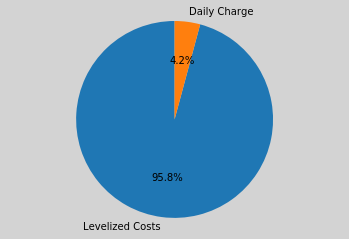

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[130, 160, 200, 26, 26, 41, 0.8999999999999999, 0.3, 0.5499999999999999, 3177.02, 306.4738, 0.0, 27.4138, 279.06, {'Levelized Costs': 3043.962, 'Energy Charge': 0.016000000000076398, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60095433674, 61845.7, 598.762]]


ERROR:optimizer_logger:200


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


ERROR:optimizer_logger:Finished and stored: {'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


ERROR:Runs_logger:Time in minutes for the 200 runs frequency 2:


ERROR:Runs_logger:1394.5852546374003


In [27]:
import time
t1=time.time()

pvoptimizer = pvOptimizer.PvOptimizer(range_azi=range_azi,
                         range_tilt=range_tilt,
                         range_gcr=range_gcr,
                         pvpanel=pvpanel,
                         price=price,
                         store_file=ga_file,
                         ehub_request=request_format,
                         res_file=res_file,
                         pvbuilding=pvbuilding,
                         roof_area_per_unit_capacity=roof_area_per_unit_capacity,
                         ga_proc=ga_proc,
                         solver_settings=default_settings)
if (runs_num ==1):
    init_pop=1
else:
    init_pop=50
    
pvoptimizer.runGA(runs_num,init_pop,"BC","DUAL")
pvoptimizer.processGA(ga_fina)
# runtime in seconds
endtime=time.time()-t1
mintime=endtime/60
lrun.error("Time in minutes for the {} runs frequency {}:".format(runs_num,run_i))
lrun.error(mintime)
